In [1]:
import uproot4
import numpy as np
import numba
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
from coffea import hist
from coffea.processor import defaultdict_accumulator
import os
import copy

import optparse
import importlib
import pathlib

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

#Just to efficiently save plots
plot_dir = "plot/"
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")
save_path = plot_dir + dt_string

print("Saving plots to: ", save_path)

#Plot settings
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

## Data processing codes
def getData(fname="", treeName="Truth"):
    dq_dict_ak1 = uproot4.lazy(fname+":"+treeName)
    dq_events = ak.zip({
                        "nTrack": ak.zip({
                                "n_tracks": dq_dict_ak1['n_tracks']
                        }),
                        "event_weight": ak.zip({
                                'weight': dq_dict_ak1['weight']
                        }),
                        "GenVertex": ak.zip({
                                            "x": dq_dict_ak1["gvx"],
                                            "y": dq_dict_ak1["gvy"],
                                            "z": dq_dict_ak1["gvz"],
                                            "px": dq_dict_ak1["gpx"],
                                            "py": dq_dict_ak1["gpy"],
                                            "pz": dq_dict_ak1["gpz"]

                        }),
                        "GenP_St1": ak.zip({
                                            "px": dq_dict_ak1["gpx_st1"],
                                            "py": dq_dict_ak1["gpy_st1"],
                                            "pz": dq_dict_ak1["gpz_st1"],
                                            "x": dq_dict_ak1["gx_st1"],
                                            "y": dq_dict_ak1["gy_st1"],
                                            "z": dq_dict_ak1["gz_st1"],
                        }),
                        "Track_St1": ak.zip({
                                            "px": dq_dict_ak1["track_px_st1"],
                                            "py": dq_dict_ak1["track_py_st1"],
                                            "pz": dq_dict_ak1["track_pz_st1"],
                                            "x": dq_dict_ak1["track_x_st1"],
                                            "y": dq_dict_ak1["track_y_st1"],
                                            "z": dq_dict_ak1["track_z_st1"],
                        }),
                        "reco_dimuon": ak.zip({
                                            "mass": dq_dict_ak1["dimuon_mass"],
                                            "x": dq_dict_ak1["dimuon_x_vtx"],
                                            "y": dq_dict_ak1["dimuon_y_vtx"],
                                            "z": dq_dict_ak1["dimuon_z_vtx"],
                                            "chisq": dq_dict_ak1["dimuon_chisq"],
                            
                        }),
                        "truth_dimuon":ak.zip({
                                            "mass": dq_dict_ak1['truthdimuon_mass'],
                                            "x": dq_dict_ak1['truthdimuon_x_vtx'],
                                            "y": dq_dict_ak1['truthdimuon_y_vtx'],
                                            "z": dq_dict_ak1['truthdimuon_z_vtx'],
                                            "px": dq_dict_ak1['truthdimuon_px'],
                                            "py": dq_dict_ak1['truthdimuon_py'],
                                            "pz": dq_dict_ak1['truthdimuon_pz'],
                            
                        })
                       }, depth_limit=1)
    return dq_events


######## READ EVENTS
sample_dir = "/mnt/T2_US_MIT/hadoop/mitgroups/DarkQuest/dhoang/DCEM_Aprime_Muons_Scan_z200_600_21_04_2022/"
filename = "/mnt/T2_US_MIT/hadoop/mitgroups/DarkQuest/dhoang/DCEM_Aprime_Muons_Scan_z200_600_21_04_2022/Brem_0.850000*.root"
dq_events = getData(filename, treeName = 'Events')

Saving plots to:  plot/13-06-2022


## Mass resoluion

Processing range:  [200, 250]
Error for parameter esimations:  [0.06977018 0.09129337 0.08633608]
Standard deviation (fit) is 0.6677487488212968
Mean (fit) is 1.0347210723523115


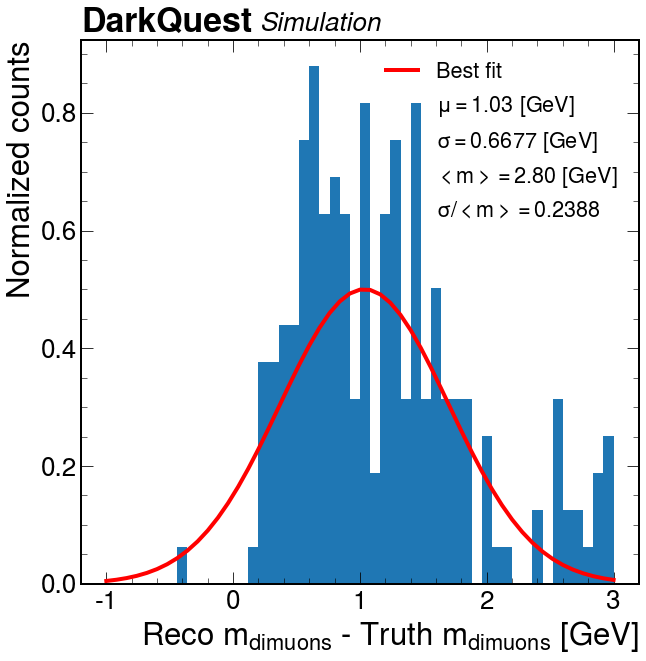

Processing range:  [250, 300]
Error for parameter esimations:  [0.03543664 0.0369387  0.03236052]
Standard deviation (fit) is 0.6842369020406808
Mean (fit) is 1.3311489059882475


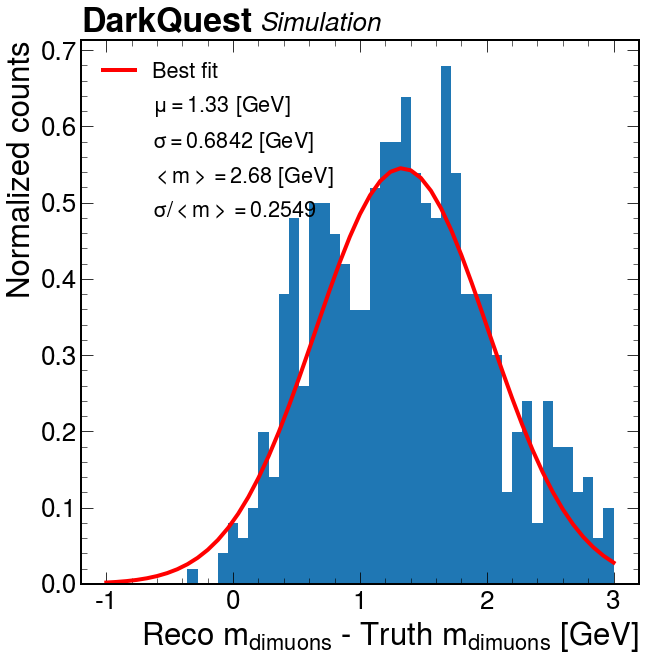

Processing range:  [300, 350]
Error for parameter esimations:  [0.03415225 0.0318442  0.02453498]
Standard deviation (fit) is 0.6416316546475845
Mean (fit) is 1.0565549509670584


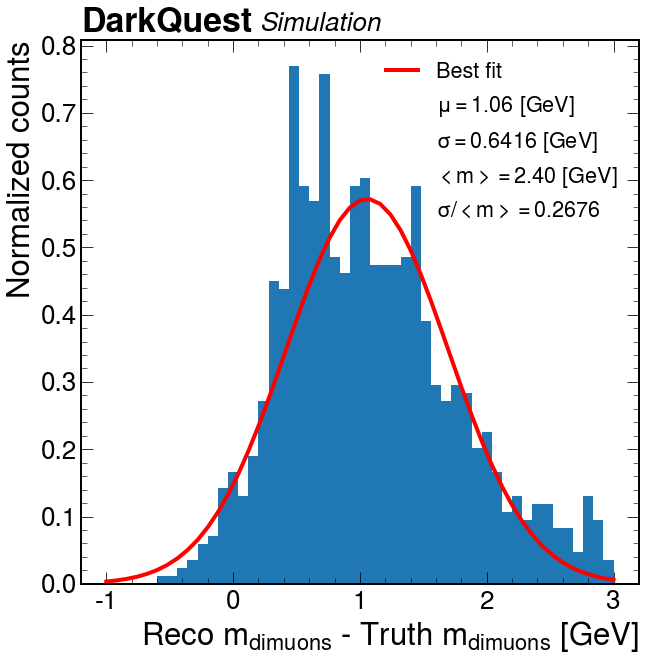

Processing range:  [350, 400]
Error for parameter esimations:  [0.04446955 0.05360332 0.04979077]
Standard deviation (fit) is 0.7115661860383246
Mean (fit) is 0.7799392070202211


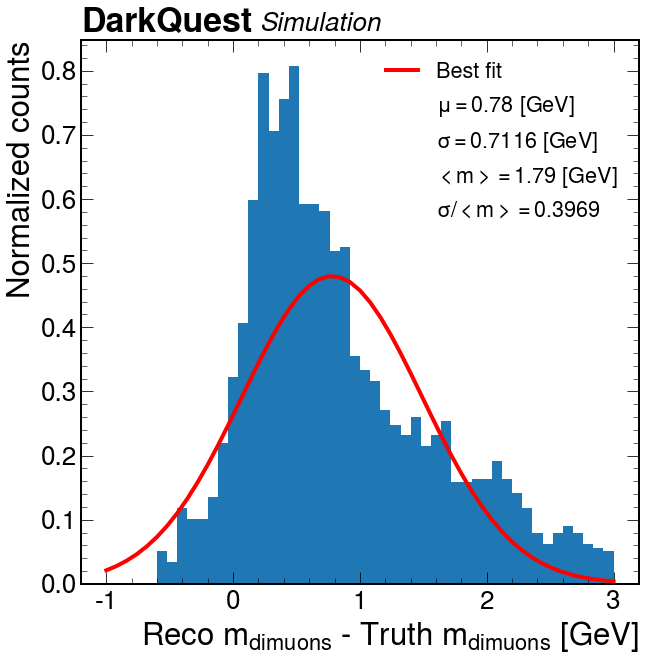

Processing range:  [400, 450]
Error for parameter esimations:  [0.02961967 0.02795103 0.02562747]
Standard deviation (fit) is 0.6388171276416342
Mean (fit) is 0.422858548110644


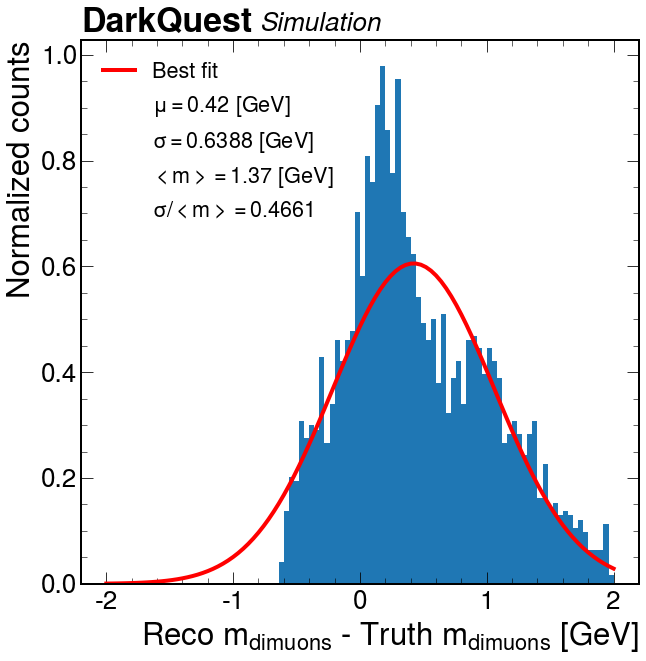

Processing range:  [450, 500]
Error for parameter esimations:  [0.05142031 0.01450983 0.01148026]
Standard deviation (fit) is 0.35656485611407346
Mean (fit) is 0.2977795009072758


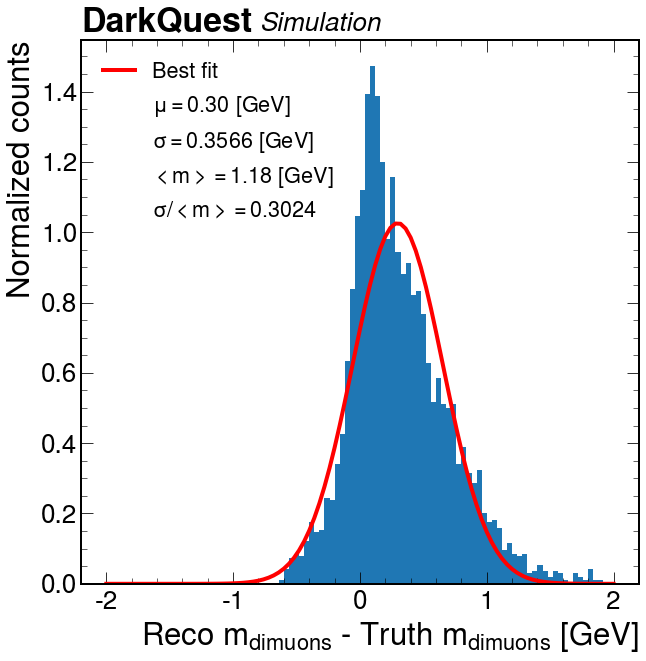

Processing range:  [500, 550]
Error for parameter esimations:  [0.15930418 0.00835475 0.00631522]
Standard deviation (fit) is 0.13506214569863534
Mean (fit) is 0.14488036965157283


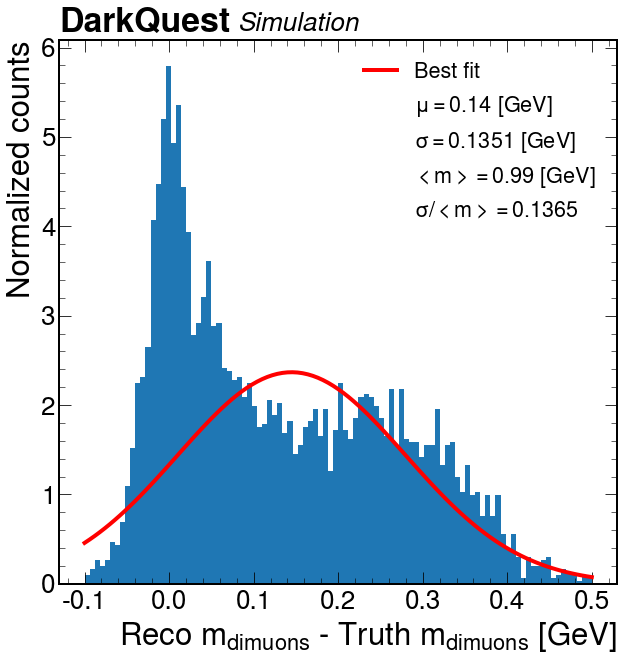

Processing range:  [550, 600]
Error for parameter esimations:  [0.17973133 0.00926435 0.00685747]
Standard deviation (fit) is 0.12919538878176057
Mean (fit) is 0.1486698244333689


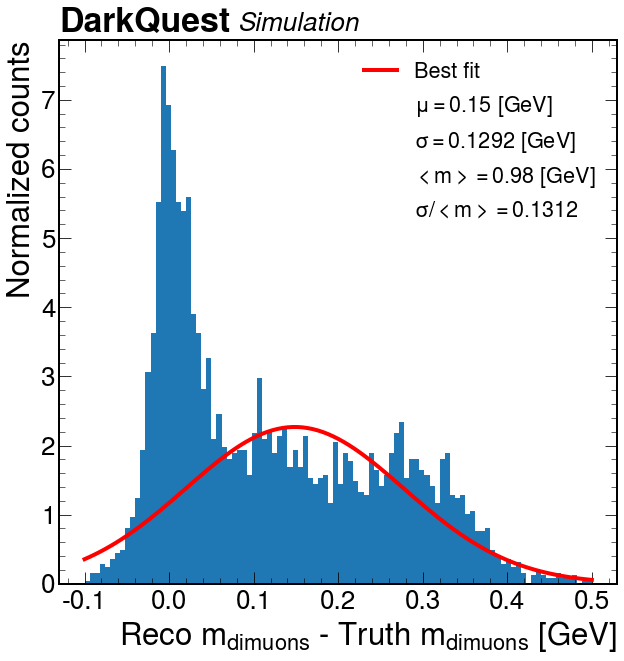

In [2]:
def reco_find_residual(dq_events, z_truth_range = [200, 250]):
    
    #Tracks selection
    reco_select = ak.count(dq_events["reco_dimuon"].mass, axis = 1) == 1
    
    truth_mass = np.asarray(ak.flatten(dq_events["truth_dimuon"].mass[reco_select]))
    reco_mass = np.asarray(ak.flatten(dq_events["reco_dimuon"].mass[reco_select]))
    truth_z = np.asarray(ak.flatten(dq_events["truth_dimuon"].z[reco_select]))
    
    nan_filter = (~np.isnan(reco_mass)) & (~np.isnan(truth_mass)) & (~np.isnan(truth_z))
    
    #filter nana
    truth_mass = truth_mass[nan_filter]
    reco_mass = reco_mass[nan_filter]
    truth_z = truth_z[nan_filter]
    
    #Range selection
    truth_z_select = (truth_z > z_truth_range[0]) & (truth_z < z_truth_range[1])
    
    truth_mass = truth_mass[truth_z_select]
    reco_mass = reco_mass[truth_z_select]
    
    #Calculate the residual
    residual = reco_mass - truth_mass
    
    return np.asarray(residual), ak.mean(reco_mass)

def gaussian_fit(residual,
                 mean,
                 plot_bins = 50,
                 plot_range = (-2,2),
                 p_guess=[2, 0.02, 0.02],
                 residual_label = r'Reco $m_{dimuons}$ - Truth $m_{dimuons}$ [GeV]'):
    
    fig, ax = plt.subplots()
    #Plot and fit
    plt.hist(residual,
         bins = plot_bins,
         range = plot_range,
         density = True,
         #alpha = 0.5
            )
    
    # Gaussian fit
    ## Fit directly on the histogram
    def fit_function(x, A, mu, sig):
        return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    
    data_entries, _ = np.histogram(residual, bins=bins,
                                   range = plot_range,
                                   density = True)
    
    mask = data_entries!=0
    #Fit the function to the histogram data.
    popt, pcov = curve_fit(fit_function,
                           xdata=binscenters[mask],
                           ydata=data_entries[mask],
                           sigma = np.sqrt(data_entries[mask]),
                           absolute_sigma = False,
                           p0=p_guess)
    
    #Error for parameter estimations
    perr = np.sqrt(np.diag(pcov))
    print("Error for parameter esimations: ", perr)

    std_fit = np.abs(popt[2])
    mean_fit = popt[1]
    
    print("Standard deviation (fit) is", std_fit)
    print("Mean (fit) is", mean_fit)
    
    #Plot fitted gaussian
    plt.plot(bins,
             fit_function(bins, *popt),
             "r-",
             linewidth=4,
             label='Best fit')

    plt.plot([],[], 'none', label=r'$\mu=%.2f$ [GeV]'%popt[1])
    plt.plot([],[], 'none', label=r'$\sigma=%.4f$ [GeV]'%abs(popt[2]))
    plt.plot([],[], 'none', label=r'$<m>=%.2f$ [GeV]'%mean)
    plt.plot([],[], 'none', label=r'$\sigma/<m>=%.4f$'%(abs(popt[2])/mean))
    
    #Label the axes
    plt.xlabel(residual_label)
    plt.ylabel('Normalized counts')
    
    hep.dq.text("Simulation") #Add "DarkQuest Simulation"
    plt.legend()
    plt.show()
    
    return abs(popt[2])/mean, perr[2]/mean


def get_mass_resolution_z(dq_events):
    
    z_range_all = [[i*50,(i+1)*50] for i in range(4,12)]
    
    res = []
    res_err = []
    
    for z_range in z_range_all:
        
        print("Processing range: ", z_range)
        m_residual, m_mean = reco_find_residual(dq_events, z_range)
        
        if z_range[0] < 500:
            if z_range[0] < 400:
                fit_range = [-1, 3]
                po = [1.2, 1, 0.02]
                res_temp, res_err_temp = gaussian_fit(m_residual, m_mean, plot_range= fit_range, p_guess=po,)
            else:
                res_temp, res_err_temp = gaussian_fit(m_residual, m_mean, plot_bins = 100)
        else:
            fit_range = [-0.1, 0.5]
            po = [50, 0.02, 0.02]
            
            res_temp, res_err_temp = gaussian_fit(m_residual, m_mean, plot_range= fit_range, p_guess=po, plot_bins=100)
            
        
        res.append(res_temp)
        res_err.append(res_err_temp) 
    
    return z_range_all, res, res_err
    
#### Do your plotting here
z_list, res_list, res_err_list = get_mass_resolution_z(dq_events)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


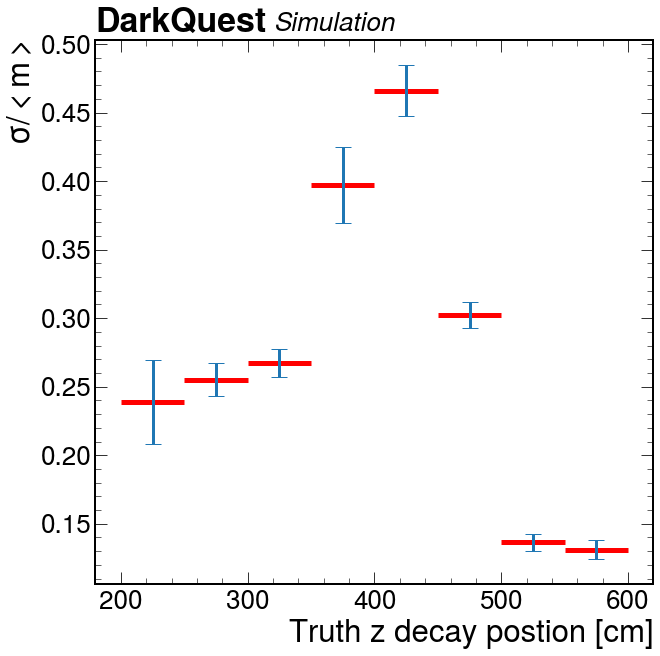

In [6]:
plt.hlines(res_list,
           [x[0] for x in z_list],
           [x[1] for x in z_list],
           colors='r', lw=5,
           linestyles='solid')

#Plot the error bars
plt.errorbar([np.average(x) for x in z_list],
            res_list,
            yerr=res_err_list,
            fmt='none',
            elinewidth=3,
            capsize=8)

plt.xlabel(r'Truth z decay postion [cm]')
plt.ylabel(r'$\sigma/<m>$')

plt.legend()
hep.dq.text("Simulation")
plt.show()

## Mass residual for different couplings

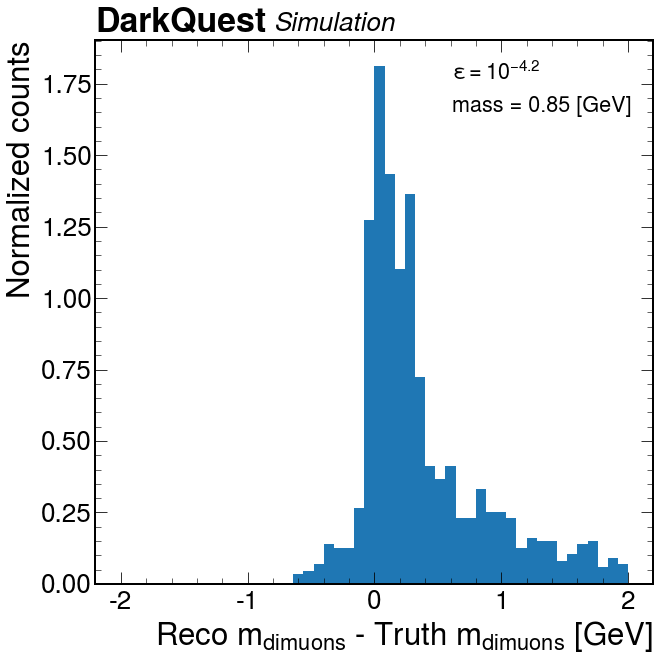

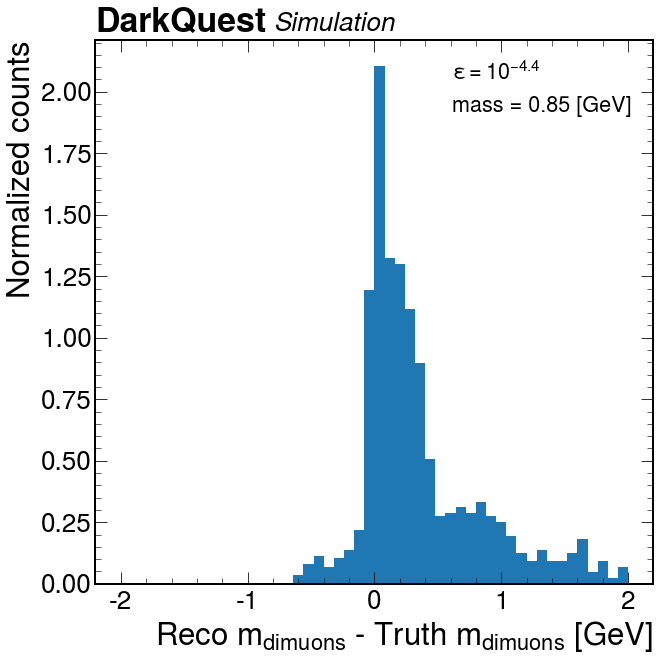

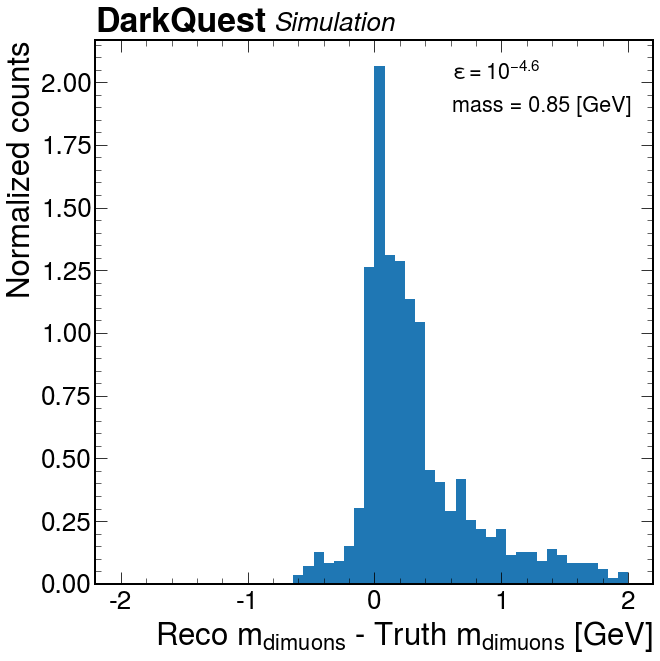

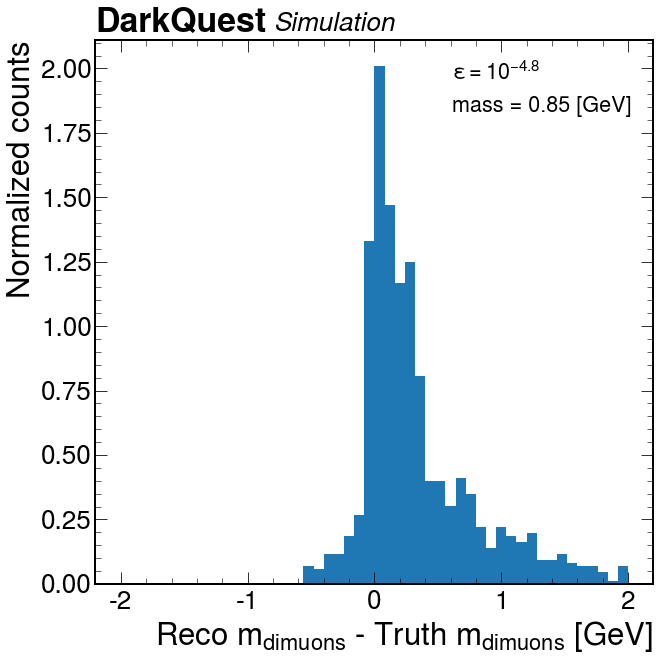

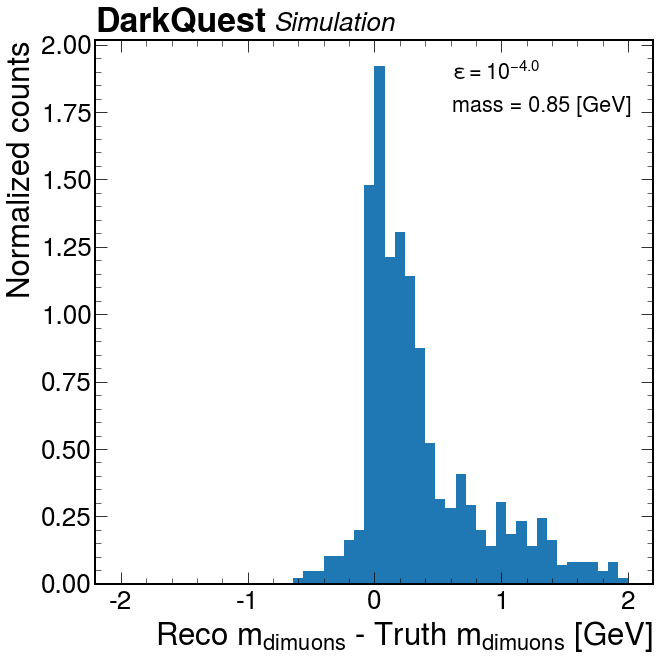

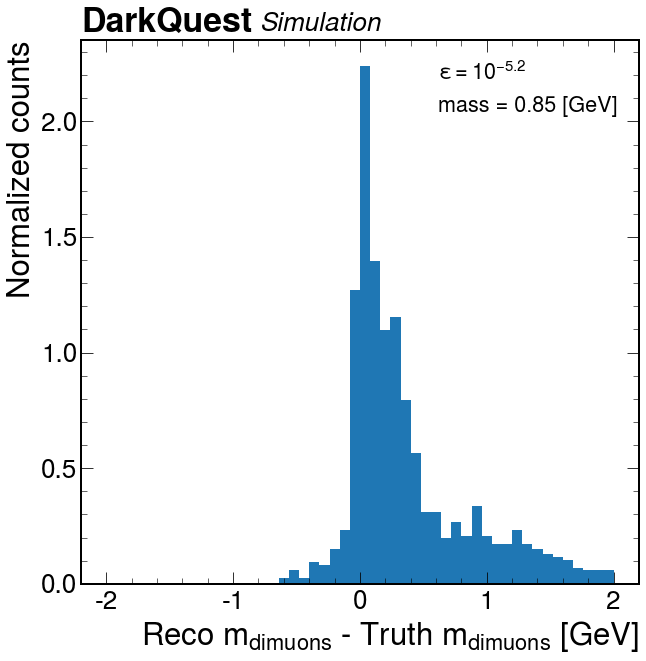

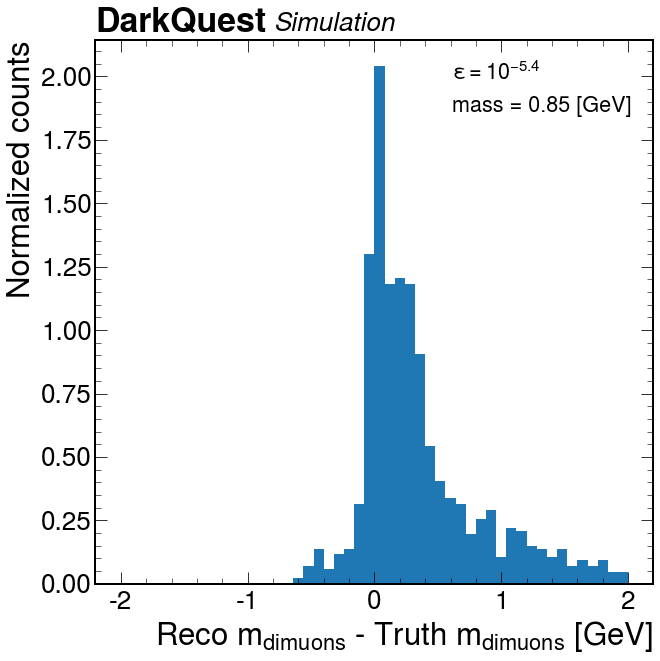

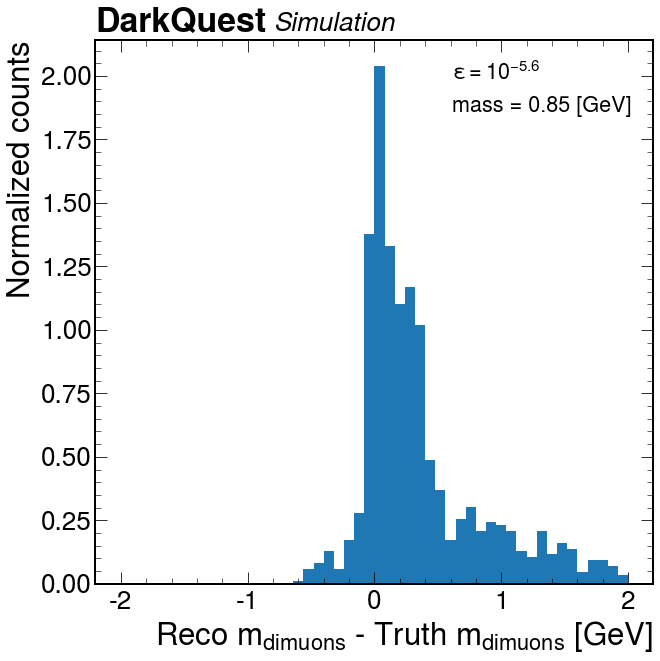

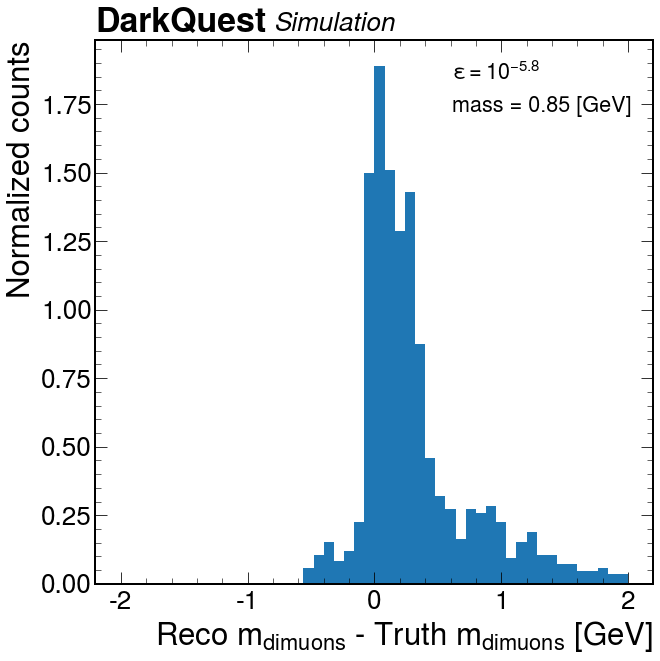

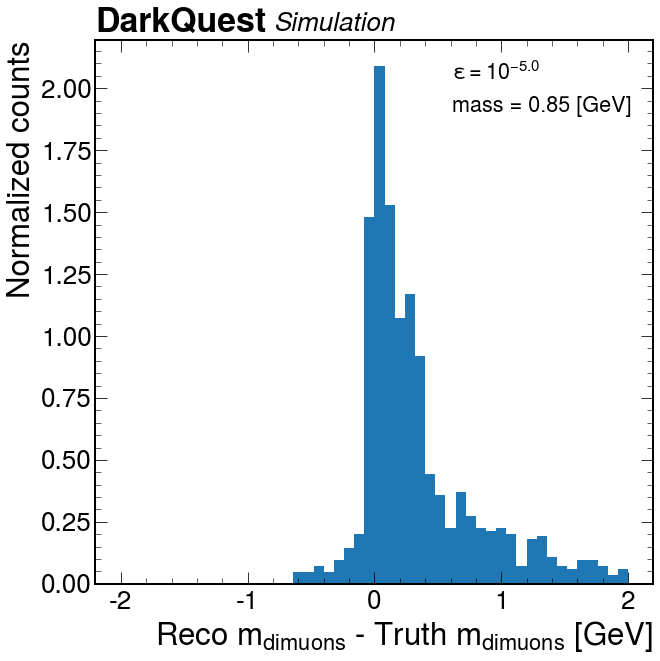

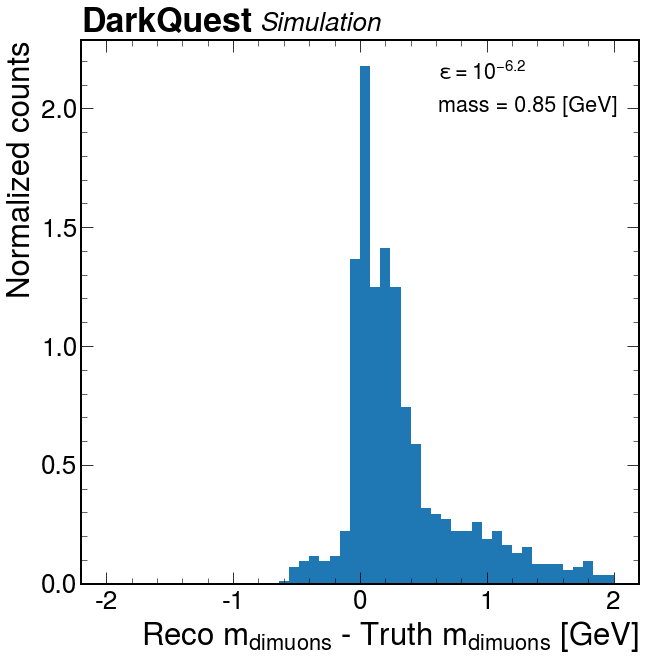

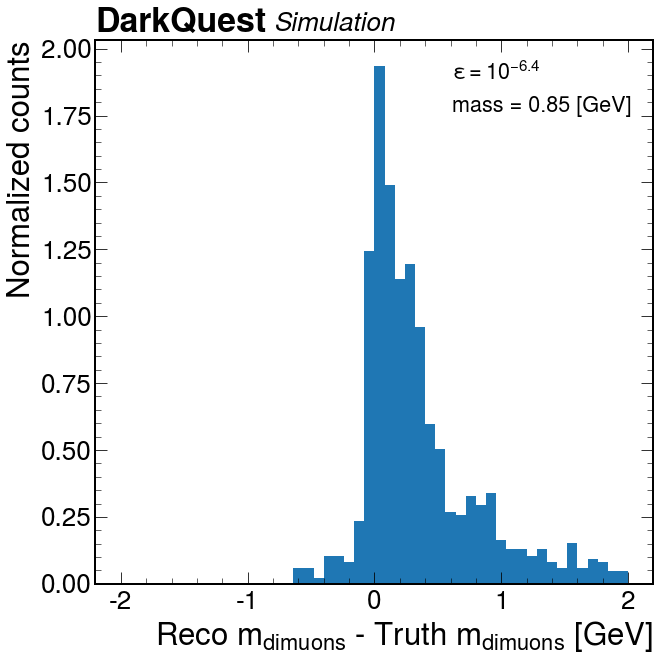

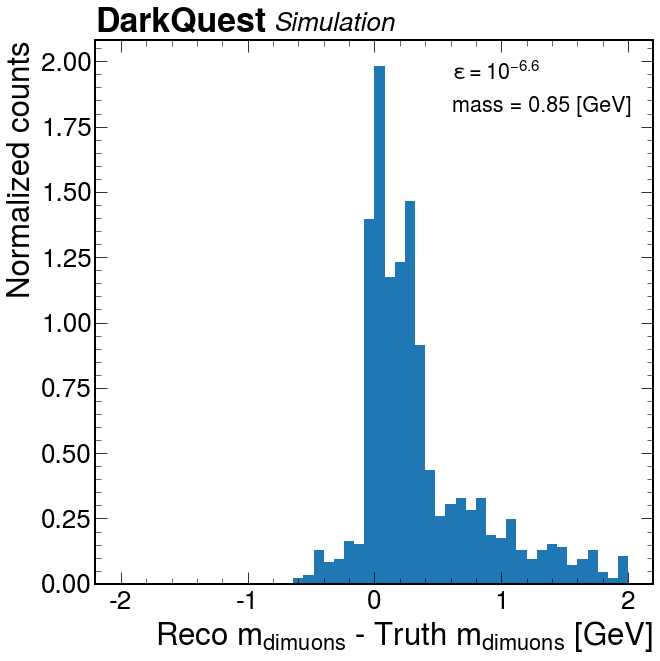

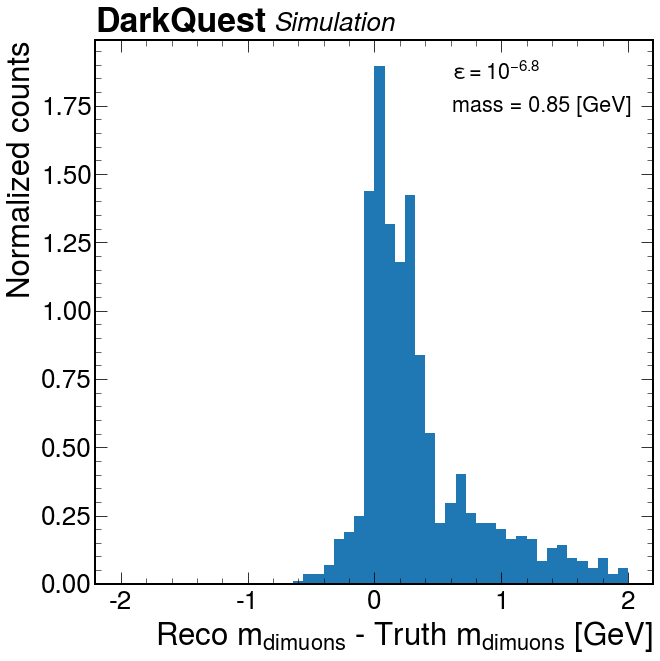

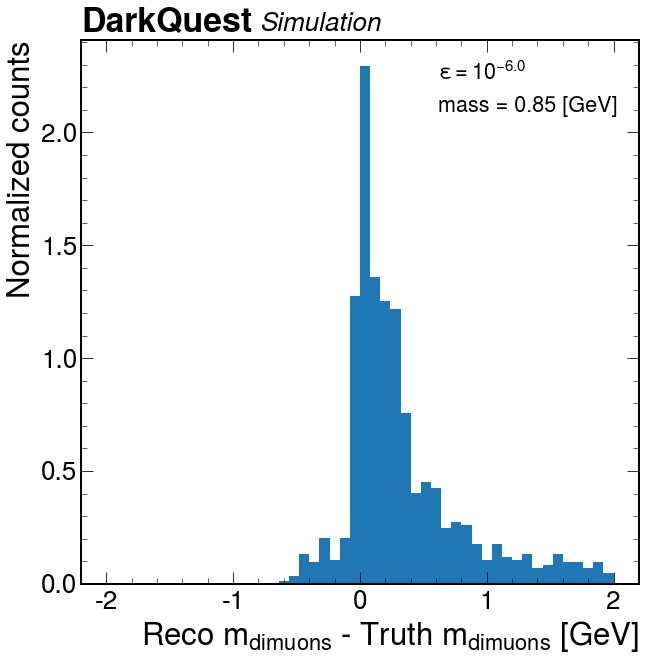

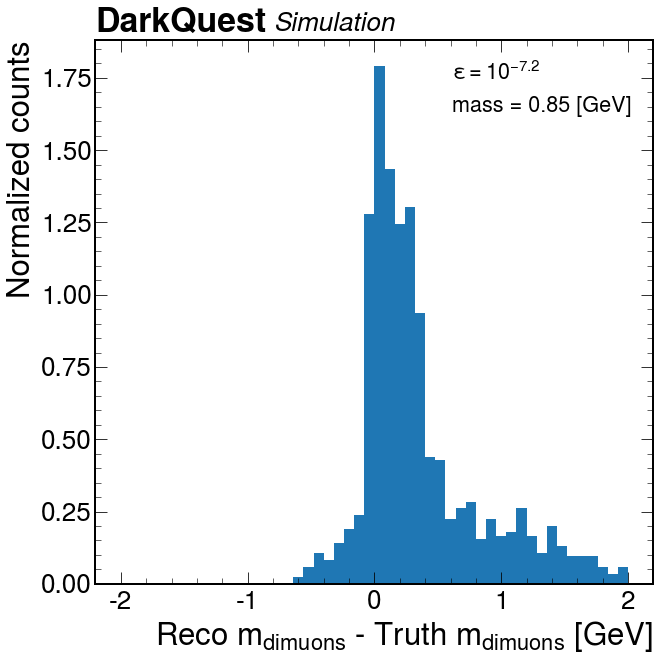

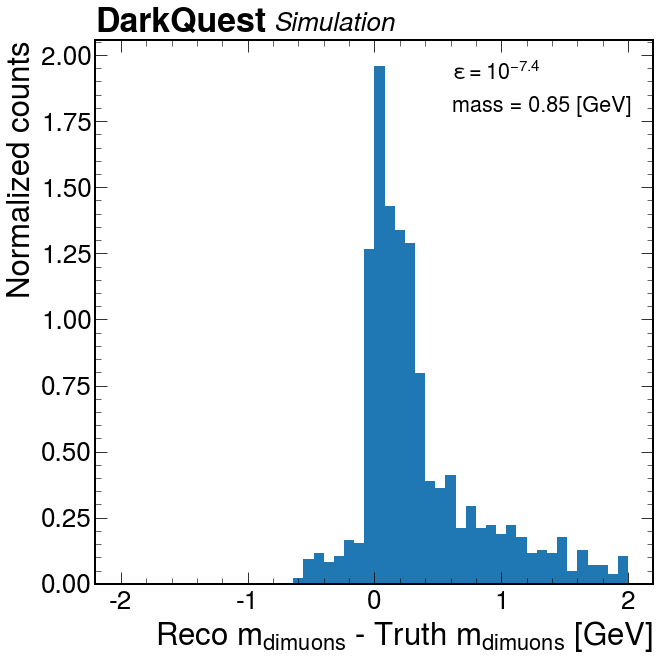

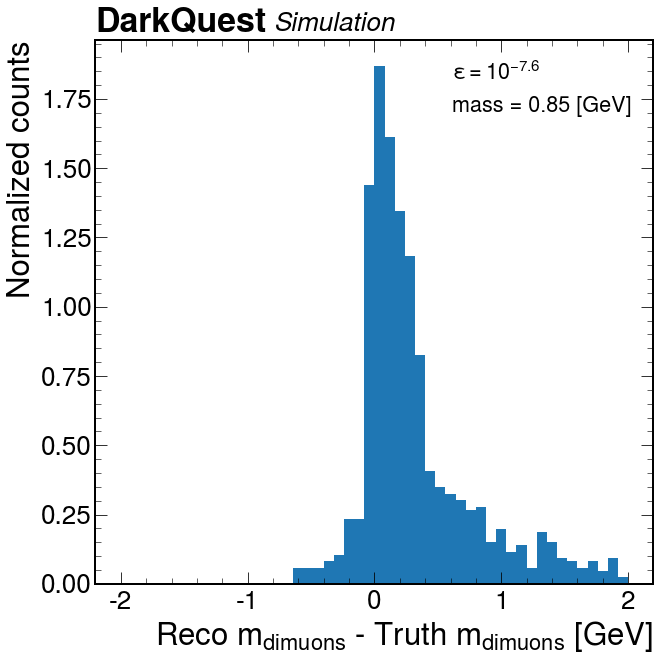

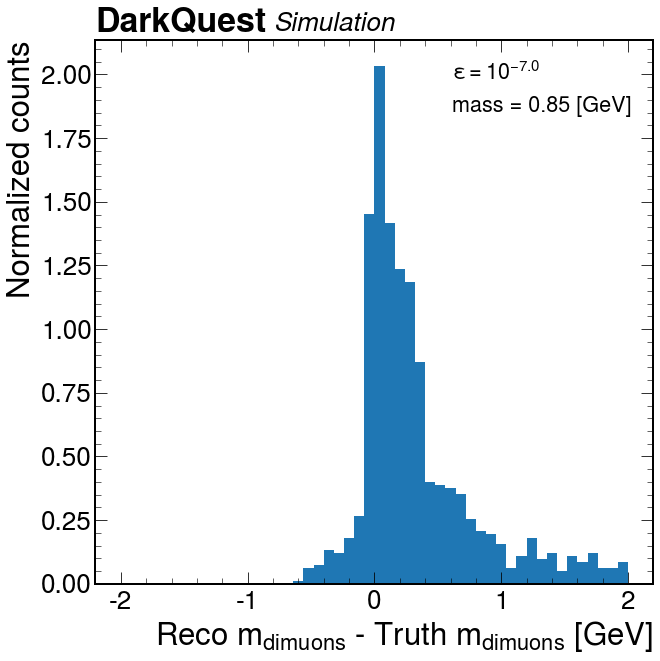

In [8]:
def plot_residual(dq_events, coupling, mass, plot_bins = 50, plot_range = (-2,2)):
    
    #Tracks selection
    reco_select = ak.count(dq_events["reco_dimuon"].mass, axis = 1) == 1
    
    truth_mass = np.asarray(ak.flatten(dq_events["truth_dimuon"].mass[reco_select]))
    reco_mass = np.asarray(ak.flatten(dq_events["reco_dimuon"].mass[reco_select]))
    truth_z = np.asarray(ak.flatten(dq_events["truth_dimuon"].z[reco_select]))
    
    nan_filter = (~np.isnan(reco_mass)) & (~np.isnan(truth_mass)) & (~np.isnan(truth_z))
    
    #filter nana
    truth_mass = truth_mass[nan_filter]
    reco_mass = reco_mass[nan_filter]
    truth_z = truth_z[nan_filter]
    
    #Calculate the residual
    residual = reco_mass - truth_mass
    
    #Plot the residual
    plt.hist(residual, bins = plot_bins, range = plot_range, density = True)
    plt.xlabel(r'Reco $m_{dimuons}$ - Truth $m_{dimuons}$ [GeV]')
    plt.ylabel('Normalized counts')
    
    plt.plot([],[], 'none', label=r"$\epsilon = 10^{%s}$"%coupling)
    plt.plot([],[], 'none', label=r'mass = {} [GeV]'.format(mass))
    
    hep.dq.text("Simulation") #Add "DarkQuest Simulation"
    plt.legend()
    plt.show()
    
    
    return np.asarray(residual), ak.mean(reco_mass)

def scan_coupling(scan_dir):
    
    #Loop through different couplings
    for filename in os.listdir(scan_dir):
        if filename.startswith("Brem_0.850000"):
            
            #Parse some basic info
            Ap_config = filename[:-5].split('_') #Remove the .root part and split by '_'
            coupling = float(Ap_config[-1])
            mass = float(Ap_config[1])
            
            #Load the data
            dq_events = getData(os.path.join(scan_dir, filename), 'Events')

            #Plot the residual
            plot_residual(dq_events, coupling, mass)



scan_coupling("/mnt/T2_US_MIT/hadoop/mitgroups/DarkQuest/dhoang/DCEM_Aprime_Muons_Scan_z200_600_21_04_2022/")

------

# Mass residual for different masses

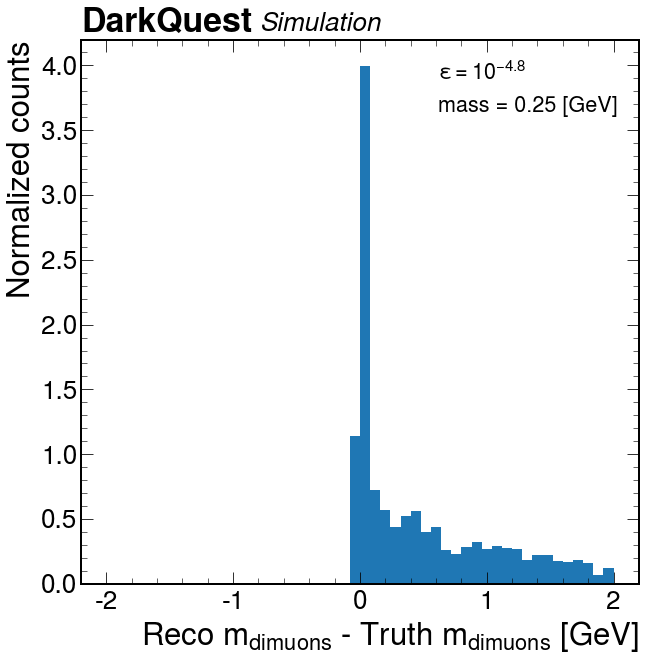

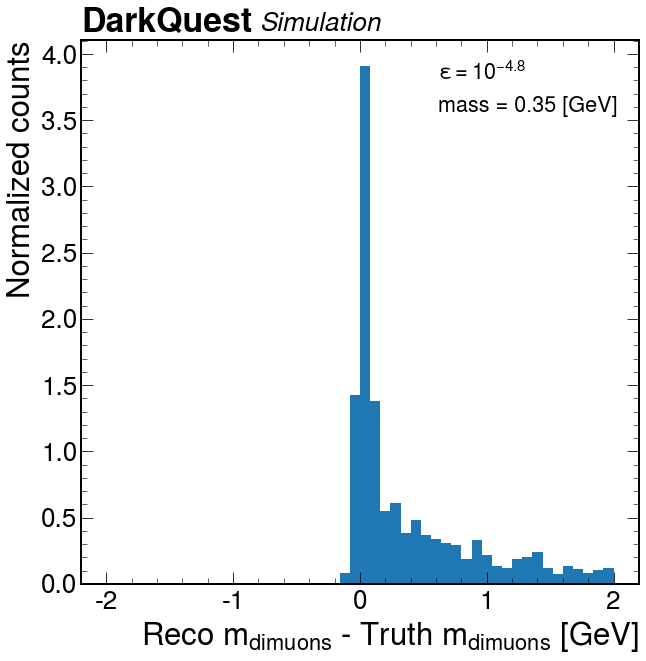

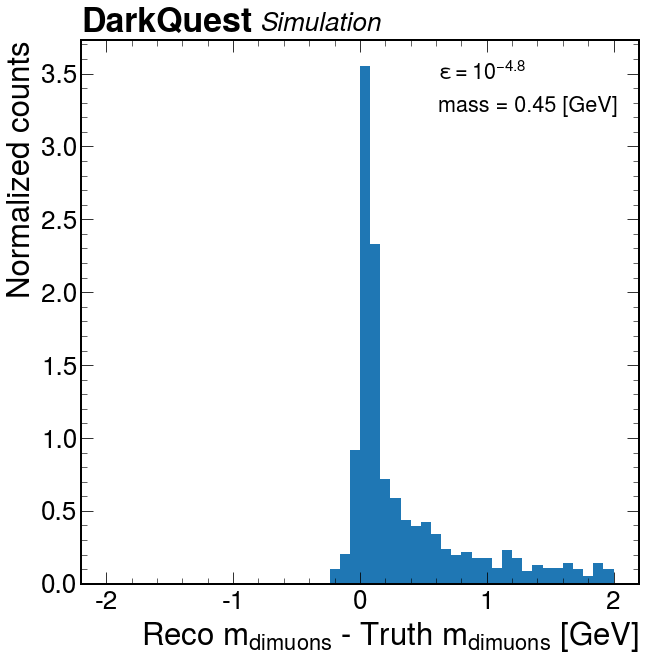

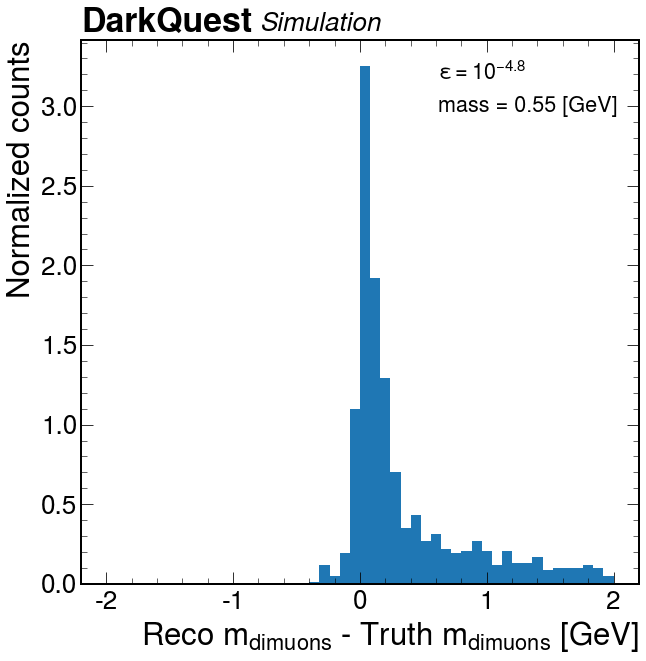

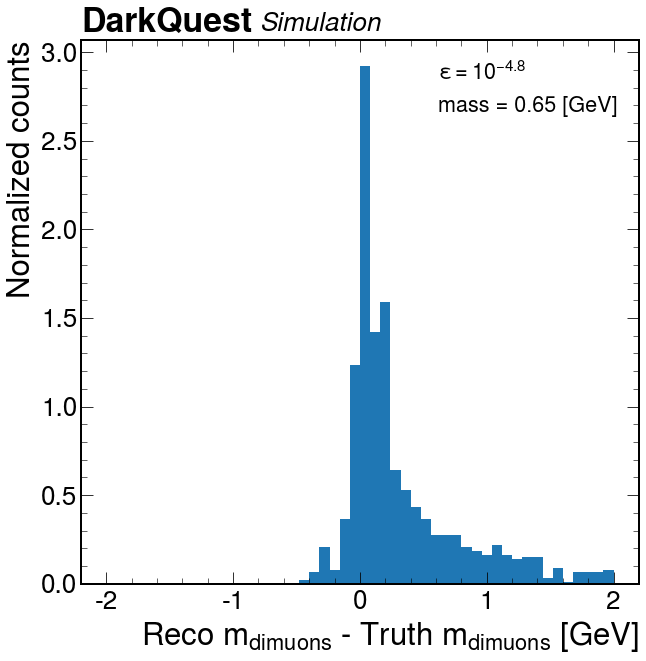

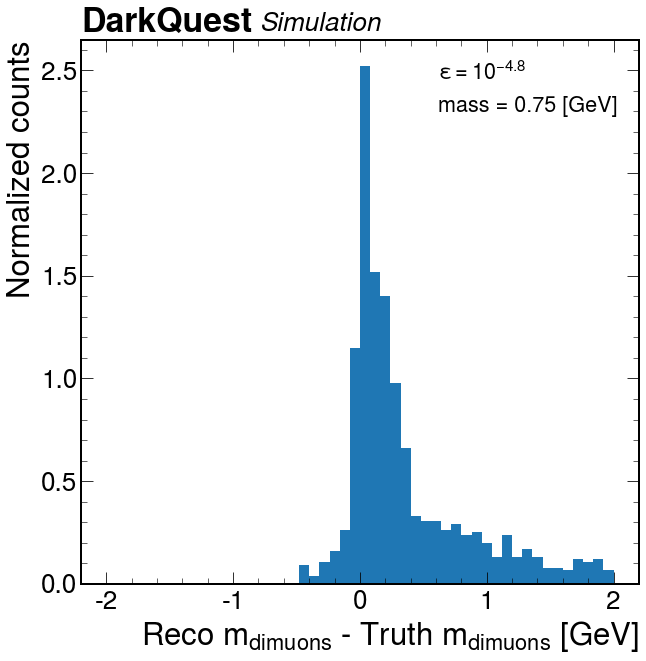

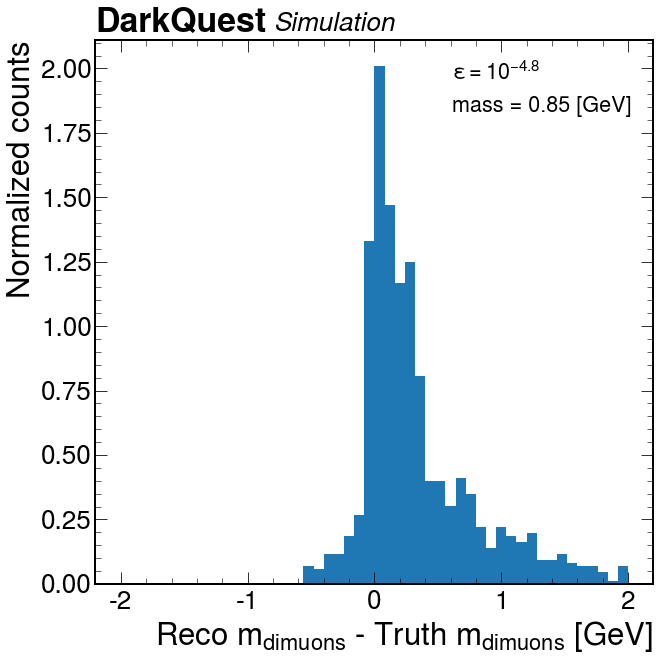

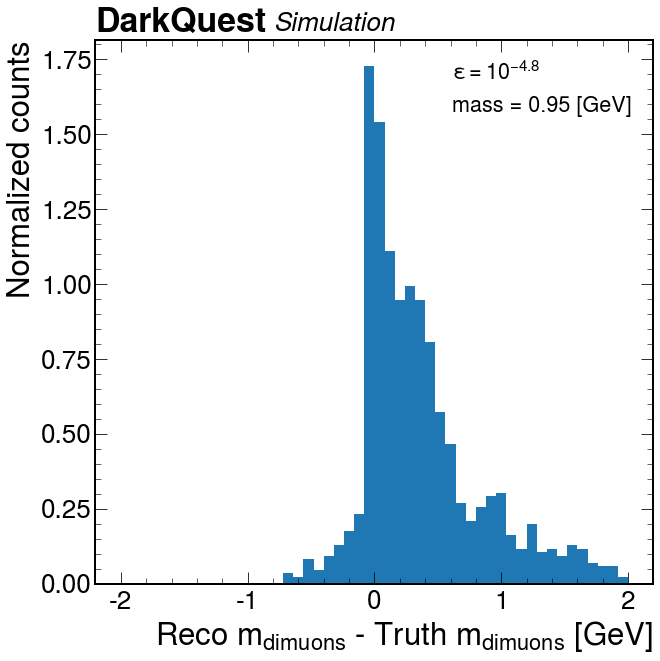

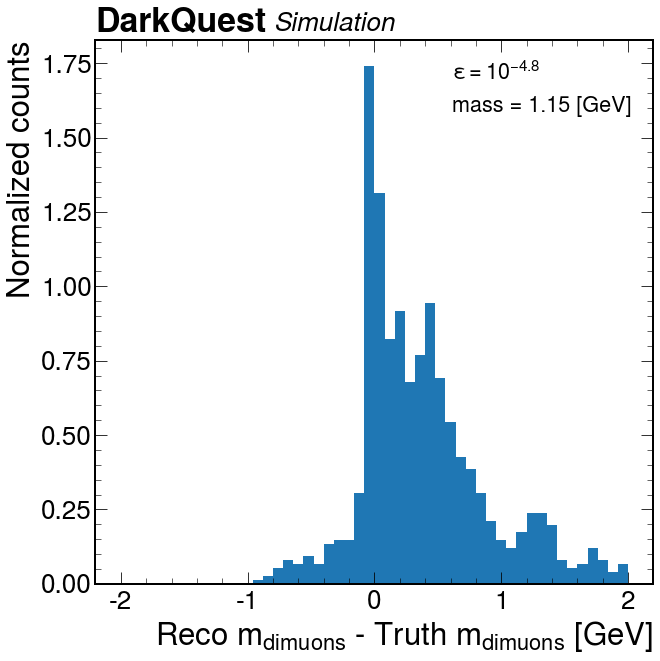

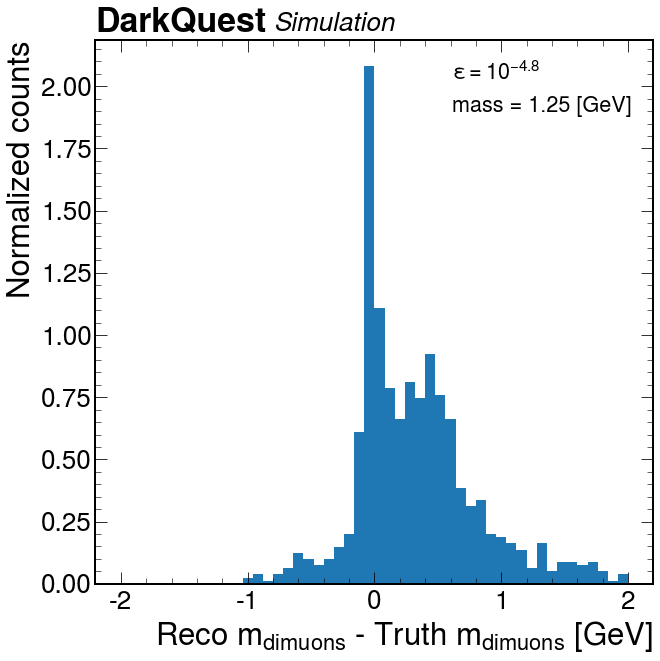

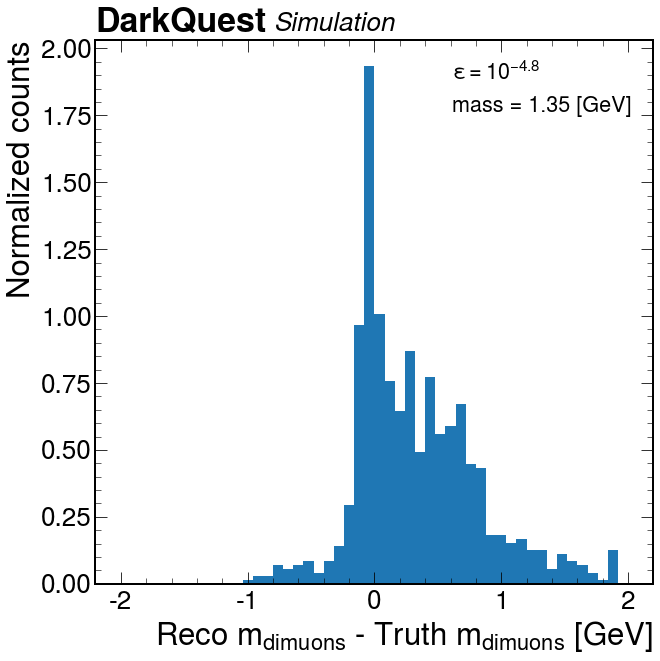

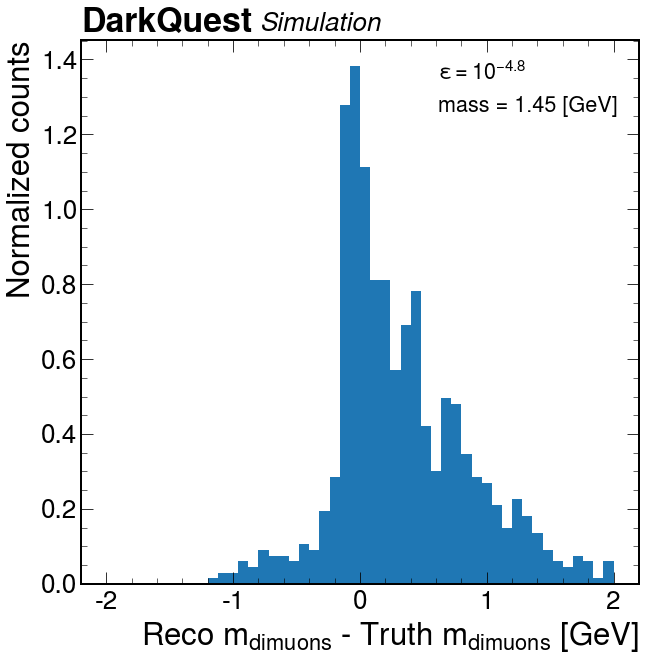

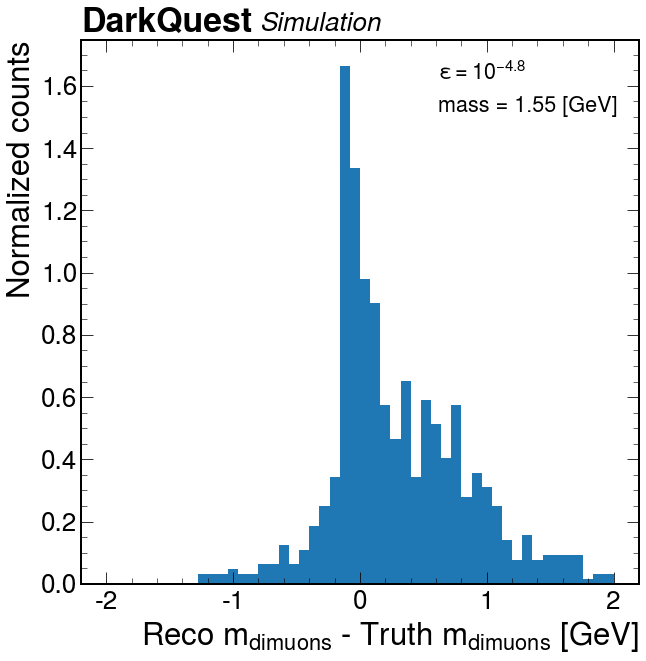

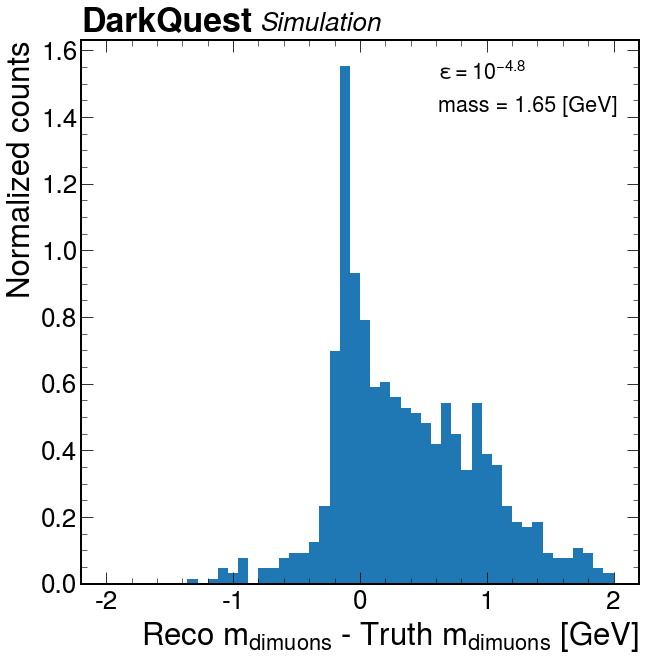

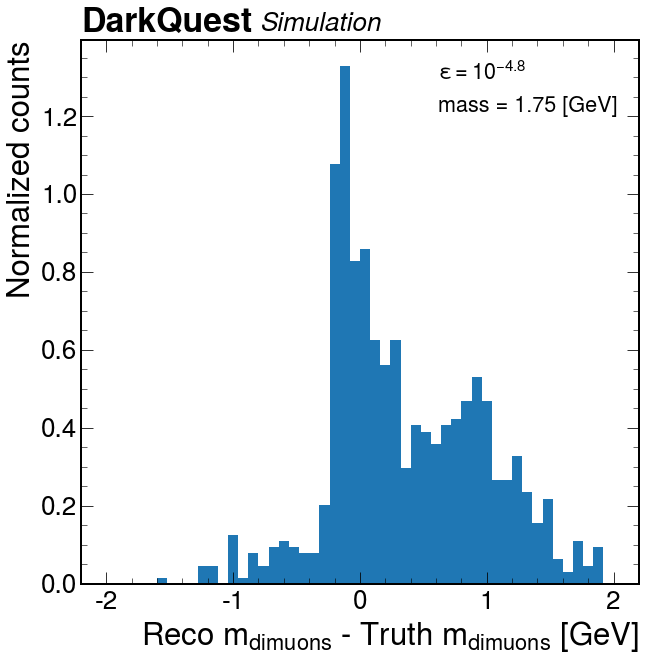

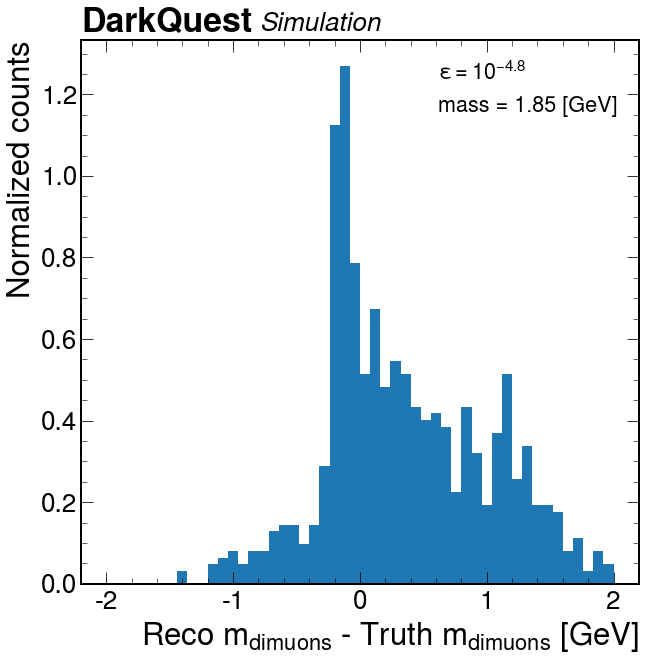

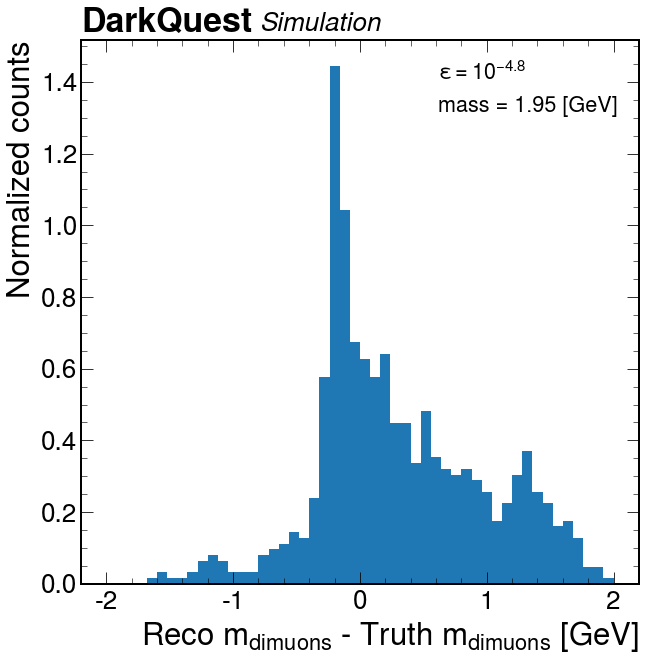

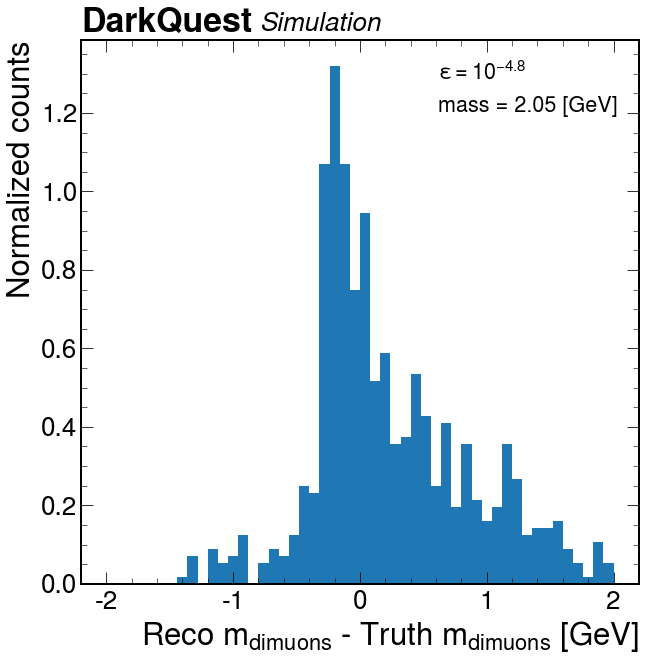

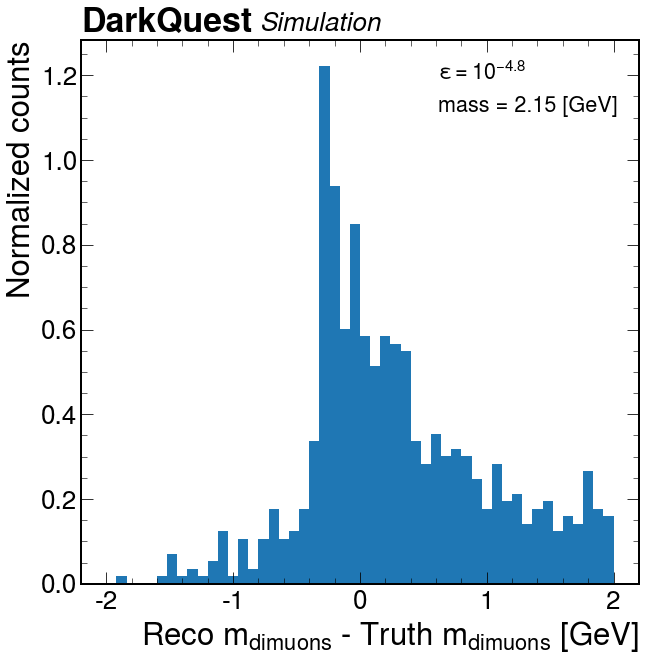

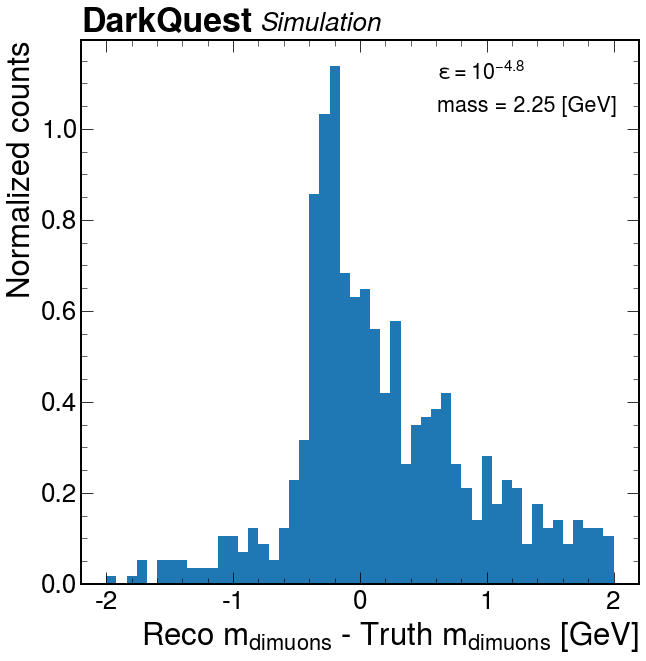

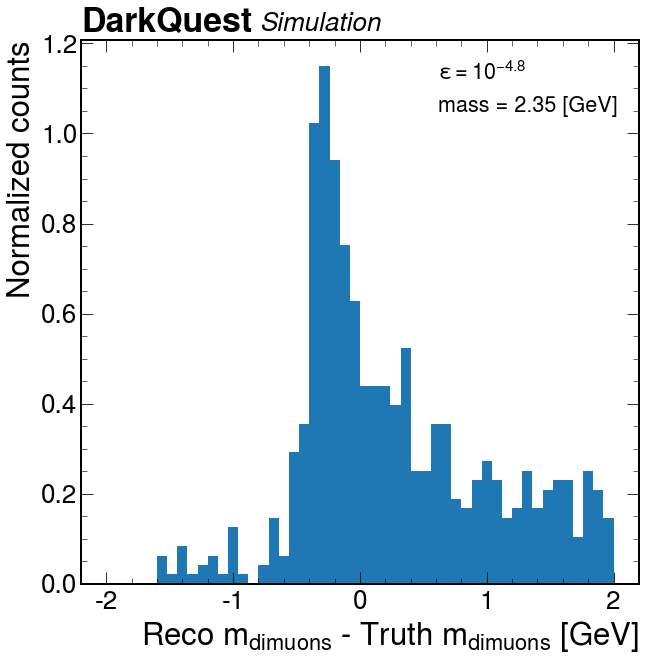

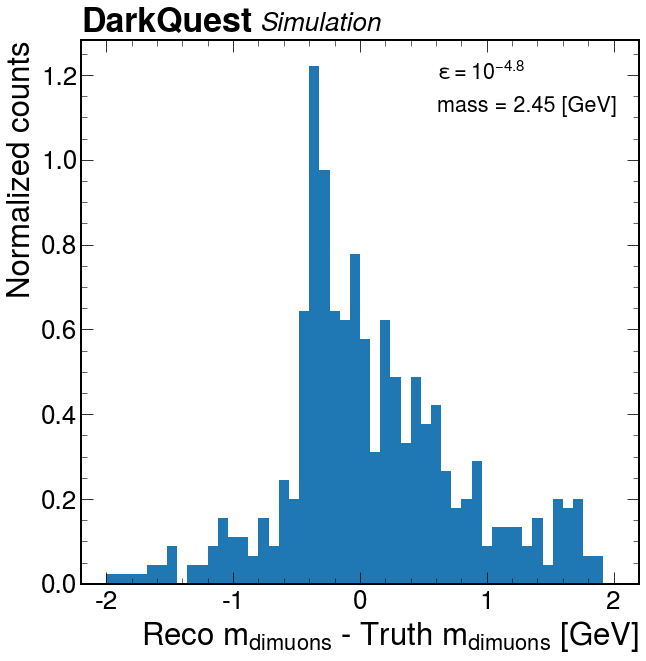

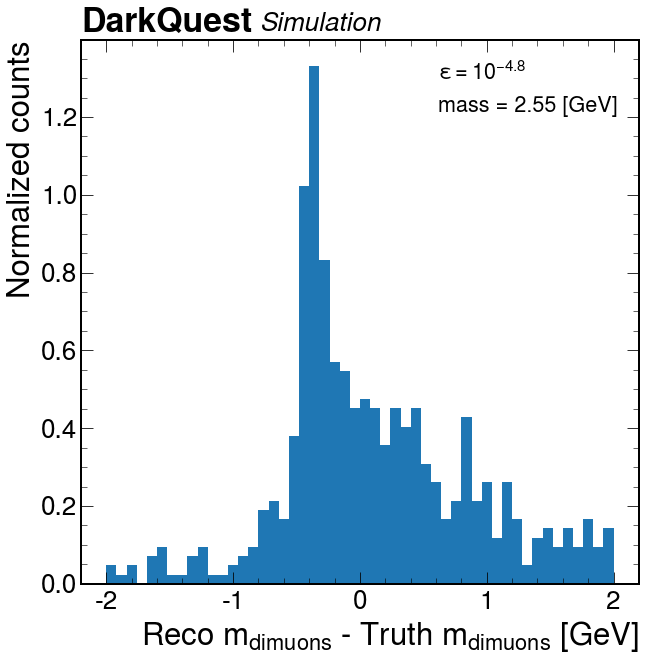

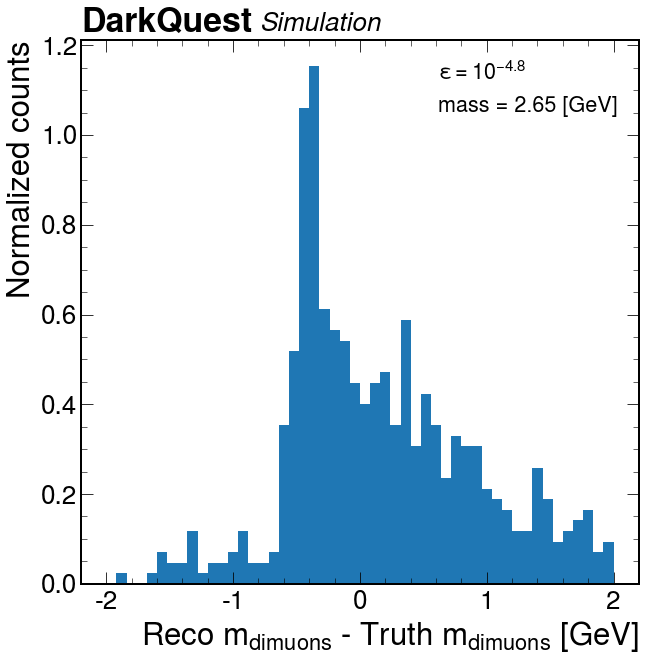

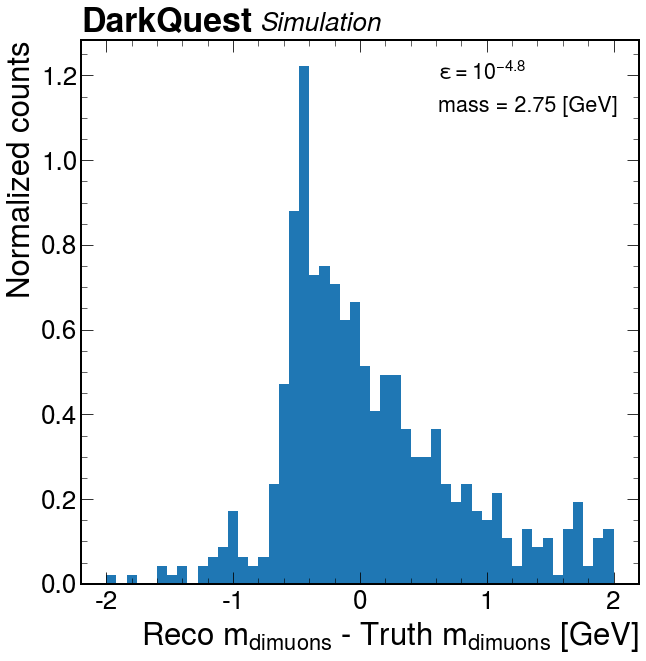

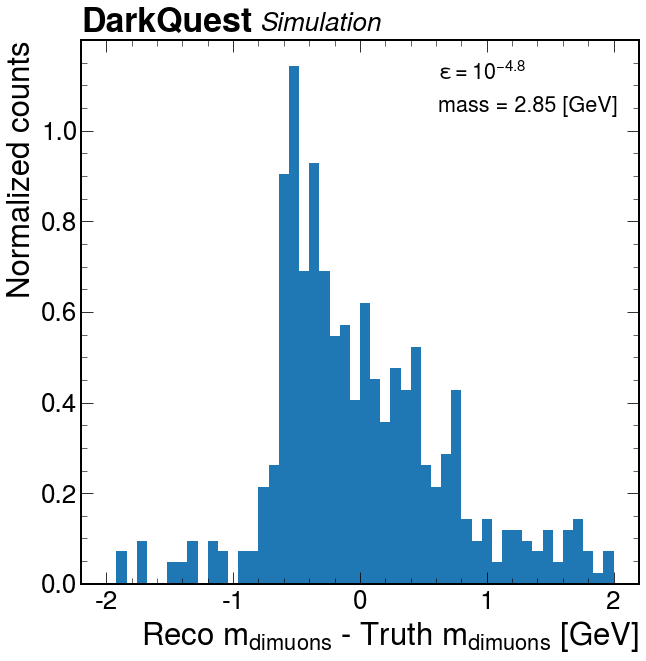

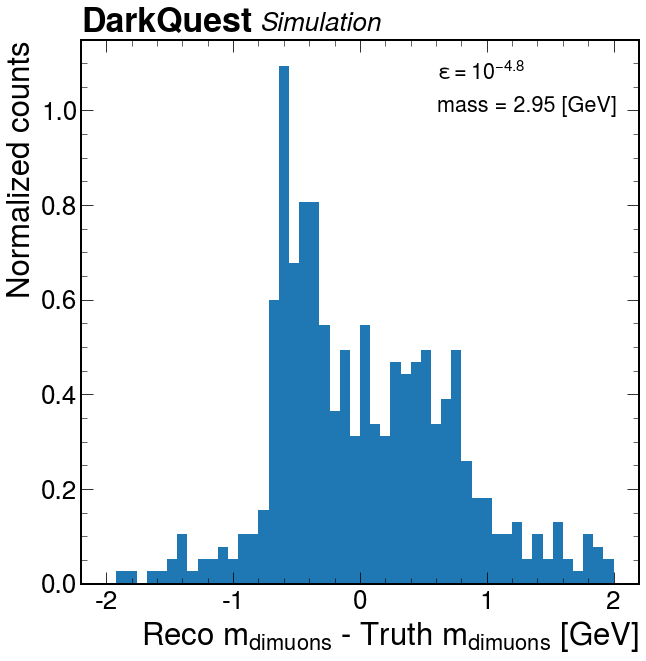

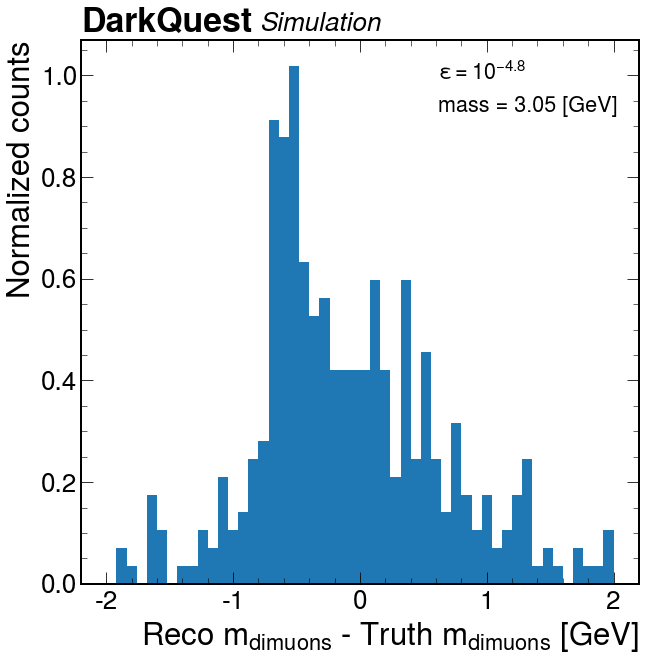

In [11]:
def plot_residual(dq_events, coupling, mass, plot_bins = 50, plot_range = (-2,2)):
    
    #Tracks selection
    reco_select = ak.count(dq_events["reco_dimuon"].mass, axis = 1) == 1
    
    truth_mass = np.asarray(ak.flatten(dq_events["truth_dimuon"].mass[reco_select]))
    reco_mass = np.asarray(ak.flatten(dq_events["reco_dimuon"].mass[reco_select]))
    truth_z = np.asarray(ak.flatten(dq_events["truth_dimuon"].z[reco_select]))
    
    nan_filter = (~np.isnan(reco_mass)) & (~np.isnan(truth_mass)) & (~np.isnan(truth_z))
    
    #filter nana
    truth_mass = truth_mass[nan_filter]
    reco_mass = reco_mass[nan_filter]
    truth_z = truth_z[nan_filter]
    
    #Calculate the residual
    residual = reco_mass - truth_mass
    
    #Plot the residual
    plt.hist(residual, bins = plot_bins, range = plot_range, density = True)
    plt.xlabel(r'Reco $m_{dimuons}$ - Truth $m_{dimuons}$ [GeV]')
    plt.ylabel('Normalized counts')
    
    plt.plot([],[], 'none', label=r"$\epsilon = 10^{%s}$"%coupling)
    plt.plot([],[], 'none', label=r'mass = {} [GeV]'.format(mass))
    
    hep.dq.text("Simulation") #Add "DarkQuest Simulation"
    plt.legend()
    plt.show()
    
    
    return np.asarray(residual), ak.mean(reco_mass)

def scan_coupling_mass(scan_dir):
    
    #Loop through different couplings
    for filename in os.listdir(scan_dir):
        if filename.endswith("_eps_-4.8.root"):
            
            #Parse some basic info
            Ap_config = filename[:-5].split('_') #Remove the .root part and split by '_'
            coupling = float(Ap_config[-1])
            mass = float(Ap_config[1])
            
            #Load the data
            dq_events = getData(os.path.join(scan_dir, filename), 'Events')

            #Plot the residual
            plot_residual(dq_events, coupling, mass)



scan_coupling_mass("/mnt/T2_US_MIT/hadoop/mitgroups/DarkQuest/dhoang/DCEM_Aprime_Muons_Scan_z200_600_21_04_2022/")

-----

array([0.6550159 , 0.43389446, 0.28822714, ..., 0.31877995, 0.19407803,
       0.26930434], dtype=float32)

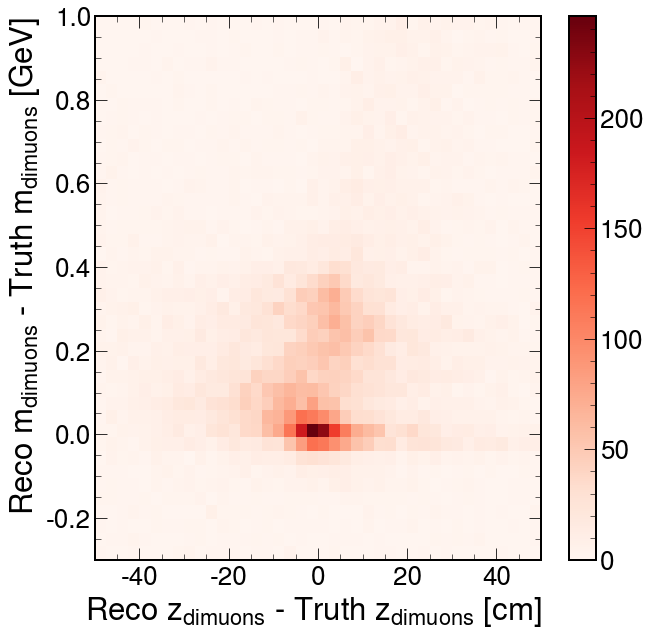

In [36]:
def reco_residual_mass_z(dq_events):
    
    #Tracks selection
    reco_select = ak.count(dq_events["reco_dimuon"].mass, axis = 1) == 1
    
    truth_mass = np.asarray(ak.flatten(dq_events["truth_dimuon"].mass[reco_select]))
    reco_mass = np.asarray(ak.flatten(dq_events["reco_dimuon"].mass[reco_select]))
    
    truth_z = np.asarray(ak.flatten(dq_events["truth_dimuon"].z[reco_select]))
    reco_z = np.asarray(ak.flatten(dq_events["reco_dimuon"].z[reco_select]))
    
    nan_filter = (~np.isnan(reco_mass)) &\
                (~np.isnan(truth_mass)) &\
                (~np.isnan(truth_z)) &\
                (~np.isnan(reco_z))
    
    #filter nana
    truth_mass = truth_mass[nan_filter]
    reco_mass = reco_mass[nan_filter]
    
    truth_z = truth_z[nan_filter]
    reco_z = reco_z[nan_filter]
    
    #Calculate the residual
    residual = reco_mass - truth_mass
    residual_z = reco_z - truth_z
    
    #Make 2D histogram
    plt.hist2d(residual_z, residual,
               bins = 40,
               range = [[-50,50],[-0.3,1]],
              cmap ='Reds')
    plt.colorbar()
    
    plt.ylabel(r'Reco $m_{dimuons}$ - Truth $m_{dimuons}$ [GeV]')
    plt.xlabel(r'Reco $z_{dimuons}$ - Truth $z_{dimuons}$ [cm]')
    
    return np.asarray(residual) 

reco_residual_mass_z(dq_events)

In [ ]:
def reco_find_residual(dq_events):
    
    
    #Tracks selection
    reco_select = ak.count(dq_events["reco_dimuon"].mass, axis = 1) == 1
    
    truth_z = ak.flatten(dq_events["truth_dimuon"].mass[reco_select])
    reco_mass = ak.flatten(dq_events["reco_dimuon"].mass[reco_select])
    reco_z = ak.flatten(dq_events["reco_dimuon"].z[reco_select])
    
    #filter nana
    truth_mass = truth_mass[~np.isnan(reco_mass)]
    reco_mass = reco_mass[~np.isnan(reco_mass)]
    reco_z = reco_z[~np.isnan(reco_mass)]
   
     #Reco outside of Fmag
    reco_z_select = reco_z < 520
    
    truth_mass = truth_mass[reco_z_select]
    reco_mass = reco_mass[reco_z_select]
    
    
    #Calculate the residual
    residual = reco_mass - truth_mass
    
    #print(np.mean(ak.flatten(reco_mass)))

    return np.asarray(residual), ak.mean(reco_mass)

def gaussian_fit(residual,
                 mean,
                 plot_bins = 50,
                 plot_range = (-0.6,0.6),
                 p_guess=[10, 0, 0.01],
                 residual_label = r'Reco $m_{dimuon}$ - Truth $m_{dimuon}$ [GeV]'):
    
    #Plot and fit
    plt.hist(residual,
         bins = plot_bins,
         range = plot_range,
         density = True)
    
    ## Gaussian fit
    ## Fit directly on the histogram
    def fit_function(x, A, mu, sig):
        return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    
    data_entries, _ = np.histogram(residual, bins=bins,
                                   range = plot_range,
                                   density = True)
    
    mask = data_entries!=0
    #Fit the function to the histogram data.
    popt, pcov = curve_fit(fit_function,
                           xdata=binscenters[mask],
                           ydata=data_entries[mask],
                           sigma = np.sqrt(data_entries[mask]),
                           absolute_sigma = False,
                           p0=p_guess)
    
    #Error for parameter estimations
    perr = np.sqrt(np.diag(pcov))
    print("Error for parameter esimations: ", perr)

    std_fit = np.abs(popt[2])
    mean_fit = popt[1]
    
    print("Standard deviation (fit) is", std_fit)
    print("Mean (fit) is", mean_fit)
    
    #Plot fitted gaussian
    plt.plot(bins,
             fit_function(bins, *popt),
             "r-",
             linewidth=4,
             label='Best fit')

    plt.plot([],[], 'none', label=r'$\mu=%.2f$ [GeV]'%popt[1])
    plt.plot([],[], 'none', label=r'$\sigma=%.4f$ [GeV]'%abs(popt[2]))
    plt.plot([],[], 'none', label=r'$<m>=%.2f$ [GeV]'%mean)
    plt.plot([],[], 'none', label=r'$\sigma/<m>=%.4f$'%(abs(popt[2])/mean))
    
    #Label the axes
    plt.xlabel(residual_label)
    plt.ylabel('Normalized counts')

    plt.legend()

def plot_mass_resolution(dq_events):
    
    m_residual, m_mean = reco_find_residual(dq_events)
    
    gaussian_fit(m_residual, m_mean)
    
plot_mass_resolution(dq_events)
plt.savefig(save_path+"DP_mass_res.pdf", bbox_inches='tight')
plt.show()

--------

## Vertex resolution

Error for parameter esimations:  [0.00265033 0.31780063 0.30492123]
Standard deviation (fit) is 7.552421042087194
Mean (fit) is 1.9122391504421372


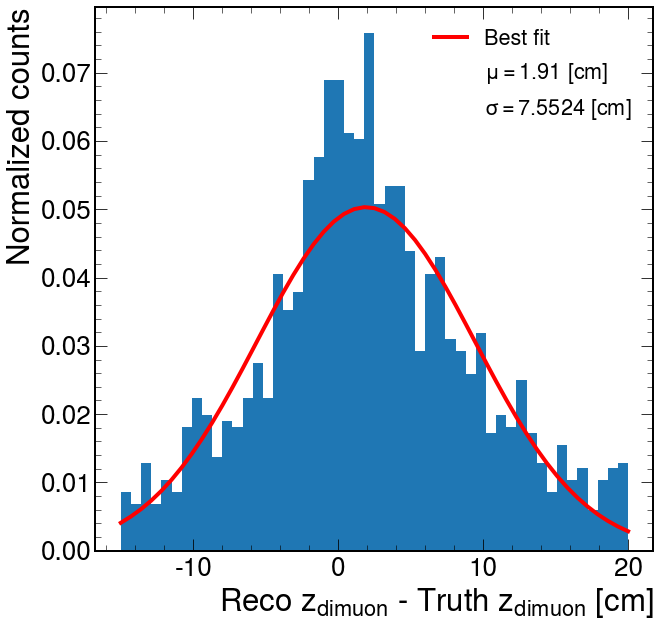

In [32]:
def reco_find_residual(dq_events):
    
    
    #Tracks selection
    reco_select = ak.count(dq_events["reco_dimuon"].z, axis = 1) == 1
    
    truth_z = ak.flatten(dq_events["truth_dimuon"].z[reco_select])
    reco_z = ak.flatten(dq_events["reco_dimuon"].z[reco_select])
    
    #filter nana
    truth_z = truth_z[~np.isnan(reco_z)]
    reco_z = reco_z[~np.isnan(reco_z)]
   
    #Calculate the residual
    residual = reco_z - truth_z
    
    #print(np.mean(ak.flatten(reco_mass)))

    return np.asarray(residual), ak.mean(reco_z)

def gaussian_fit(residual,
                 mean,
                 plot_bins = 50,
                 plot_range = (-15, 20),
                 p_guess=[0.05, 0, 10],
                 residual_label = r'Reco $z_{dimuon}$ - Truth $z_{dimuon}$ [cm]'):
    
    #Plot and fit
    plt.hist(residual,
         bins = plot_bins,
         range = plot_range,
         density = True)
    
    ## Gaussian fit
    ## Fit directly on the histogram
    def fit_function(x, A, mu, sig):
        return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    
    data_entries, _ = np.histogram(residual, bins=bins,
                                   range = plot_range,
                                   density = True)
    
    mask = data_entries!=0
    #Fit the function to the histogram data.
    popt, pcov = curve_fit(fit_function,
                           xdata=binscenters[mask],
                           ydata=data_entries[mask],
                           sigma = np.sqrt(data_entries[mask]),
                           absolute_sigma = False,
                           p0=p_guess)
    
    #Error for parameter estimations
    perr = np.sqrt(np.diag(pcov))
    print("Error for parameter esimations: ", perr)

    std_fit = np.abs(popt[2])
    mean_fit = popt[1]
    
    print("Standard deviation (fit) is", std_fit)
    print("Mean (fit) is", mean_fit)
    
    #Plot fitted gaussian
    plt.plot(bins,
             fit_function(bins, *popt),
             "r-",
             linewidth=4,
             label='Best fit')

    plt.plot([],[], 'none', label=r'$\mu=%.2f$ [cm]'%popt[1])
    plt.plot([],[], 'none', label=r'$\sigma=%.4f$ [cm]'%abs(popt[2]))
    #plt.plot([],[], 'none', label=r'$<m>=%.2f$ [GeV]'%mean)
    #plt.plot([],[], 'none', label=r'$\sigma/<m>=%.4f$'%(abs(popt[2])/mean))
    
    #Label the axes
    plt.xlabel(residual_label)
    plt.ylabel('Normalized counts')

    plt.legend()

def plot_mass_resolution(dq_events):
    
    z_residual, z_mean = reco_find_residual(dq_events)
    gaussian_fit(z_residual, z_mean)
    
plot_mass_resolution(dq_events)
plt.savefig(save_path+"DP_z_res.pdf", bbox_inches='tight')
plt.show()

Error for parameter esimations:  [0.07258835 0.01629308 0.01397133]
Standard deviation (fit) is 0.3252449380016363
Mean (fit) is 0.09866174844913451


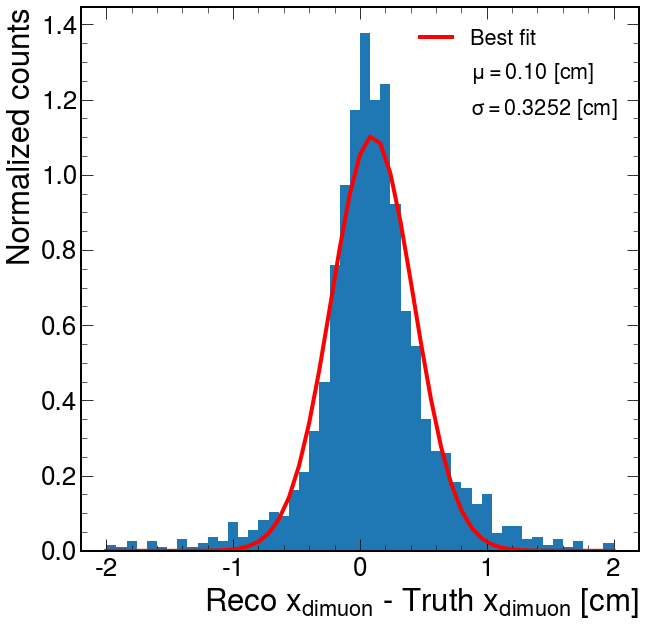

In [37]:
def reco_find_residual(dq_events):
    
    
    #Tracks selection
    reco_select = ak.count(dq_events["reco_dimuon"].x, axis = 1) == 1
    
    truth_x = ak.flatten(dq_events["truth_dimuon"].x[reco_select])
    reco_x = ak.flatten(dq_events["reco_dimuon"].x[reco_select])
    
    #filter nana
    truth_x = truth_x[~np.isnan(reco_x)]
    reco_x = reco_x[~np.isnan(reco_x)]
   
    #Calculate the residual
    residual = reco_x - truth_x
    
    #print(np.mean(ak.flatten(reco_mass)))

    return np.asarray(residual), ak.mean(reco_x)

def gaussian_fit(residual,
                 mean,
                 plot_bins = 50,
                 plot_range = (-2, 2),
                 p_guess=[0.05, 0, 10],
                 residual_label = r'Reco $x_{dimuon}$ - Truth $x_{dimuon}$ [cm]'):
    
    #Plot and fit
    plt.hist(residual,
         bins = plot_bins,
         range = plot_range,
         density = True)
    
    ## Gaussian fit
    ## Fit directly on the histogram
    def fit_function(x, A, mu, sig):
        return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    
    data_entries, _ = np.histogram(residual, bins=bins,
                                   range = plot_range,
                                   density = True)
    
    mask = data_entries!=0
    #Fit the function to the histogram data.
    popt, pcov = curve_fit(fit_function,
                           xdata=binscenters[mask],
                           ydata=data_entries[mask],
                           sigma = np.sqrt(data_entries[mask]),
                           absolute_sigma = False,
                           p0=p_guess)
    
    #Error for parameter estimations
    perr = np.sqrt(np.diag(pcov))
    print("Error for parameter esimations: ", perr)

    std_fit = np.abs(popt[2])
    mean_fit = popt[1]
    
    print("Standard deviation (fit) is", std_fit)
    print("Mean (fit) is", mean_fit)
    
    #Plot fitted gaussian
    plt.plot(bins,
             fit_function(bins, *popt),
             "r-",
             linewidth=4,
             label='Best fit')

    plt.plot([],[], 'none', label=r'$\mu=%.2f$ [cm]'%popt[1])
    plt.plot([],[], 'none', label=r'$\sigma=%.4f$ [cm]'%abs(popt[2]))
    #plt.plot([],[], 'none', label=r'$<m>=%.2f$ [GeV]'%mean)
    #plt.plot([],[], 'none', label=r'$\sigma/<m>=%.4f$'%(abs(popt[2])/mean))
    
    #Label the axes
    plt.xlabel(residual_label)
    plt.ylabel('Normalized counts')

    plt.legend()

def plot_mass_resolution(dq_events):
    
    x_residual, x_mean = reco_find_residual(dq_events)
    gaussian_fit(x_residual, x_mean)
    
plot_mass_resolution(dq_events)
plt.savefig(save_path+"DP_x_res.pdf", bbox_inches='tight')
plt.show()

Error for parameter esimations:  [0.01727674 0.02842187 0.02344707]
Standard deviation (fit) is 0.8893868698248905
Mean (fit) is -0.3522145806221409


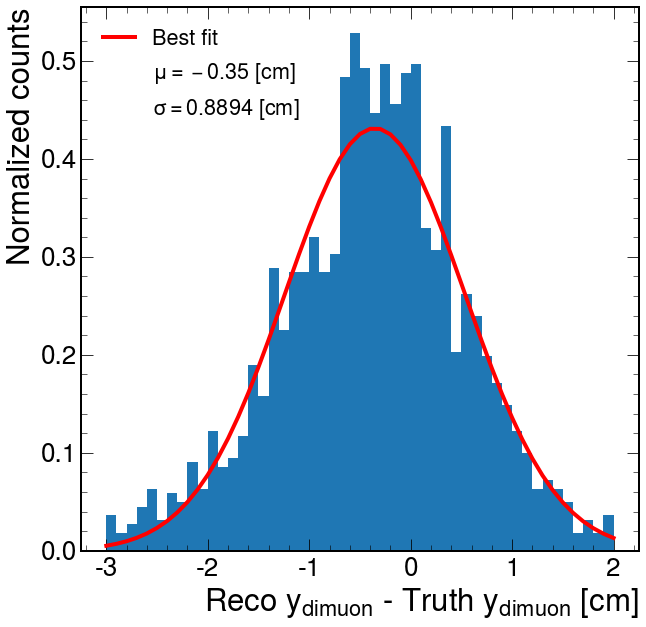

In [39]:
def reco_find_residual(dq_events):
    
    
    #Tracks selection
    reco_select = ak.count(dq_events["reco_dimuon"].y, axis = 1) == 1
    
    truth_y = ak.flatten(dq_events["truth_dimuon"].y[reco_select])
    reco_y = ak.flatten(dq_events["reco_dimuon"].y[reco_select])
    
    #filter nana
    truth_y = truth_y[~np.isnan(reco_y)]
    reco_y = reco_y[~np.isnan(reco_y)]
   
    #Calculate the residual
    residual = reco_y - truth_y
    
    #print(np.mean(ak.flatten(reco_mass)))

    return np.asarray(residual), ak.mean(reco_y)

def gaussian_fit(residual,
                 mean,
                 plot_bins = 50,
                 plot_range = (-3, 2),
                 p_guess=[0.05, 0, 10],
                 residual_label = r'Reco $y_{dimuon}$ - Truth $y_{dimuon}$ [cm]'):
    
    #Plot and fit
    plt.hist(residual,
         bins = plot_bins,
         range = plot_range,
         density = True)
    
    ## Gaussian fit
    ## Fit directly on the histogram
    def fit_function(x, A, mu, sig):
        return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    
    data_entries, _ = np.histogram(residual, bins=bins,
                                   range = plot_range,
                                   density = True)
    
    mask = data_entries!=0
    #Fit the function to the histogram data.
    popt, pcov = curve_fit(fit_function,
                           xdata=binscenters[mask],
                           ydata=data_entries[mask],
                           sigma = np.sqrt(data_entries[mask]),
                           absolute_sigma = False,
                           p0=p_guess)
    
    #Error for parameter estimations
    perr = np.sqrt(np.diag(pcov))
    print("Error for parameter esimations: ", perr)

    std_fit = np.abs(popt[2])
    mean_fit = popt[1]
    
    print("Standard deviation (fit) is", std_fit)
    print("Mean (fit) is", mean_fit)
    
    #Plot fitted gaussian
    plt.plot(bins,
             fit_function(bins, *popt),
             "r-",
             linewidth=4,
             label='Best fit')

    plt.plot([],[], 'none', label=r'$\mu=%.2f$ [cm]'%popt[1])
    plt.plot([],[], 'none', label=r'$\sigma=%.4f$ [cm]'%abs(popt[2]))
    #plt.plot([],[], 'none', label=r'$<m>=%.2f$ [GeV]'%mean)
    #plt.plot([],[], 'none', label=r'$\sigma/<m>=%.4f$'%(abs(popt[2])/mean))
    
    #Label the axes
    plt.xlabel(residual_label)
    plt.ylabel('Normalized counts')

    plt.legend()

def plot_mass_resolution(dq_events):
    
    y_residual, y_mean = reco_find_residual(dq_events)
    gaussian_fit(y_residual, y_mean)
    
plot_mass_resolution(dq_events)
plt.savefig(save_path+"DP_y_res.pdf", bbox_inches='tight')
plt.show()

## Resolution vesus mass

Error for parameter esimations:  [1.72370268e+00 1.18097471e-03 8.46003046e-04]
Standard deviation (fit) is 0.017720817217527742
Mean (fit) is 0.007705742883058547


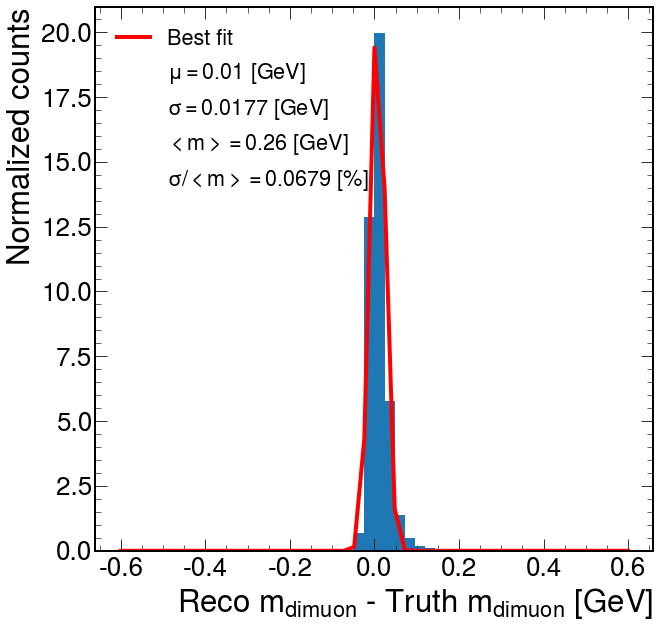

Error for parameter esimations:  [1.11752206 0.00265623 0.00226343]
Standard deviation (fit) is 0.03347025891070325
Mean (fit) is 0.006475346416392697


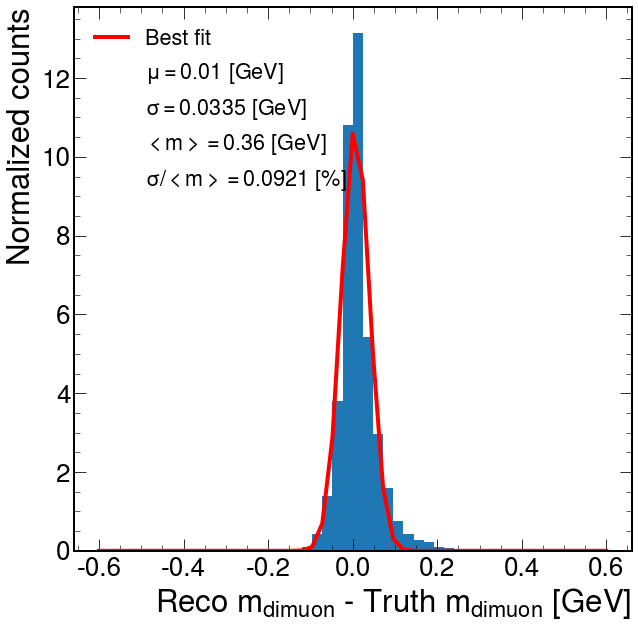

Error for parameter esimations:  [0.88000012 0.00287869 0.00251145]
Standard deviation (fit) is 0.038789516091724104
Mean (fit) is 0.006499925869644095


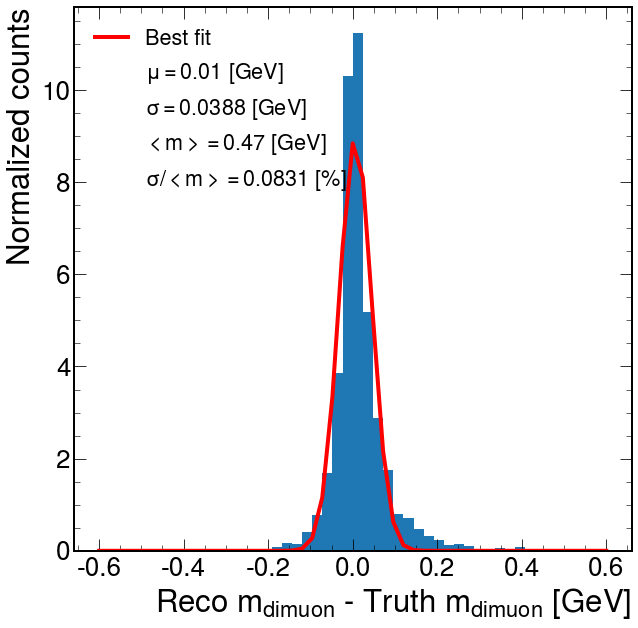

Error for parameter esimations:  [0.85129815 0.00298272 0.00260364]
Standard deviation (fit) is 0.0398349530028885
Mean (fit) is 0.005124941498214125


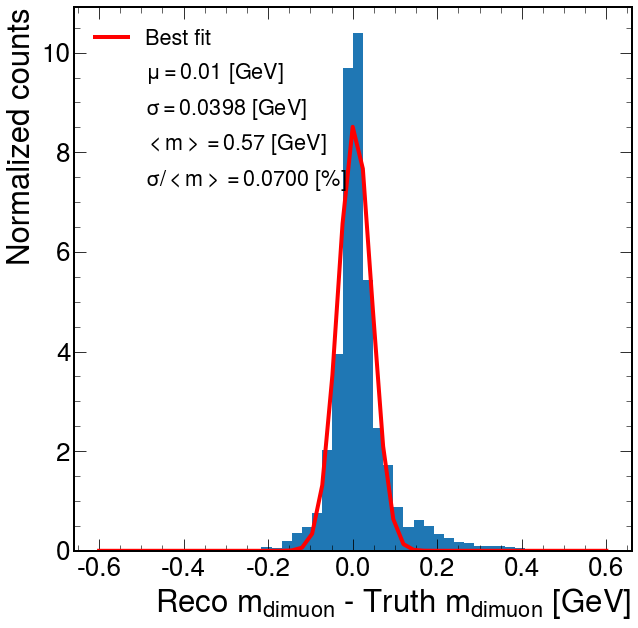

Error for parameter esimations:  [0.81883621 0.00324363 0.00290115]
Standard deviation (fit) is 0.041842160907463254
Mean (fit) is 0.0036073274482012604


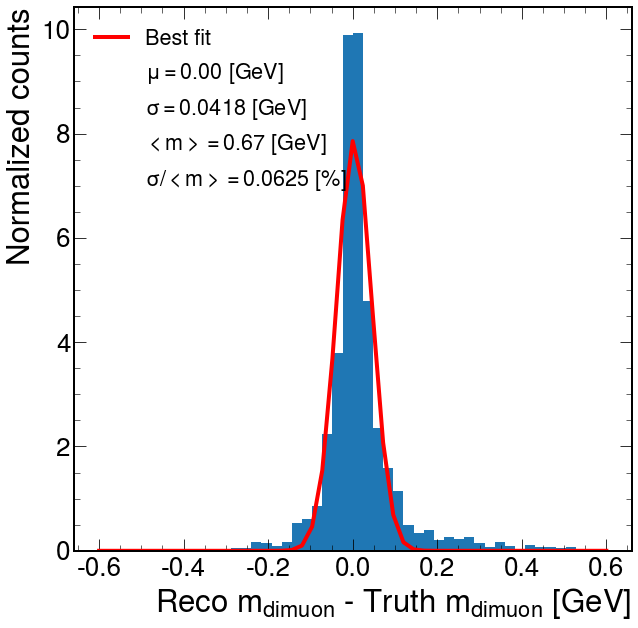

Error for parameter esimations:  [0.67193331 0.00316445 0.00277324]
Standard deviation (fit) is 0.0457635265831814
Mean (fit) is 0.0026639874726386136


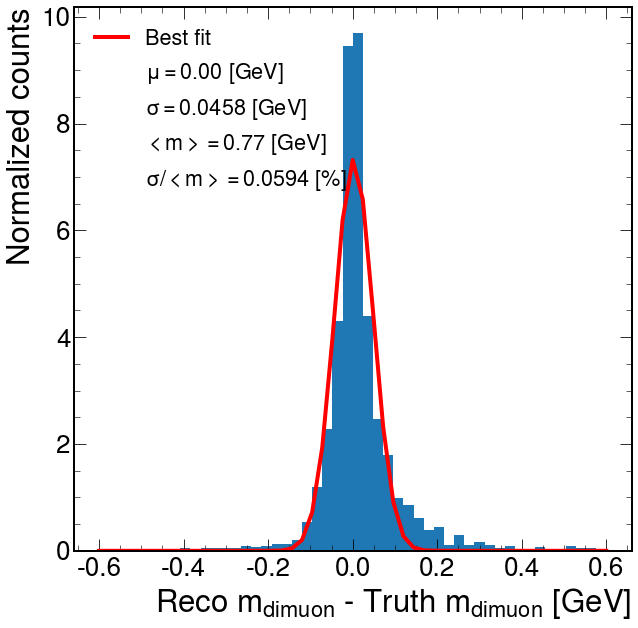

Error for parameter esimations:  [0.75891723 0.0027892  0.00243642]
Standard deviation (fit) is 0.04061709341824869
Mean (fit) is 0.003613184587889365


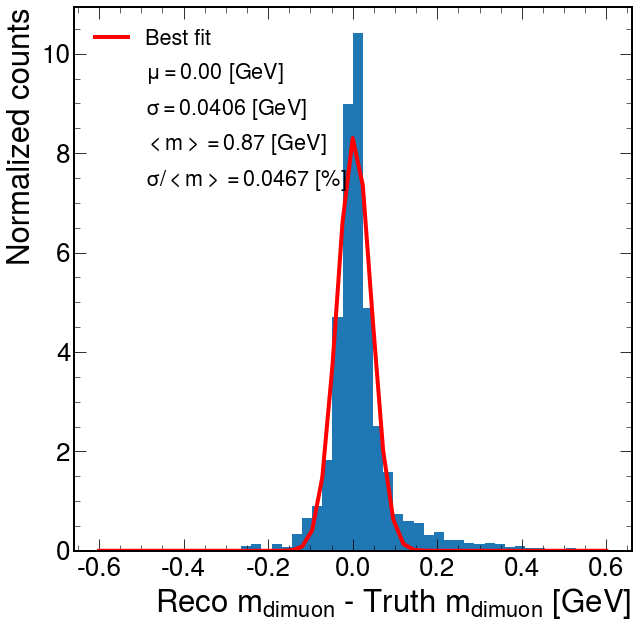

Error for parameter esimations:  [0.67606229 0.00296355 0.00256972]
Standard deviation (fit) is 0.04431018389895947
Mean (fit) is 0.001176184568099605


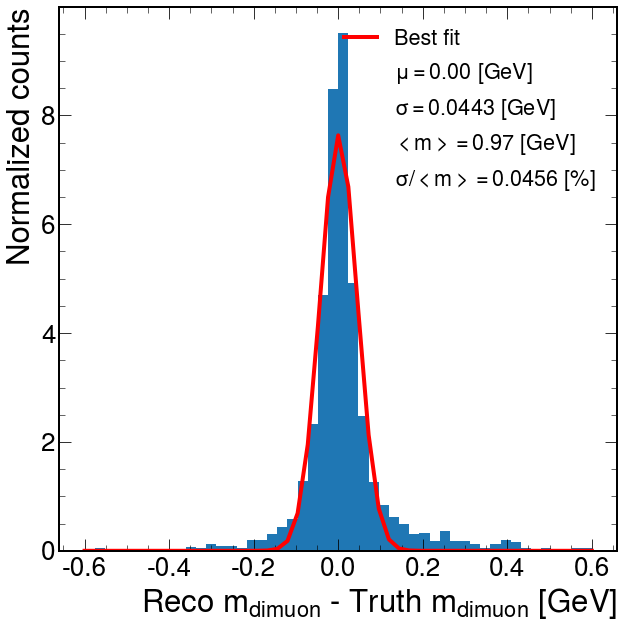

Error for parameter esimations:  [0.69193355 0.00274285 0.00231928]
Standard deviation (fit) is 0.04225068171519848
Mean (fit) is 0.0034753335523995976


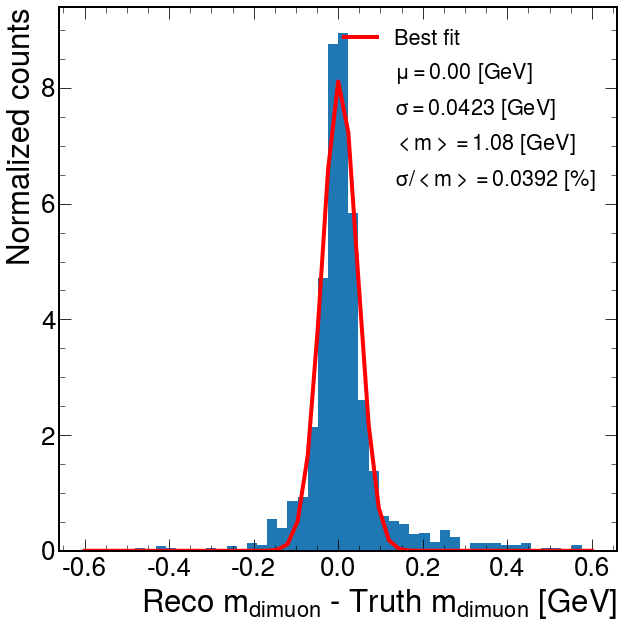

Error for parameter esimations:  [0.65114937 0.00318675 0.00280427]
Standard deviation (fit) is 0.04651135509405874
Mean (fit) is 0.0040467369647997345


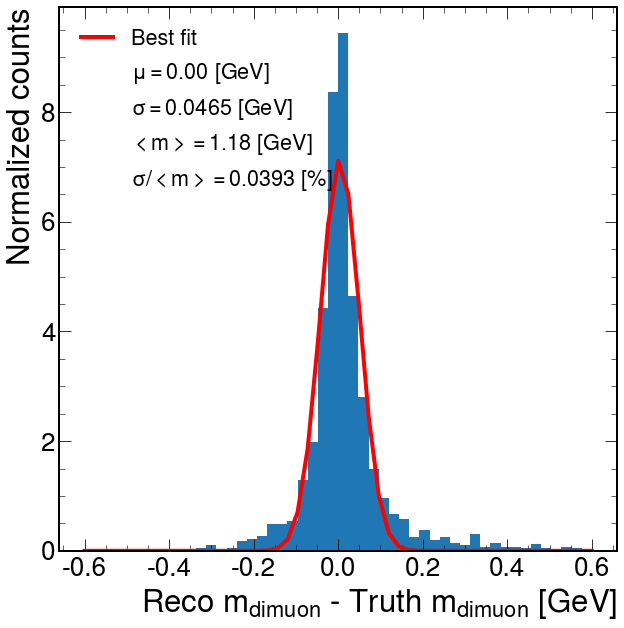

Error for parameter esimations:  [0.70543615 0.0029279  0.00255289]
Standard deviation (fit) is 0.043254378873277294
Mean (fit) is 0.0031783564757554917


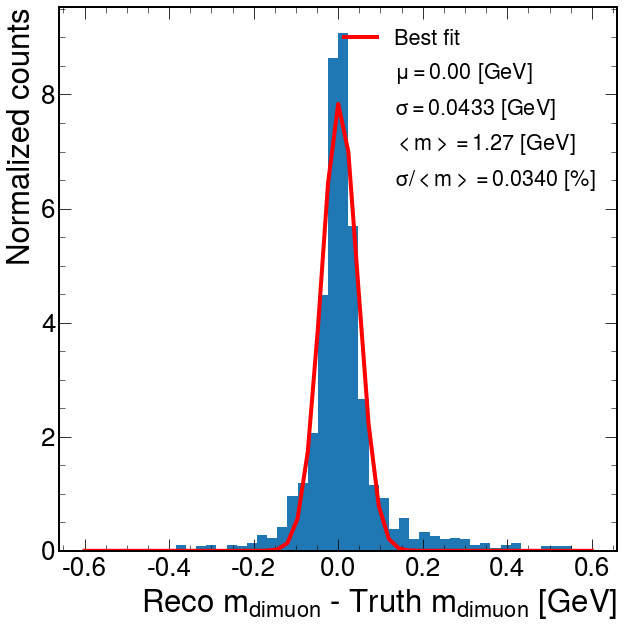

Error for parameter esimations:  [0.67349127 0.00328516 0.0029003 ]
Standard deviation (fit) is 0.04698089831776086
Mean (fit) is 0.002976597798010668


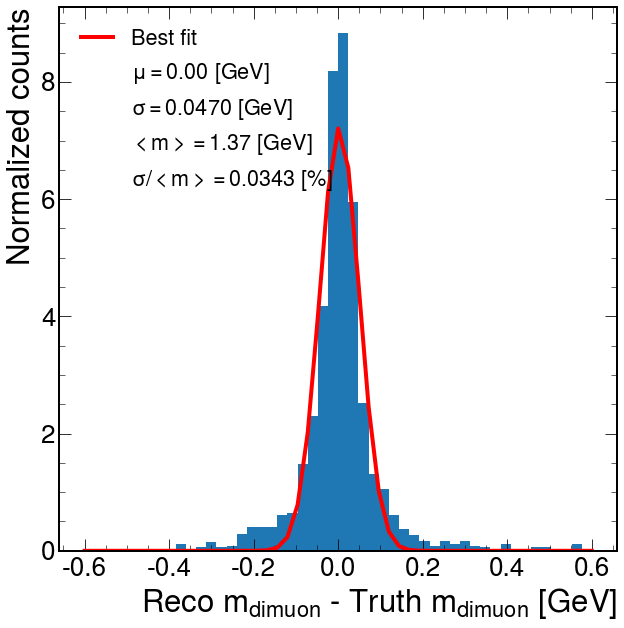

Error for parameter esimations:  [0.60294478 0.00370071 0.00327861]
Standard deviation (fit) is 0.05244827758768919
Mean (fit) is 0.0021657231913167316


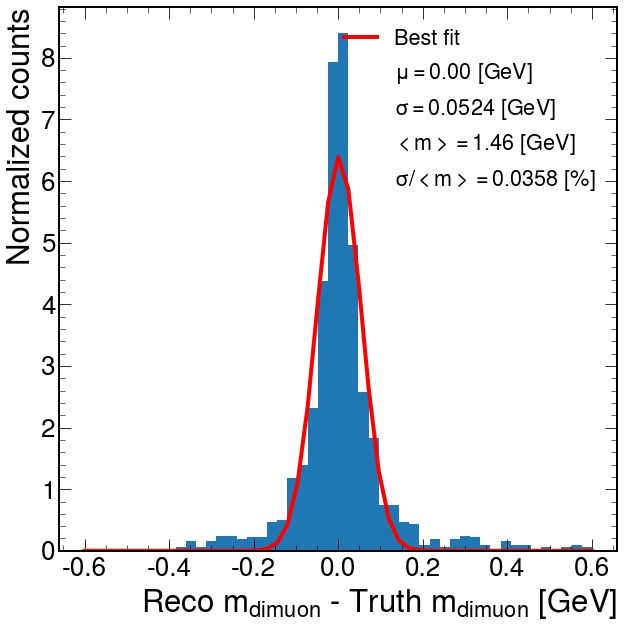

Error for parameter esimations:  [0.47354569 0.00263576 0.00214455]
Standard deviation (fit) is 0.05063560003627553
Mean (fit) is 0.0013472189330967956


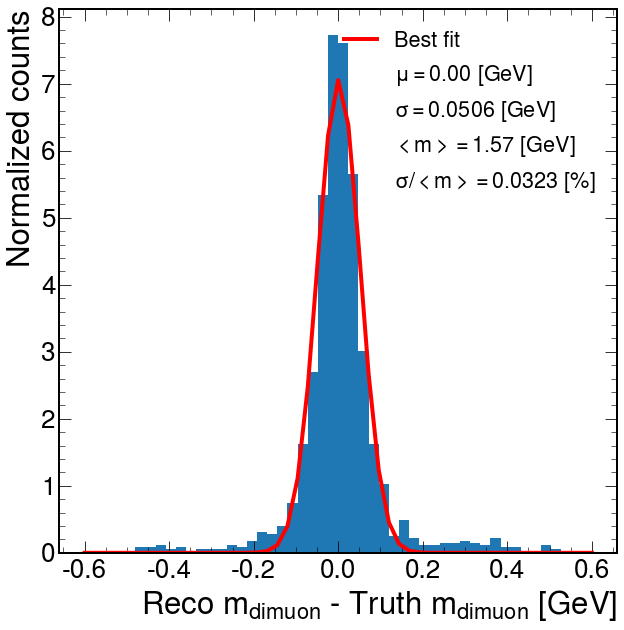

Error for parameter esimations:  [0.49493585 0.00283345 0.0023876 ]
Standard deviation (fit) is 0.051237969174837875
Mean (fit) is -0.0007248650453862611


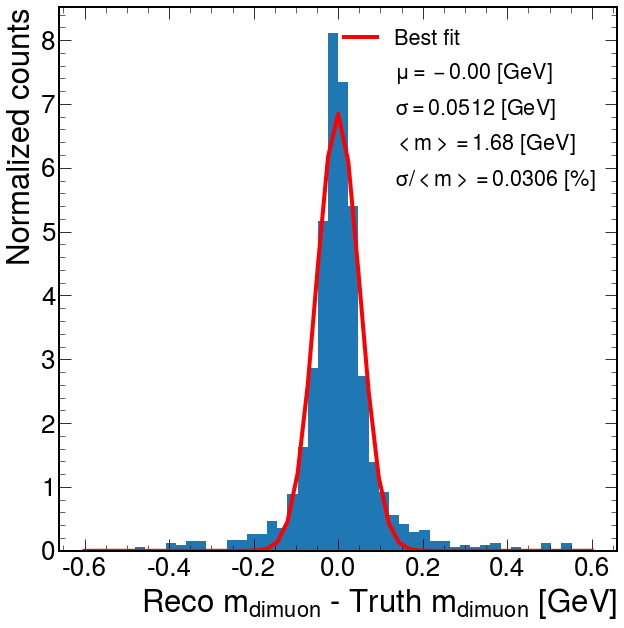

Error for parameter esimations:  [0.43518279 0.00294396 0.00246642]
Standard deviation (fit) is 0.05646718204231966
Mean (fit) is 0.004536270453831287


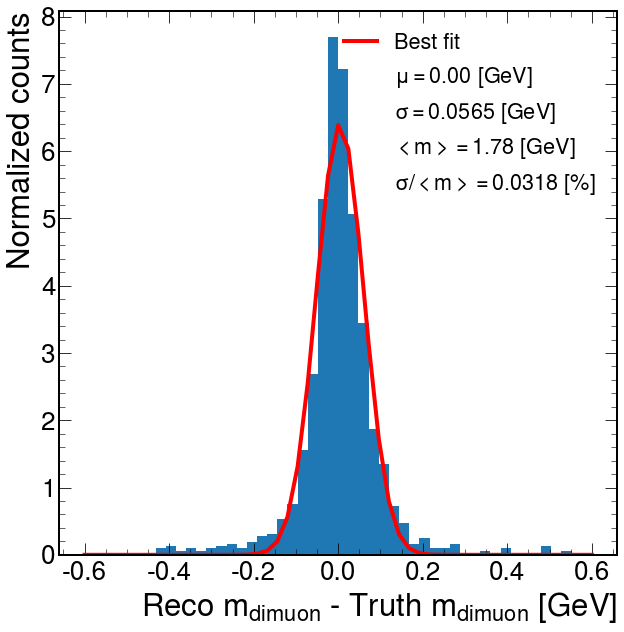

Error for parameter esimations:  [0.46284636 0.00289455 0.00241993]
Standard deviation (fit) is 0.054295165624974176
Mean (fit) is 0.0003892193541170436


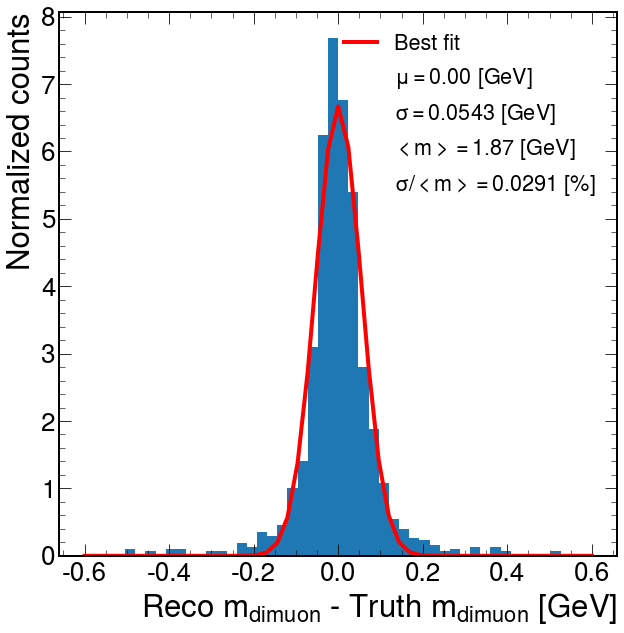

Error for parameter esimations:  [0.422441   0.00273413 0.00224743]
Standard deviation (fit) is 0.055222420394034195
Mean (fit) is 0.002087888847189858


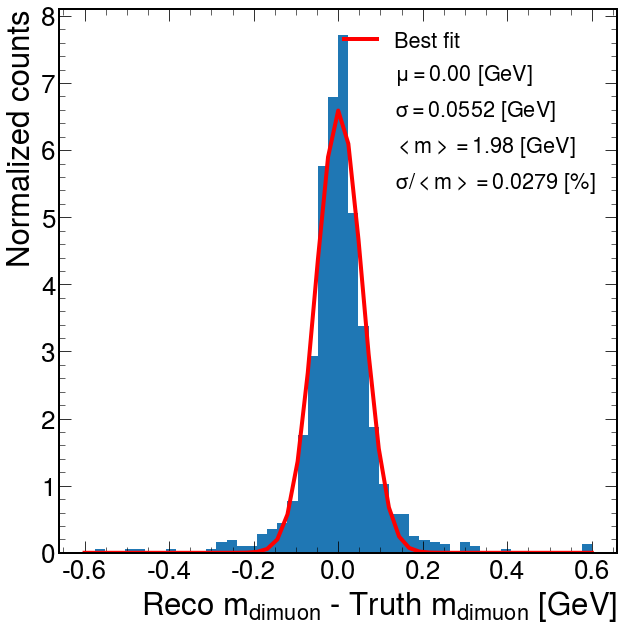

Error for parameter esimations:  [0.41592796 0.00281563 0.00232314]
Standard deviation (fit) is 0.056528602875874794
Mean (fit) is 0.0032045122884392565


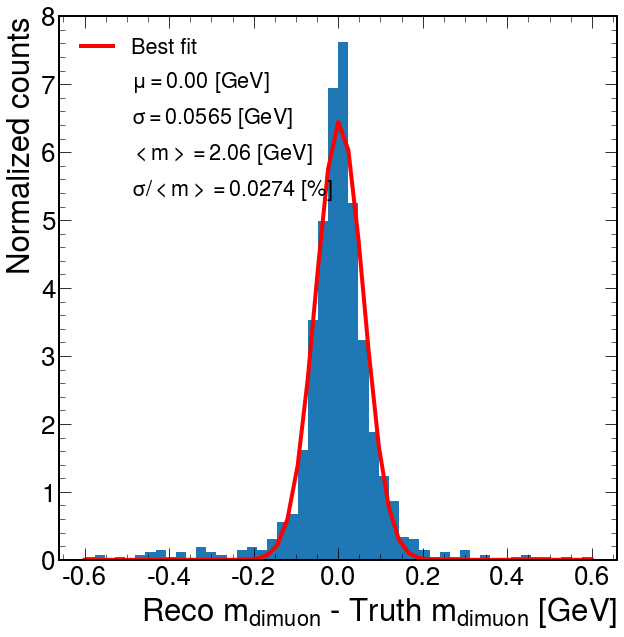

Error for parameter esimations:  [0.41772827 0.00342062 0.00289064]
Standard deviation (fit) is 0.061780238261468584
Mean (fit) is -0.00025132697709209133


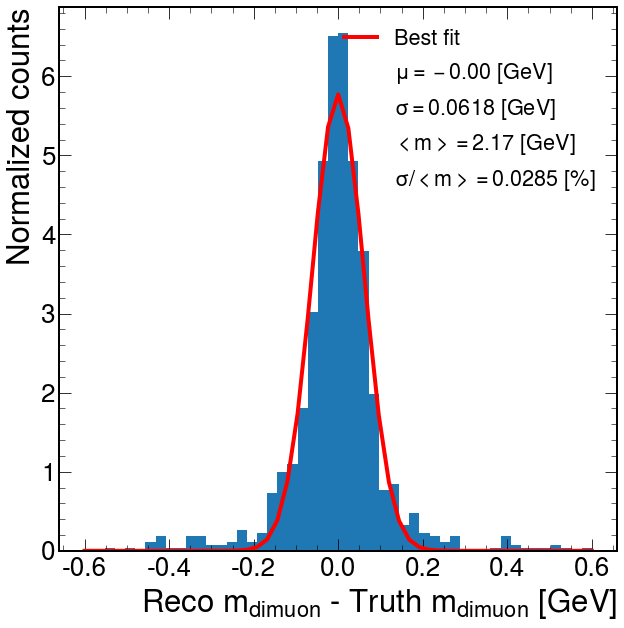

Error for parameter esimations:  [0.38904462 0.00317649 0.00266284]
Standard deviation (fit) is 0.06194009000145106
Mean (fit) is 0.0025974591930349143


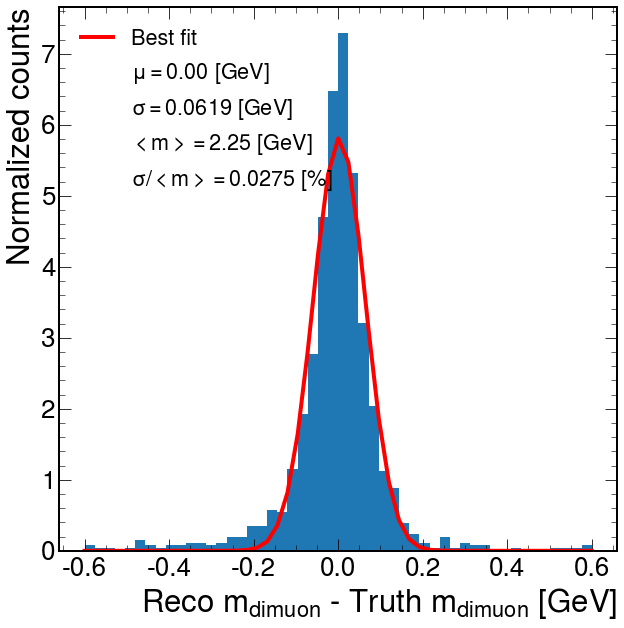

Error for parameter esimations:  [0.38730133 0.00286986 0.002334  ]
Standard deviation (fit) is 0.0592031174493499
Mean (fit) is 0.005757375459743188


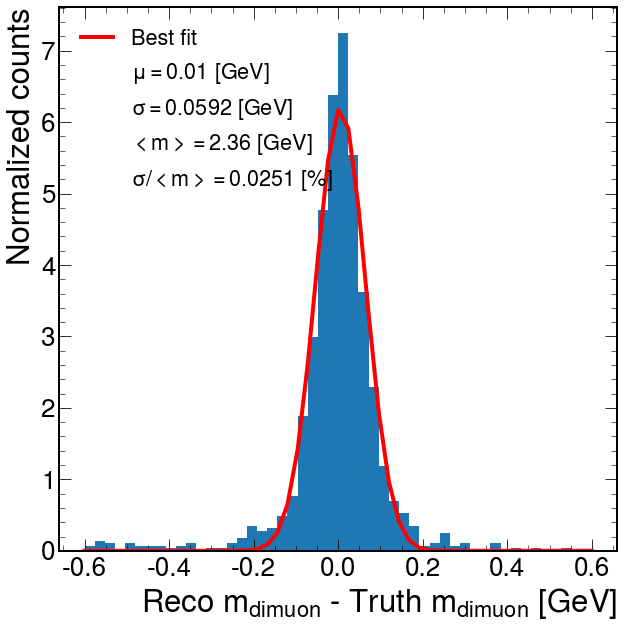

Error for parameter esimations:  [0.34452843 0.00274887 0.00215055]
Standard deviation (fit) is 0.06143625266343765
Mean (fit) is 0.0029394583790248105


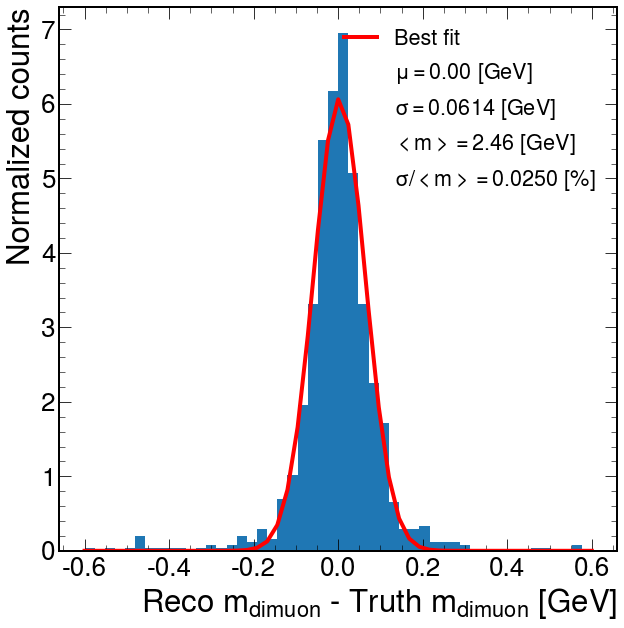

Error for parameter esimations:  [0.38068239 0.00320334 0.0026526 ]
Standard deviation (fit) is 0.06314776845290136
Mean (fit) is 0.001473602877411034


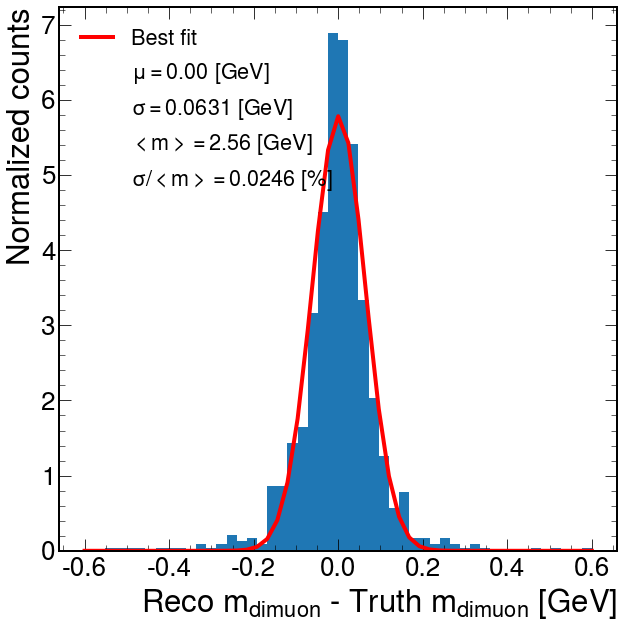

Error for parameter esimations:  [0.34730274 0.00326023 0.00264108]
Standard deviation (fit) is 0.06661070378274278
Mean (fit) is -0.0004560884485740039


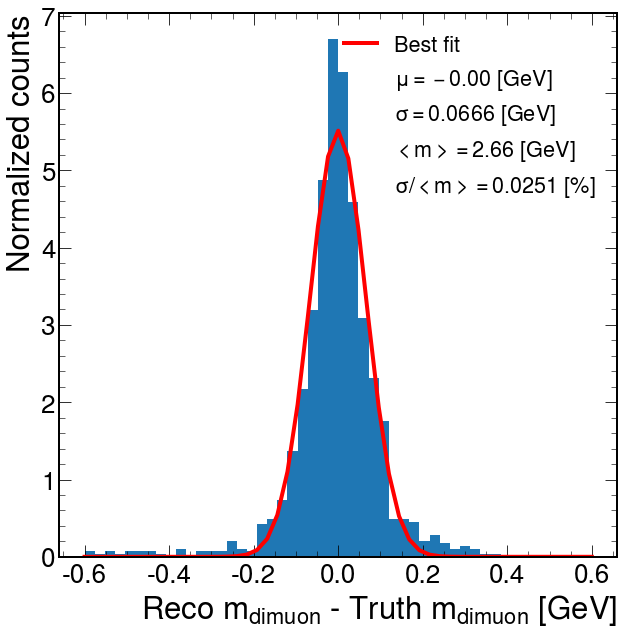

Error for parameter esimations:  [0.36467548 0.00316215 0.00259276]
Standard deviation (fit) is 0.06405302964069148
Mean (fit) is 0.00035937443511496904


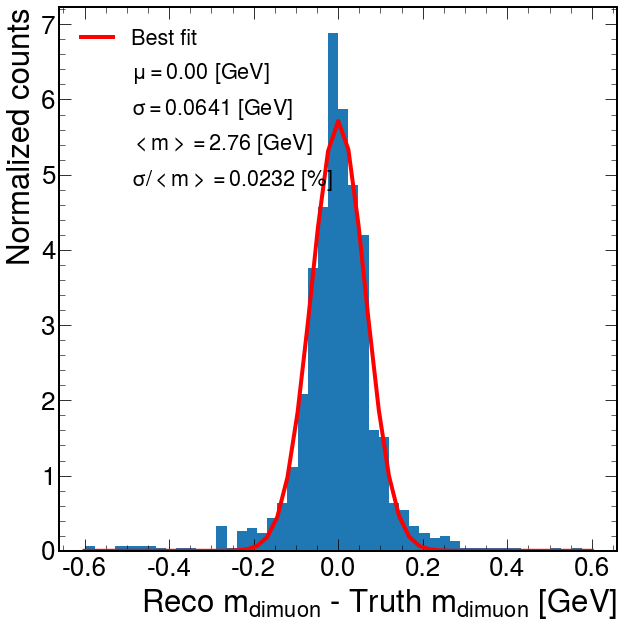

Error for parameter esimations:  [0.30565097 0.0028568  0.00217544]
Standard deviation (fit) is 0.06650804242758633
Mean (fit) is 0.0012925210045406246


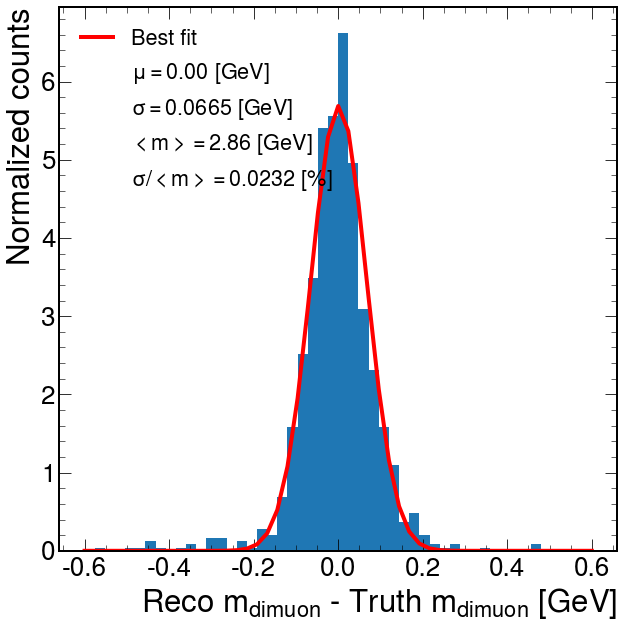

Error for parameter esimations:  [0.28145851 0.00322153 0.00252327]
Standard deviation (fit) is 0.07365822503356927
Mean (fit) is 0.000336158104019073


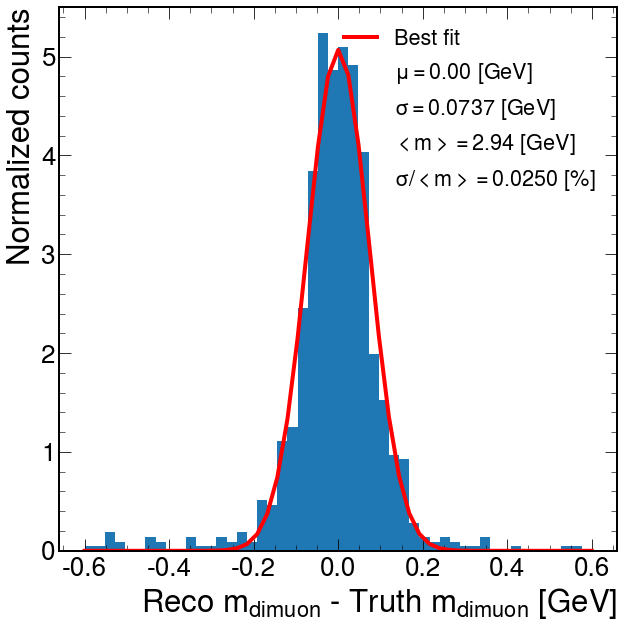

Error for parameter esimations:  [0.27451771 0.00273744 0.00203831]
Standard deviation (fit) is 0.0684677338828662
Mean (fit) is -0.002597616384713118


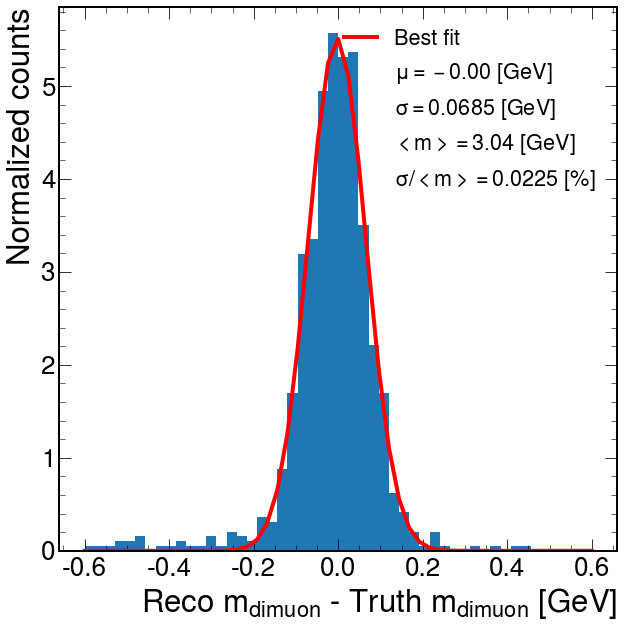

Error for parameter esimations:  [1.50407181 0.00471875 0.00396484]
Standard deviation (fit) is 0.03508649728115596
Mean (fit) is 0.024868340485293405


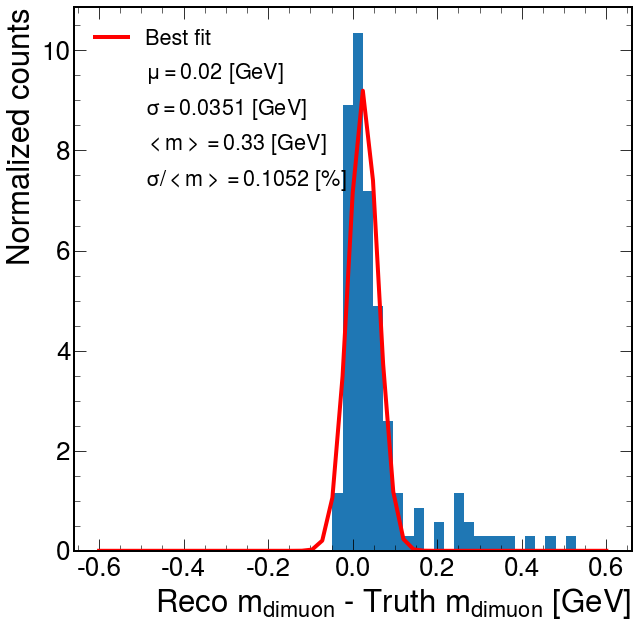

Error for parameter esimations:  [0.58958217 0.0068925  0.00572458]
Standard deviation (fit) is 0.06880573699666283
Mean (fit) is 0.014125255087856668


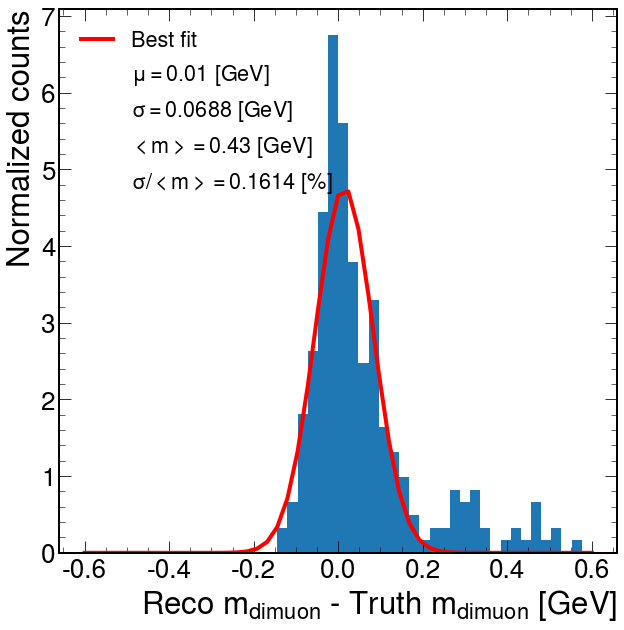

Error for parameter esimations:  [0.33368143 0.00741884 0.00668644]
Standard deviation (fit) is 0.10033346406292971
Mean (fit) is 0.011611487913135059


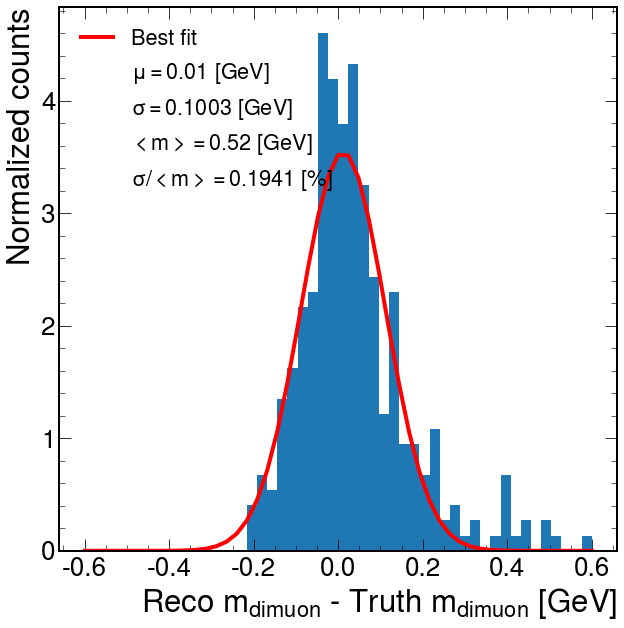

Error for parameter esimations:  [0.33256947 0.01116548 0.01078505]
Standard deviation (fit) is 0.1196206434464835
Mean (fit) is 0.0029120495112256754


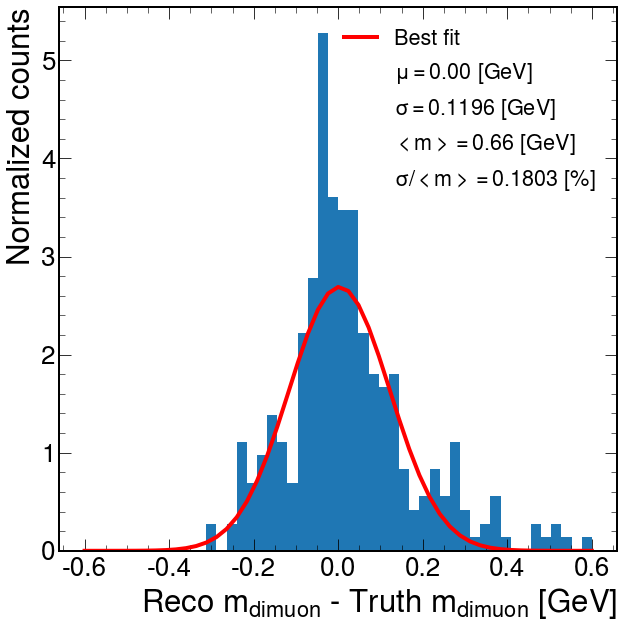

Error for parameter esimations:  [0.37076272 0.00753129 0.00631603]
Standard deviation (fit) is 0.09205992751776453
Mean (fit) is -0.012573550340892229


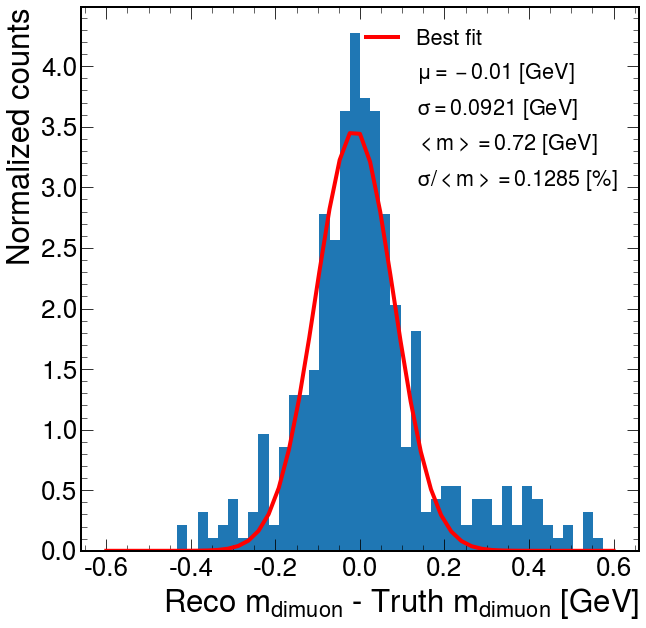

Error for parameter esimations:  [0.25423851 0.01144147 0.0105391 ]
Standard deviation (fit) is 0.13780120290660772
Mean (fit) is -0.019057794969573414


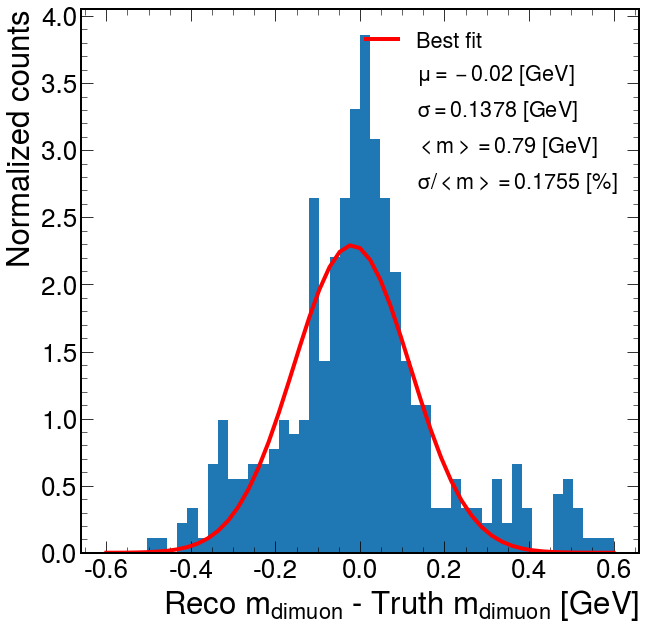

Error for parameter esimations:  [0.23714283 0.01046932 0.00977063]
Standard deviation (fit) is 0.1386197721285482
Mean (fit) is -0.016559778762887088


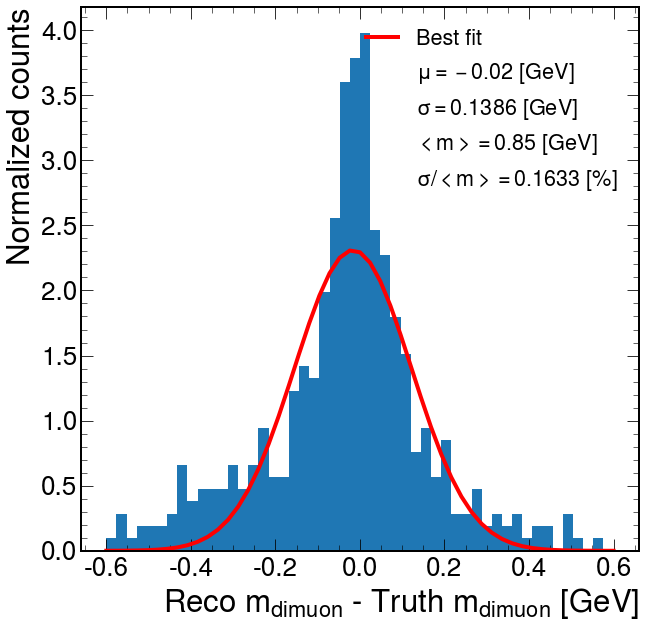

Error for parameter esimations:  [0.29428638 0.00847417 0.00712526]
Standard deviation (fit) is 0.10915783781483972
Mean (fit) is -0.024510403681386284


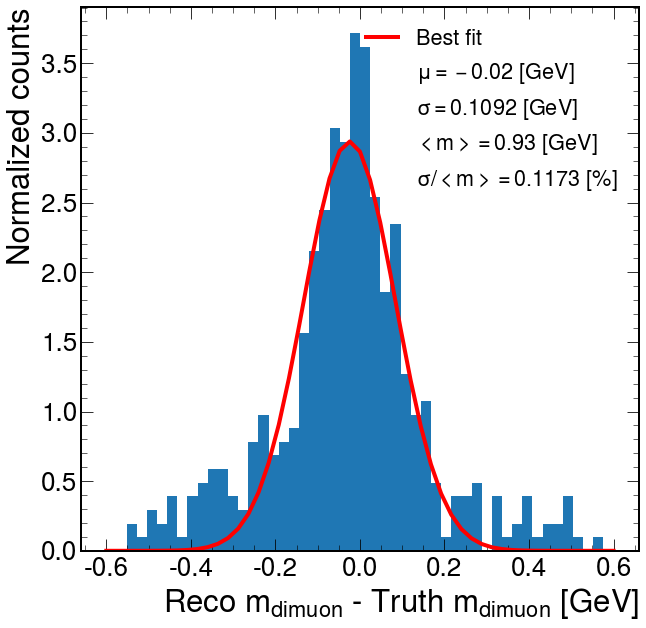

Error for parameter esimations:  [0.23668504 0.01240816 0.01145699]
Standard deviation (fit) is 0.14649450169851283
Mean (fit) is -0.01791316567452446


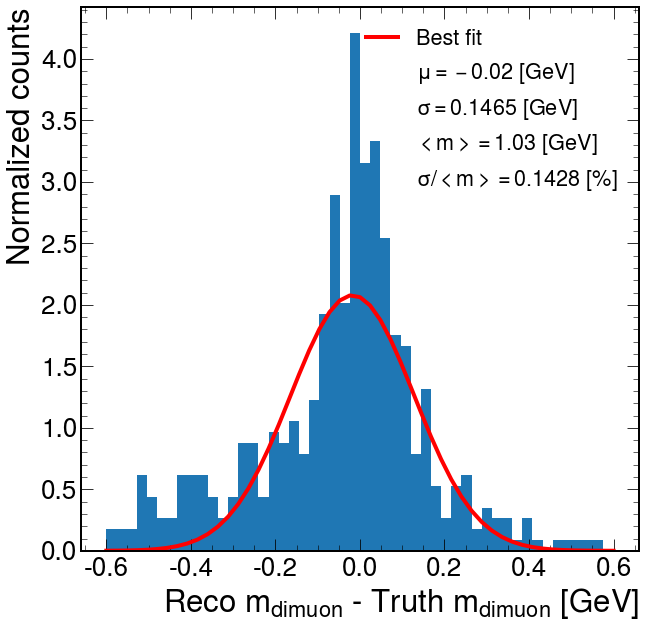

Error for parameter esimations:  [0.19061101 0.01323984 0.01193483]
Standard deviation (fit) is 0.17079966017541723
Mean (fit) is -0.01825271750790956


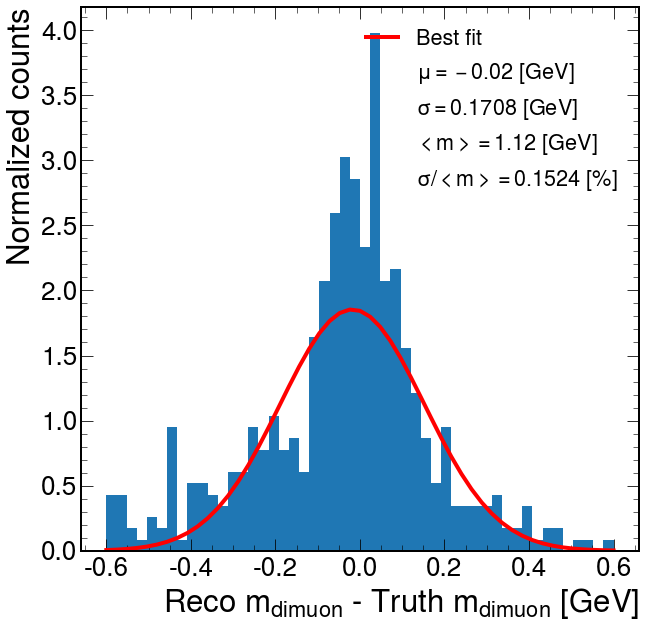

Error for parameter esimations:  [0.20712163 0.00980909 0.00807536]
Standard deviation (fit) is 0.1414384373250275
Mean (fit) is -0.025762648673830067


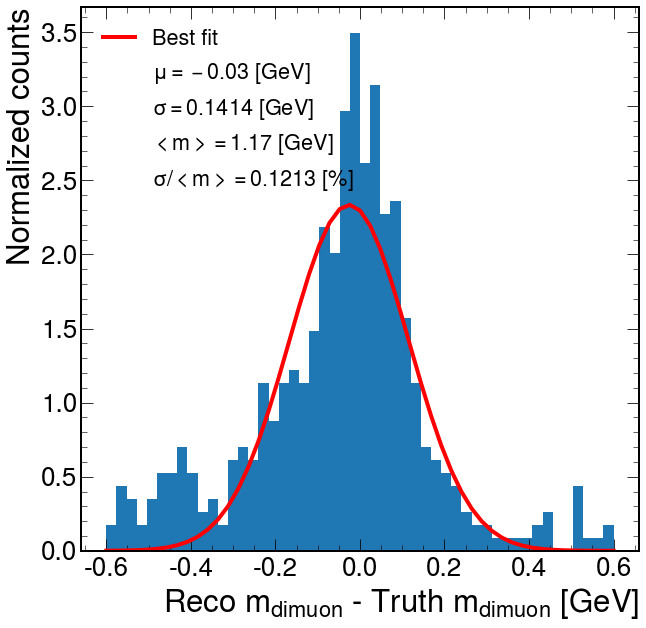

Error for parameter esimations:  [0.26210806 0.01362201 0.0125345 ]
Standard deviation (fit) is 0.1418968135421368
Mean (fit) is -0.02226725953892605


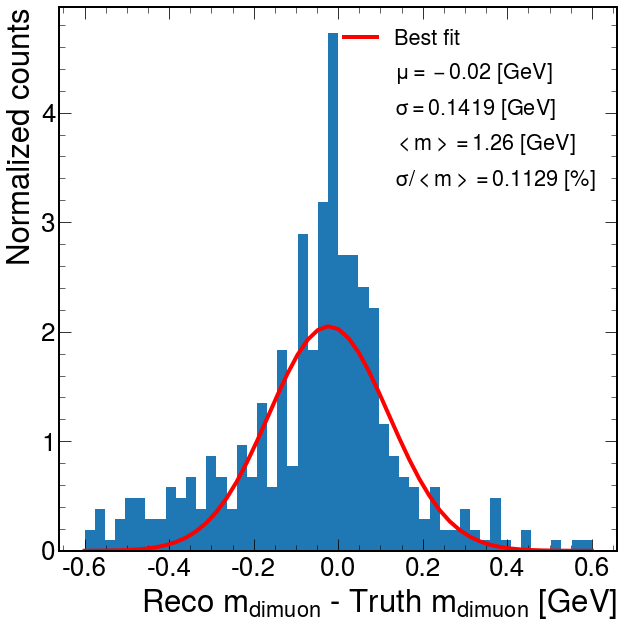

Error for parameter esimations:  [0.18893403 0.01911035 0.01966806]
Standard deviation (fit) is 0.20340245611322028
Mean (fit) is -0.015588884535240499


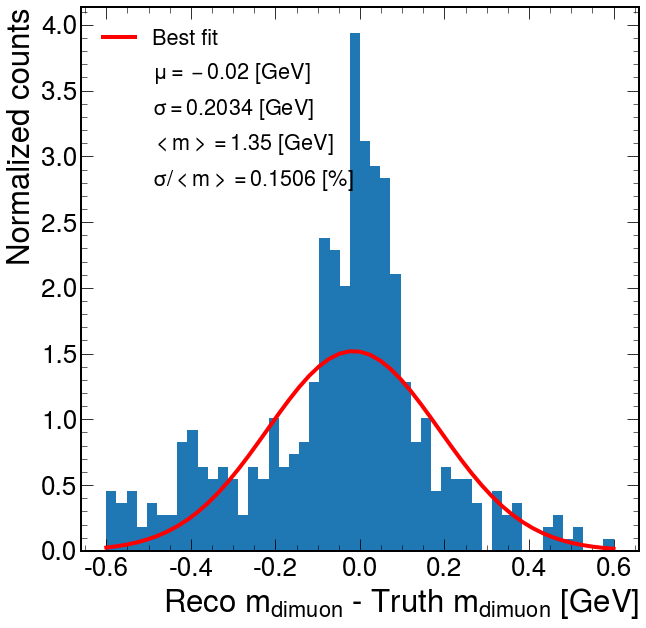

Error for parameter esimations:  [0.34062164 0.00846231 0.00781796]
Standard deviation (fit) is 0.10302139325383461
Mean (fit) is -0.0057884917863971885


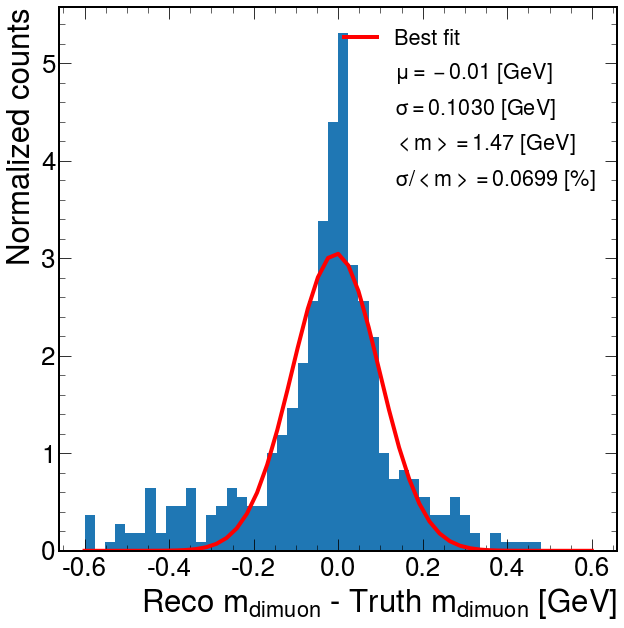

Error for parameter esimations:  [0.23825577 0.00843036 0.00719457]
Standard deviation (fit) is 0.12444809222160362
Mean (fit) is -0.011172963082751943


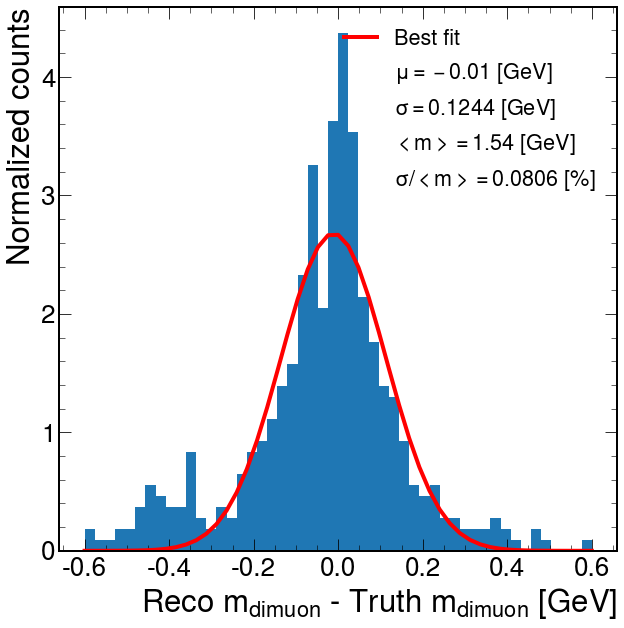

Error for parameter esimations:  [0.25301615 0.00904511 0.00784972]
Standard deviation (fit) is 0.12447349983161084
Mean (fit) is -0.017838920799241476


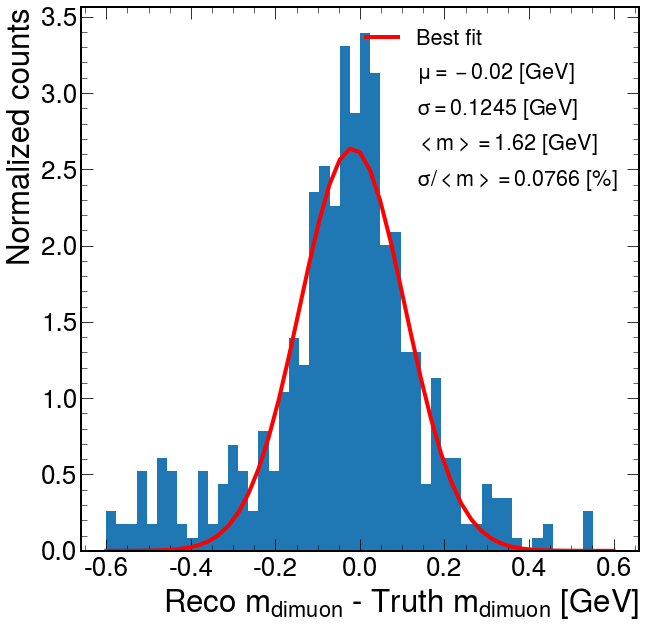

Error for parameter esimations:  [0.34788319 0.00877449 0.00775457]
Standard deviation (fit) is 0.10095327003385096
Mean (fit) is -0.030191137913467


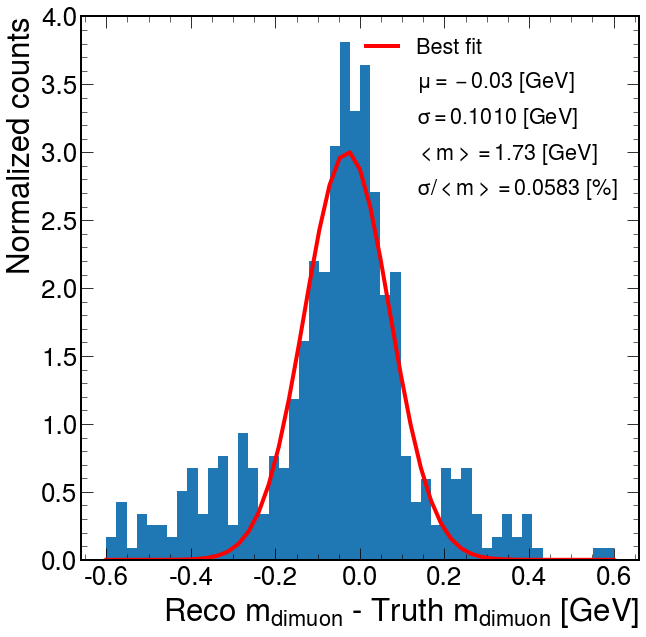

Error for parameter esimations:  [0.27039391 0.00867121 0.00775667]
Standard deviation (fit) is 0.11755898914850268
Mean (fit) is -0.004447143302051389


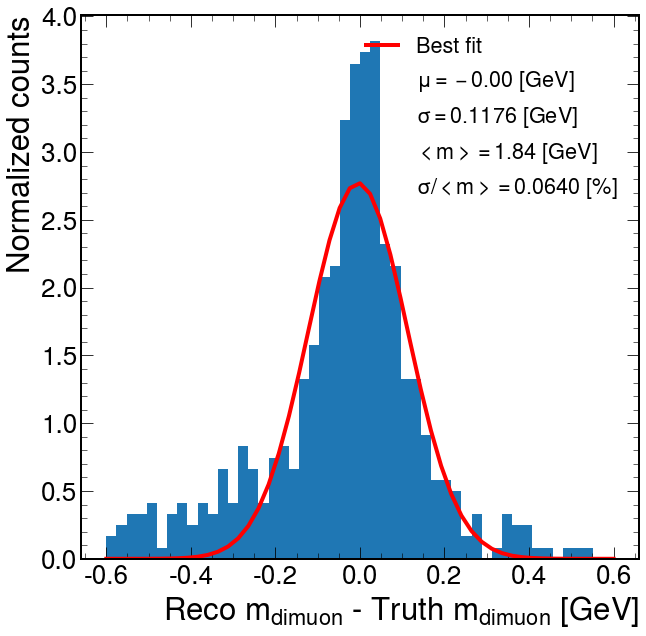

Error for parameter esimations:  [0.25264246 0.00836842 0.00748204]
Standard deviation (fit) is 0.12147840450198756
Mean (fit) is -0.012563246793004228


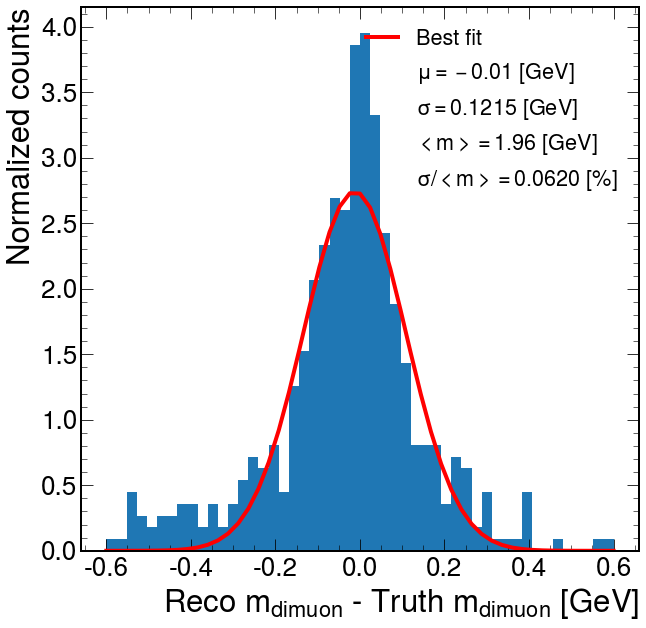

Error for parameter esimations:  [0.29779848 0.00830545 0.0074444 ]
Standard deviation (fit) is 0.10991625507206759
Mean (fit) is -0.005109442024052242


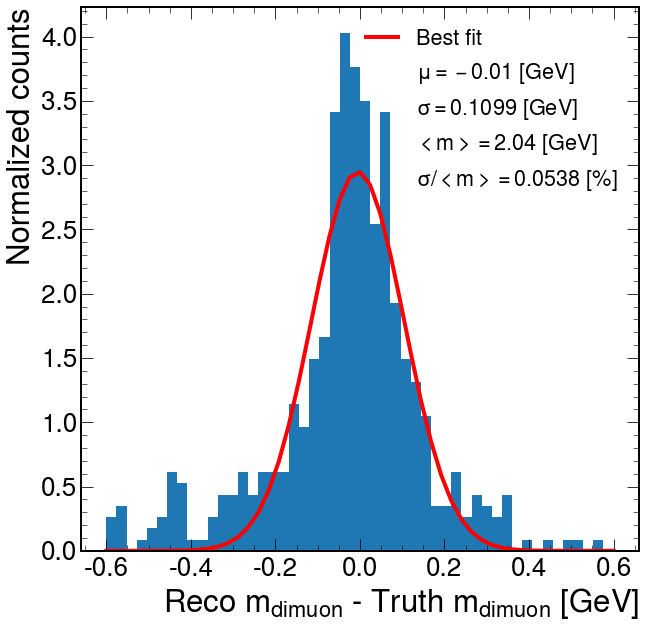

Error for parameter esimations:  [0.36501193 0.00813034 0.00708641]
Standard deviation (fit) is 0.09521619222583717
Mean (fit) is 0.0030285455374302046


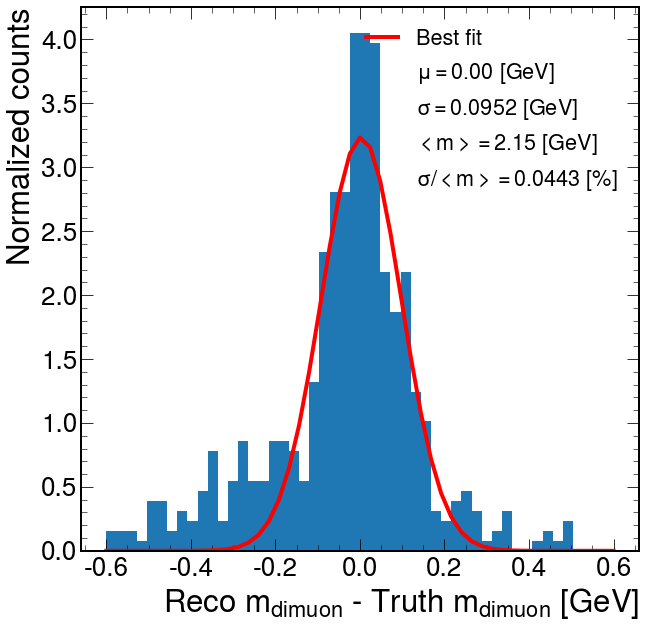

Error for parameter esimations:  [0.26082416 0.00807263 0.00720749]
Standard deviation (fit) is 0.11767012351730258
Mean (fit) is -0.00942522980144419


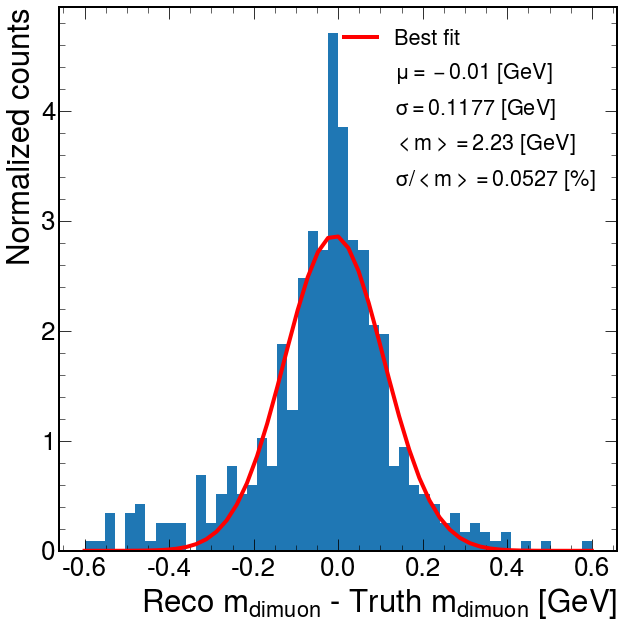

Error for parameter esimations:  [0.34192178 0.00821817 0.00693401]
Standard deviation (fit) is 0.0991796250059957
Mean (fit) is 0.008853384182269629


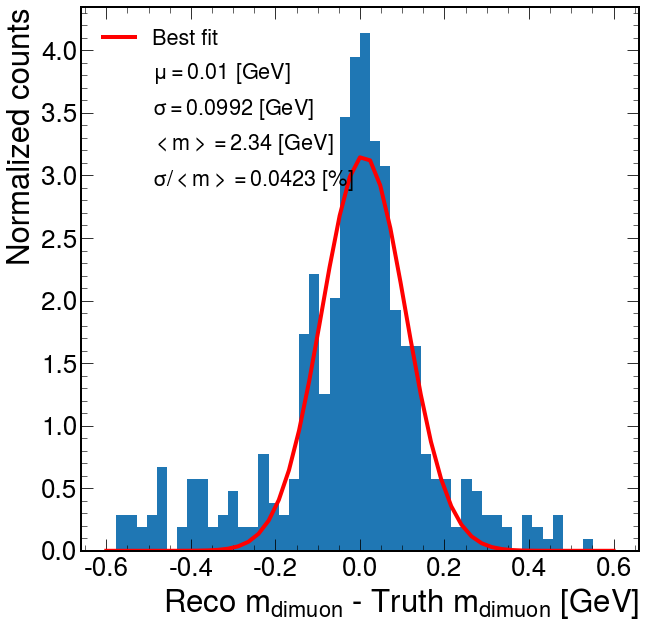

Error for parameter esimations:  [0.29782556 0.00862649 0.00743855]
Standard deviation (fit) is 0.11079849165479001
Mean (fit) is -0.007967823427268048


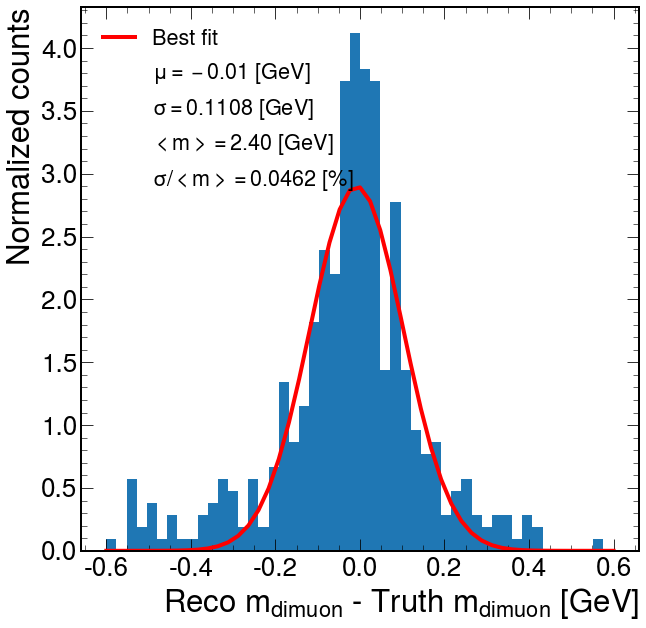

Error for parameter esimations:  [0.29985228 0.00780516 0.00688242]
Standard deviation (fit) is 0.10592632702861078
Mean (fit) is -0.0005091011754519872


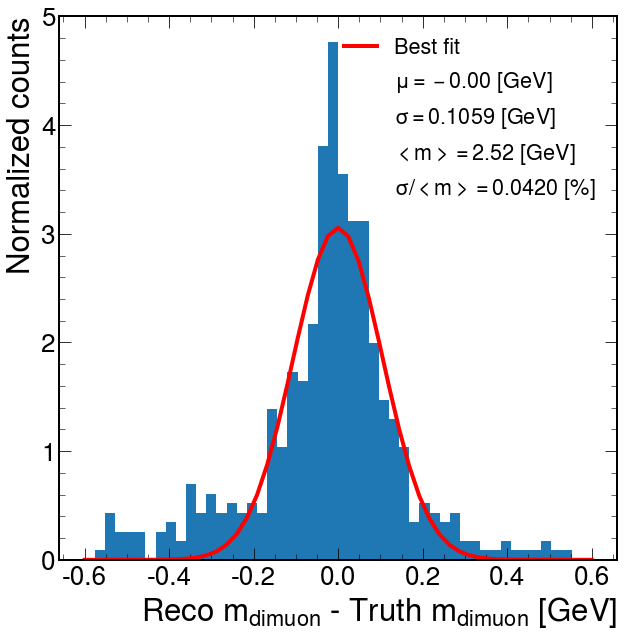

Error for parameter esimations:  [0.29887402 0.0068127  0.00574831]
Standard deviation (fit) is 0.09923527887816905
Mean (fit) is 0.0016559036299094697


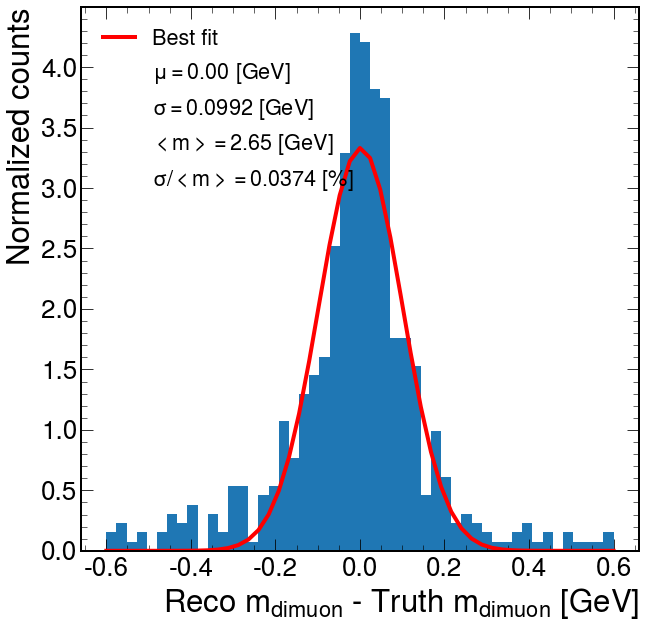

Error for parameter esimations:  [0.36133601 0.00762362 0.0066218 ]
Standard deviation (fit) is 0.09268244920174616
Mean (fit) is 0.006246285841137817


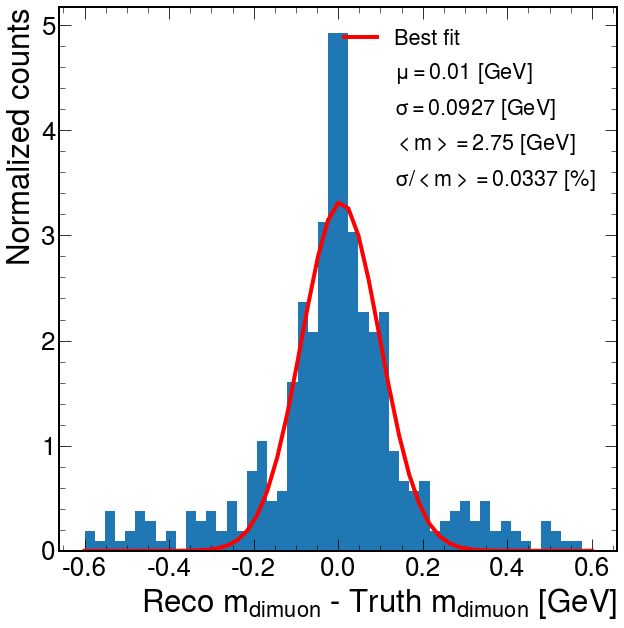

Error for parameter esimations:  [0.31469227 0.00767809 0.00633138]
Standard deviation (fit) is 0.10010221840646295
Mean (fit) is 0.0091699515283928


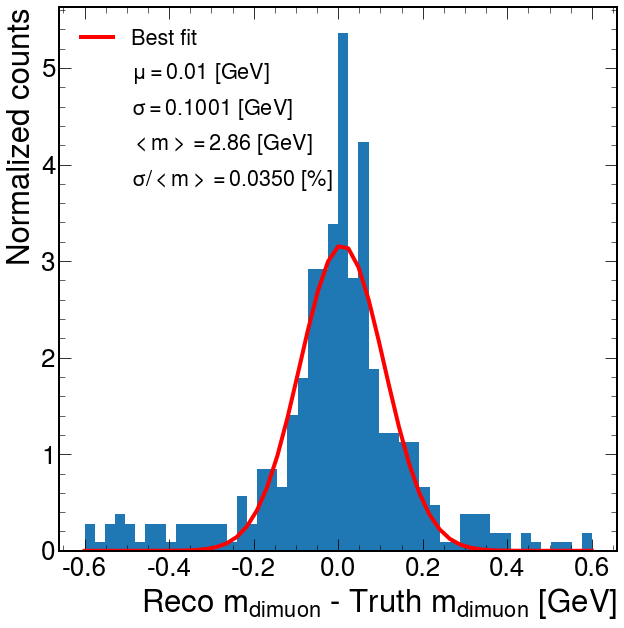

Error for parameter esimations:  [0.31699784 0.00756785 0.00578242]
Standard deviation (fit) is 0.09836421361808587
Mean (fit) is -0.01644284626053134


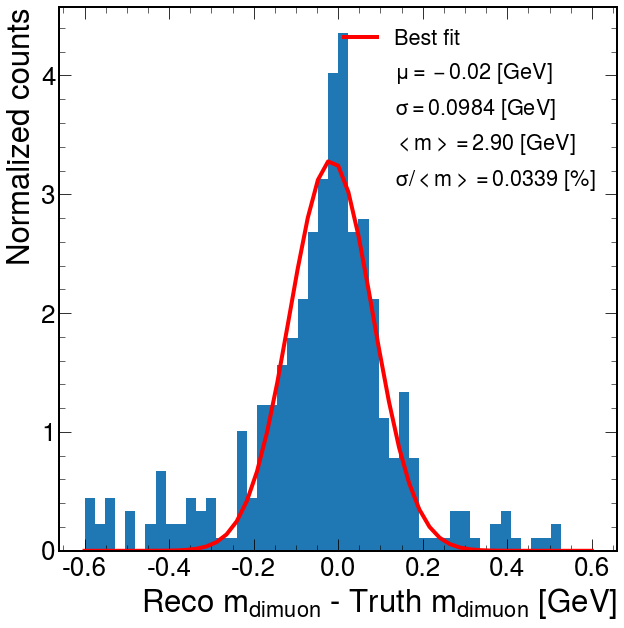

In [69]:
def reco_find_residual(dq_events, out_fmag = True):

    #Tracks selection
    reco_select = ak.count(dq_events["reco_dimuon"].mass, axis = 1) == 1

    truth_mass = ak.flatten(dq_events["truth_dimuon"].mass[reco_select])
    reco_mass = ak.flatten(dq_events["reco_dimuon"].mass[reco_select])
    reco_z = ak.flatten(dq_events["reco_dimuon"].z[reco_select])

    #filter nana
    nan_filter = ~np.isnan(reco_mass) & ~np.isnan(reco_z)
    truth_mass = truth_mass[nan_filter]
    reco_mass = reco_mass[nan_filter]
    reco_z = reco_z[nan_filter]

    #Reco outside of Fmag
    reco_z_select = reco_z > 520 if out_fmag else reco_z < 520

    truth_mass = truth_mass[reco_z_select]
    reco_mass = reco_mass[reco_z_select]


    #Calculate the residual
    residual = reco_mass - truth_mass

    return np.asarray(residual), ak.mean(reco_mass)

def gaussian_fit(residual,
                 mean,
                 plot_bins = 50,
                 plot_range = (-0.6,0.6),
                 p_guess=[10, 0, 0.01],
                 residual_label = r'Reco $m_{dimuon}$ - Truth $m_{dimuon}$ [GeV]'):
    
    #Plot and fit
    plt.hist(residual,
         bins = plot_bins,
         range = plot_range,
         density = True)
    
    ## Gaussian fit
    ## Fit directly on the histogram
    def fit_function(x, A, mu, sig):
        return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    
    data_entries, _ = np.histogram(residual, bins=bins,
                                   range = plot_range,
                                   density = True)
    
    mask = data_entries!=0
    #Fit the function to the histogram data.
    popt, pcov = curve_fit(fit_function,
                           xdata=binscenters[mask],
                           ydata=data_entries[mask],
                           sigma = np.sqrt(data_entries[mask]),
                           absolute_sigma = False,
                           p0=p_guess)
    
    #Error for parameter estimations
    perr = np.sqrt(np.diag(pcov))
    print("Error for parameter esimations: ", perr)

    std_fit = np.abs(popt[2])
    mean_fit = popt[1]
    
    print("Standard deviation (fit) is", std_fit)
    print("Mean (fit) is", mean_fit)
    
    #Plot fitted gaussian
    plt.plot(bins,
             fit_function(bins, *popt),
             "r-",
             linewidth=4,
             label='Best fit')

    plt.plot([],[], 'none', label=r'$\mu=%.2f$ [GeV]'%popt[1])
    plt.plot([],[], 'none', label=r'$\sigma=%.4f$ [GeV]'%abs(popt[2]))
    plt.plot([],[], 'none', label=r'$<m>=%.2f$ [GeV]'%mean)
    plt.plot([],[], 'none', label=r'$\sigma/<m>=%.4f$ [%%]'%(abs(popt[2])/mean))
    
    #Label the axes
    plt.xlabel(residual_label)
    plt.ylabel('Normalized counts')

    plt.legend()

    plt.show()
    
    return (abs(popt[2])/mean), perr[2]/mean



def rms_and_m(sample_dir, out_fmag = True):
    
    coupling = "-7.6"
    
    res_list = []
    mass_list = []
    err_list = []
    
     #Loop through the files
    for filename in os.listdir(sample_dir):
        if filename.startswith("Brem"):
            if coupling in filename:
                file_path = os.path.join(sample_dir,filename)
                dq_events = getData(file_path, treeName = 'Events')
                
                m_residual, m_mean = reco_find_residual(dq_events, out_fmag)
                res, err = gaussian_fit(m_residual, m_mean)
                
                res_list.append(res)
                err_list.append(err)
                
                #Parse mass info
                Ap_config = filename[:-5].split('_') #Remove the .root part and split by '_'
                mass_list.append(float(Ap_config[1]))
    
    return mass_list, res_list, err_list

mass_list, res_list, err_list = rms_and_m(sample_dir)
mass_list_in, res_list_in, err_list_in = rms_and_m(sample_dir, out_fmag = False) 

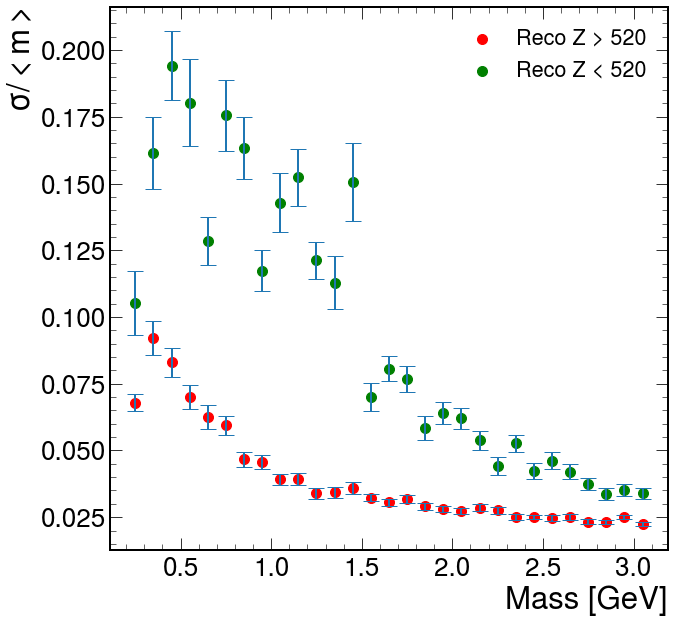

In [70]:
#Plot the error bars
plt.errorbar(mass_list,
            res_list,
            yerr=err_list,
            fmt='none',
            elinewidth=2,
            capsize=8)

plt.scatter(mass_list, res_list,
            c = 'r', label = 'Reco Z > 520',
            s= 100)

plt.errorbar(mass_list_in,
            res_list_in,
            yerr=err_list_in,
            fmt='none',
            elinewidth=2,
            capsize=8)

plt.scatter(mass_list_in, res_list_in,
            c = 'g', label = 'Reco Z < 520',
            s= 100)

plt.ylabel(r'$\sigma/<m>$')
plt.xlabel('Mass [GeV]')

plt.legend()
plt.show()

## Resolution versus coupling

Error for parameter esimations:  [0.68608255 0.00295509 0.00256093]
Standard deviation (fit) is 0.044134463548670594
Mean (fit) is 0.005453188667685182


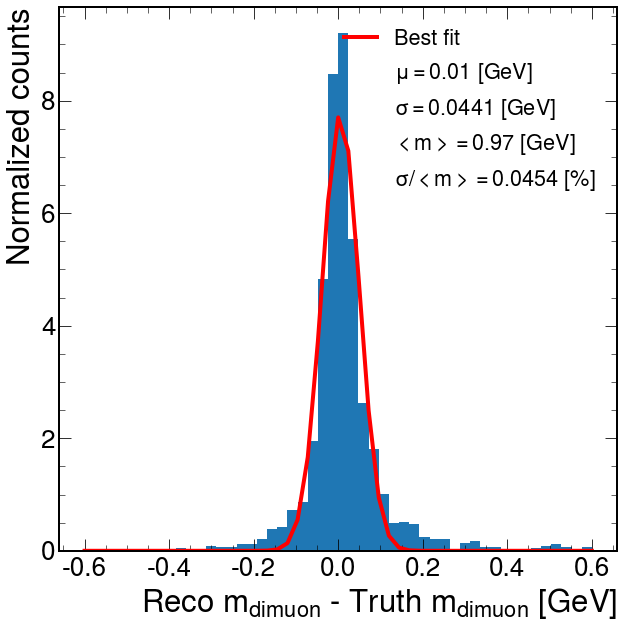

Error for parameter esimations:  [0.69989369 0.0030288  0.0026631 ]
Standard deviation (fit) is 0.043950869352767256
Mean (fit) is 0.0006862434634635754


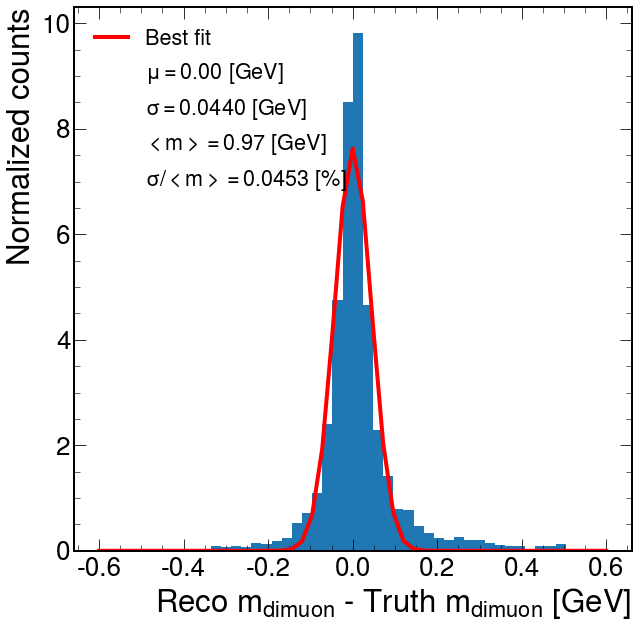

Error for parameter esimations:  [0.66568541 0.00298019 0.0026121 ]
Standard deviation (fit) is 0.04493821451101526
Mean (fit) is 0.004427910821943755


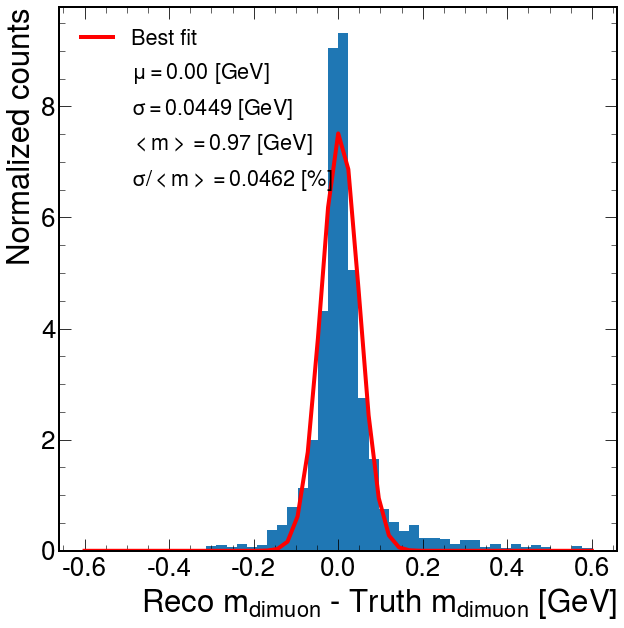

Error for parameter esimations:  [0.63324665 0.00305076 0.00263805]
Standard deviation (fit) is 0.04656786629667275
Mean (fit) is 0.003956483839256695


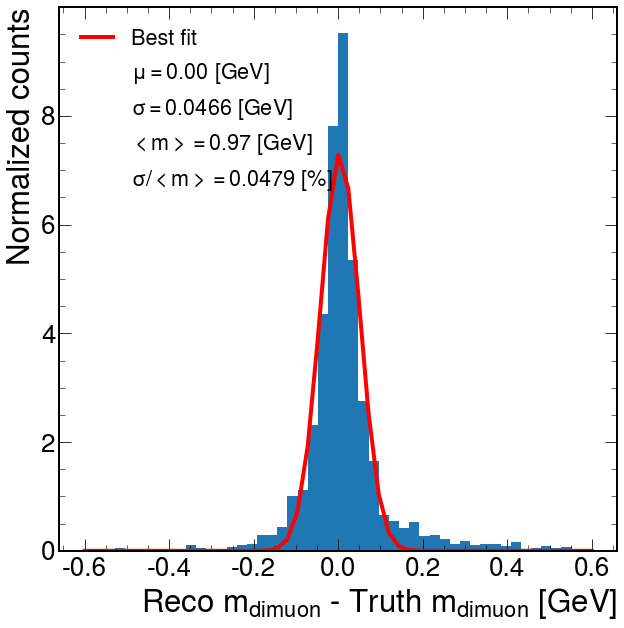

Error for parameter esimations:  [0.71580266 0.00302635 0.00263377]
Standard deviation (fit) is 0.04334476324953152
Mean (fit) is 0.0025100721257940023


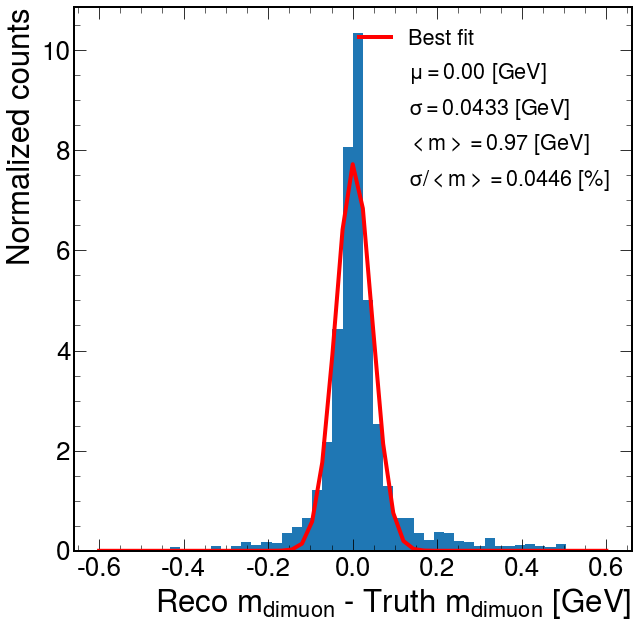

Error for parameter esimations:  [0.75891029 0.00296582 0.00255935]
Standard deviation (fit) is 0.04151184785858527
Mean (fit) is 0.0030734418414214413


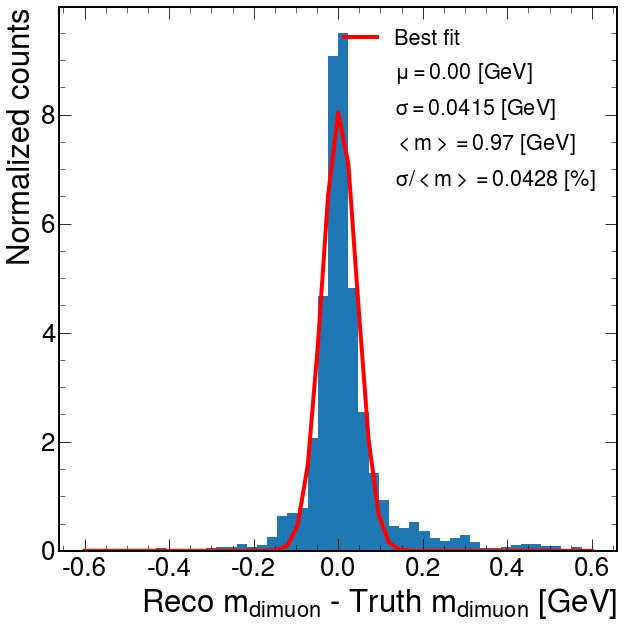

Error for parameter esimations:  [0.76287027 0.0029548  0.00264039]
Standard deviation (fit) is 0.04119192919831242
Mean (fit) is 0.0035203946318157777


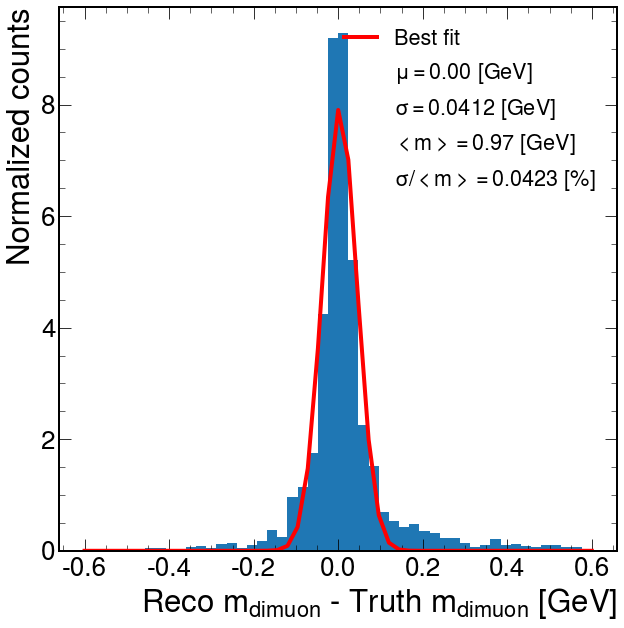

Error for parameter esimations:  [0.69215304 0.00295043 0.00256311]
Standard deviation (fit) is 0.04362862508710687
Mean (fit) is 0.004804552273076065


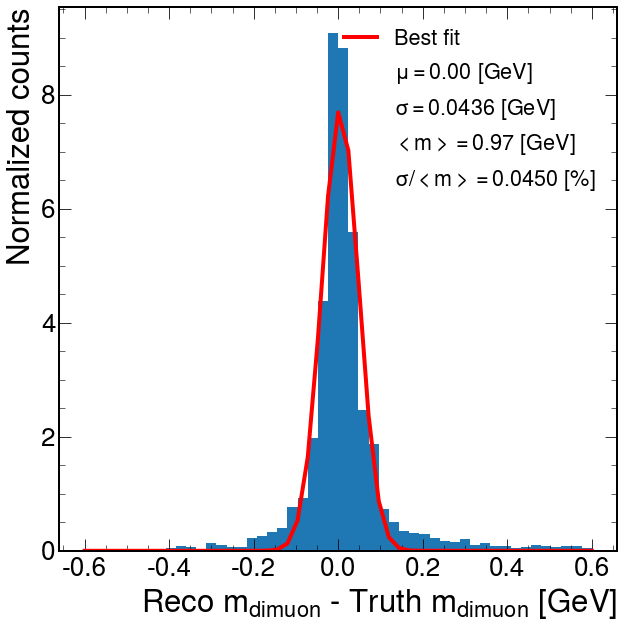

Error for parameter esimations:  [0.71415605 0.00314167 0.00271571]
Standard deviation (fit) is 0.044087275485095896
Mean (fit) is 0.004321521314397916


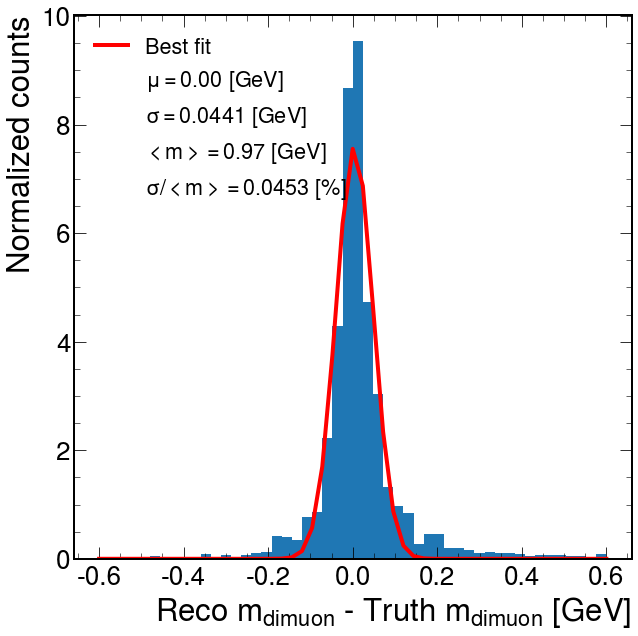

Error for parameter esimations:  [0.57631718 0.00272086 0.00228328]
Standard deviation (fit) is 0.04616708608020168
Mean (fit) is 0.002810441337272235


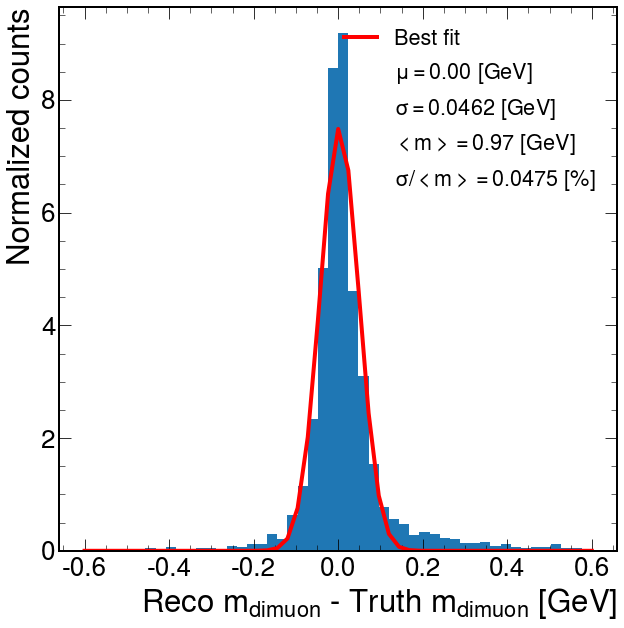

Error for parameter esimations:  [0.72836478 0.00315849 0.00273667]
Standard deviation (fit) is 0.04358889358355258
Mean (fit) is 0.0028830622390480375


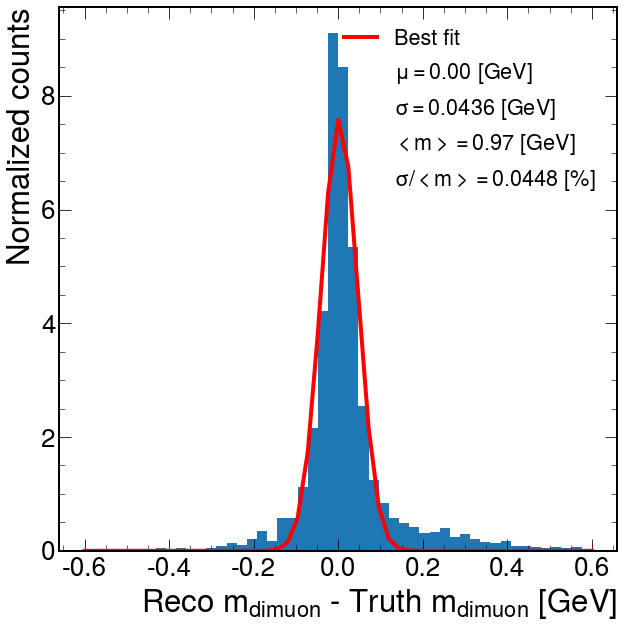

Error for parameter esimations:  [0.62822365 0.0031605  0.00275292]
Standard deviation (fit) is 0.04765519225951857
Mean (fit) is 0.0038733860281989674


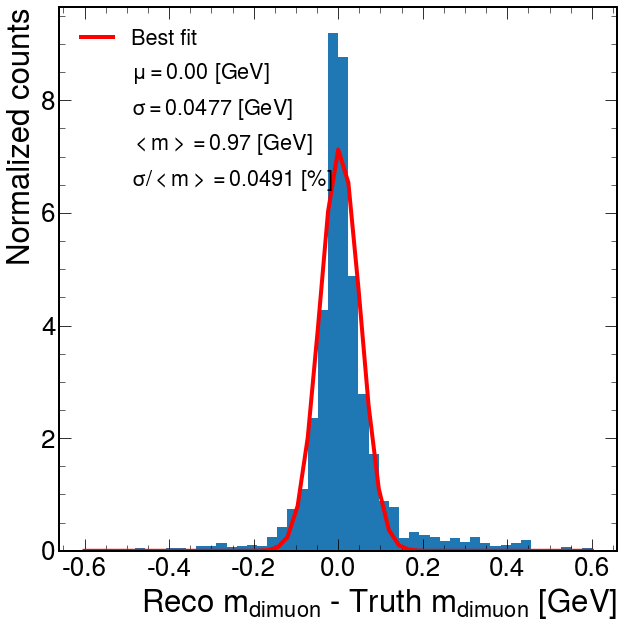

Error for parameter esimations:  [0.64323372 0.0029724  0.0025909 ]
Standard deviation (fit) is 0.04532862049606211
Mean (fit) is 0.003790994686734482


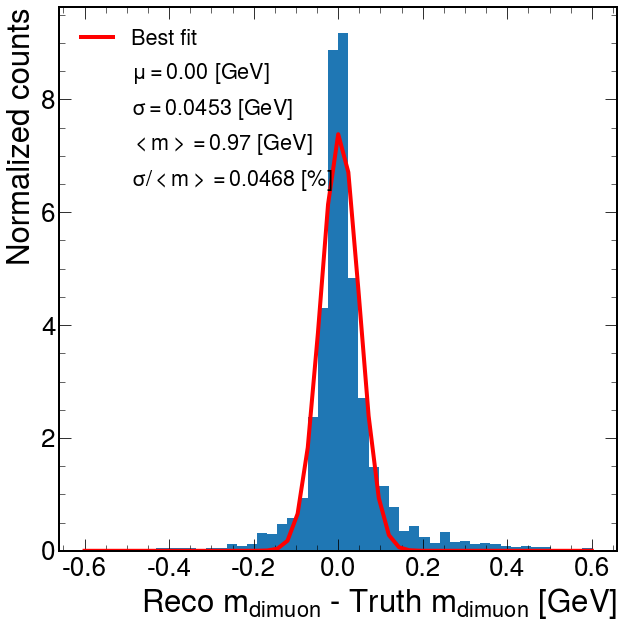

Error for parameter esimations:  [0.70967783 0.00329295 0.00296768]
Standard deviation (fit) is 0.045364054946238595
Mean (fit) is 0.0042500742828976935


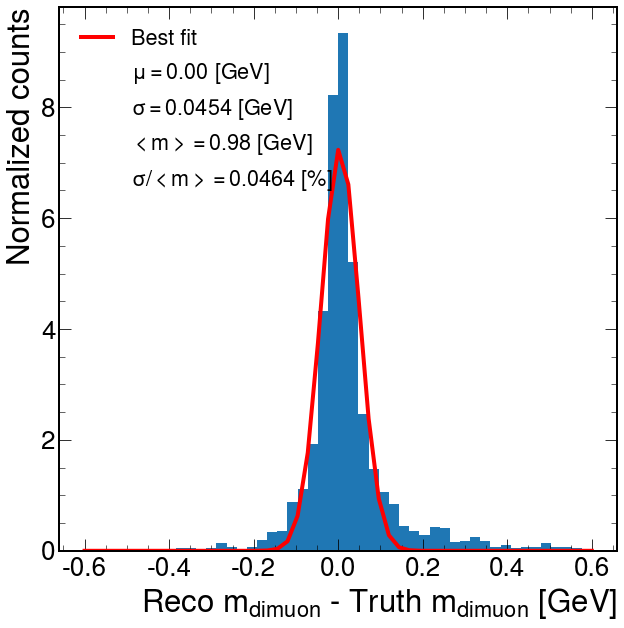

Error for parameter esimations:  [0.63386449 0.00344762 0.00309102]
Standard deviation (fit) is 0.049258621334328345
Mean (fit) is 0.0065332857324083456


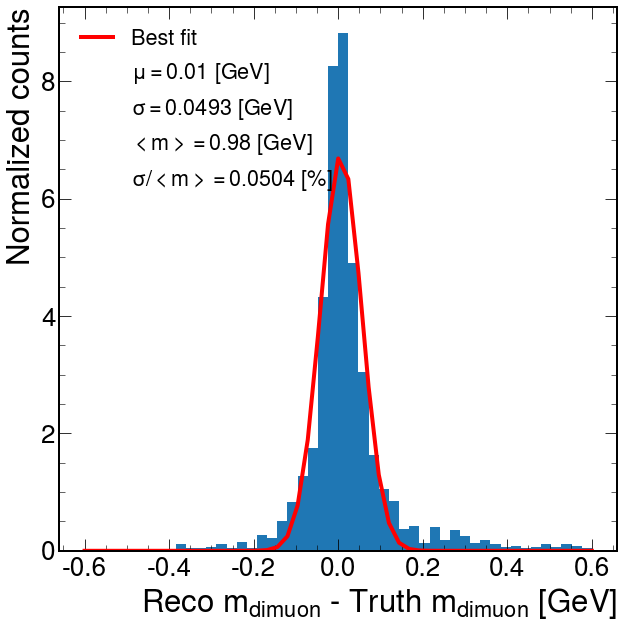

Error for parameter esimations:  [0.65805079 0.00315557 0.00275695]
Standard deviation (fit) is 0.04617218573679337
Mean (fit) is 0.0014964114011722783


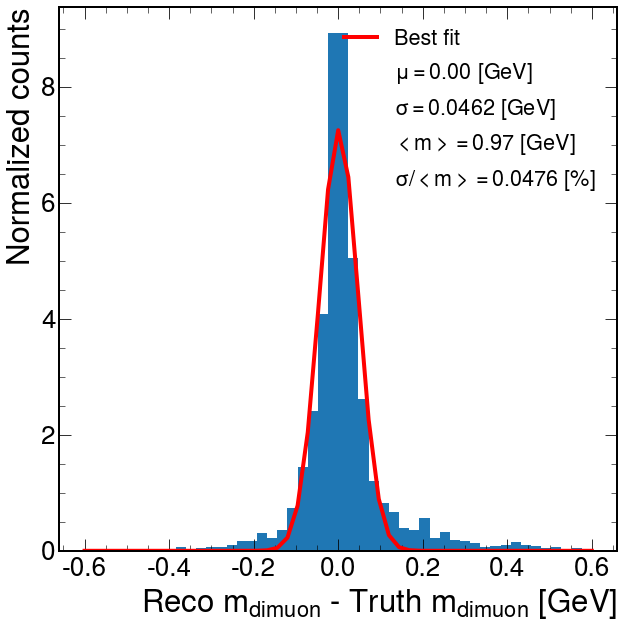

Error for parameter esimations:  [0.64033112 0.00297319 0.00258756]
Standard deviation (fit) is 0.04573966813223963
Mean (fit) is 0.0043495810214447305


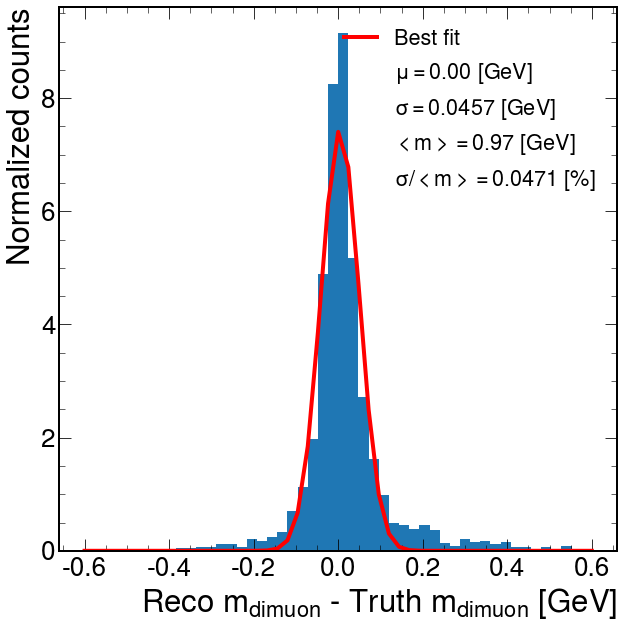

Error for parameter esimations:  [0.67606229 0.00296355 0.00256972]
Standard deviation (fit) is 0.04431018389895947
Mean (fit) is 0.001176184568099605


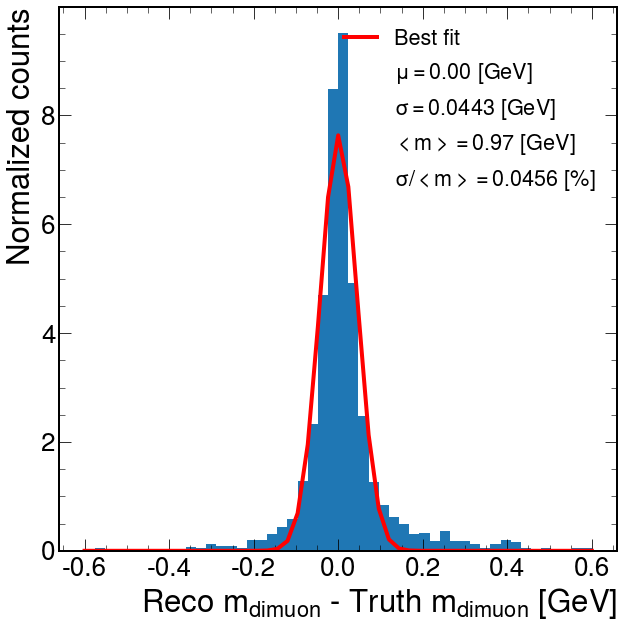

Error for parameter esimations:  [0.70752874 0.00315935 0.00279504]
Standard deviation (fit) is 0.044600997571240114
Mean (fit) is 0.002760562530636265


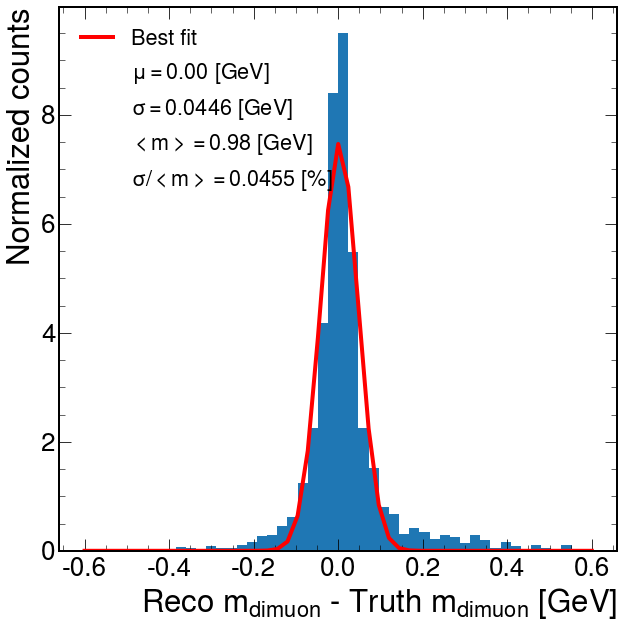

Error for parameter esimations:  [0.26275439 0.01102873 0.01003456]
Standard deviation (fit) is 0.13142434811764409
Mean (fit) is -0.013105442786055046


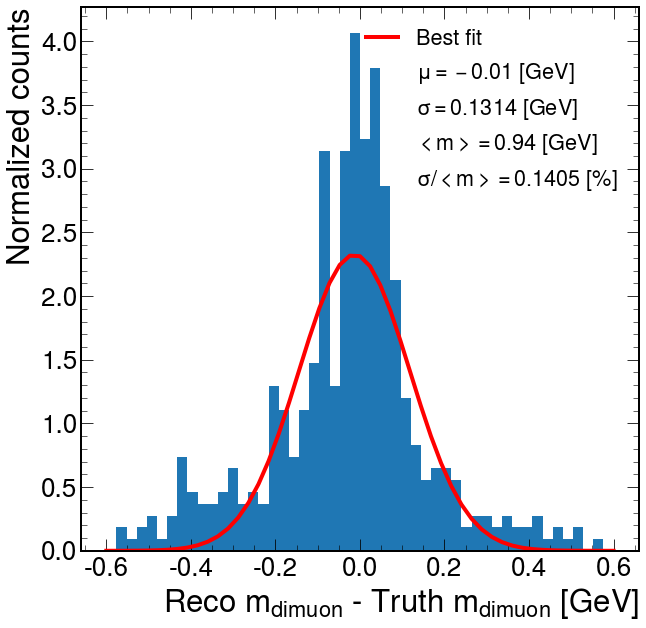

Error for parameter esimations:  [0.22871765 0.01250364 0.01139587]
Standard deviation (fit) is 0.1496612711182396
Mean (fit) is -0.011604974352946352


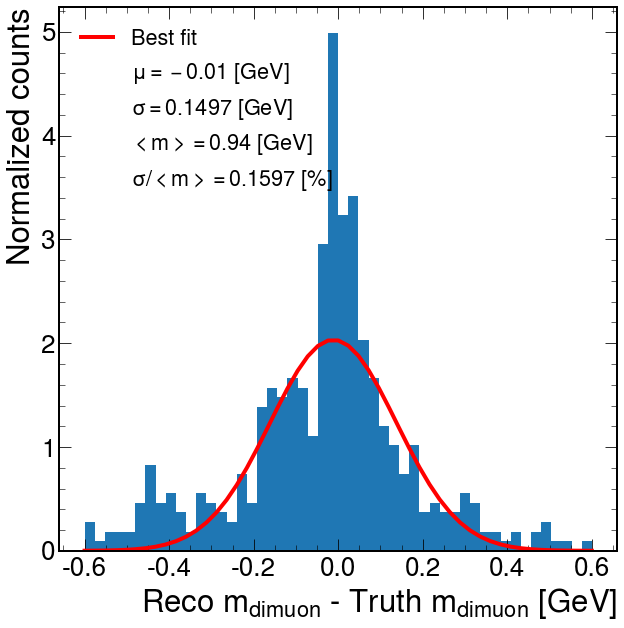

Error for parameter esimations:  [0.29893115 0.01030059 0.00958922]
Standard deviation (fit) is 0.11873142514047973
Mean (fit) is -0.03322721057510977


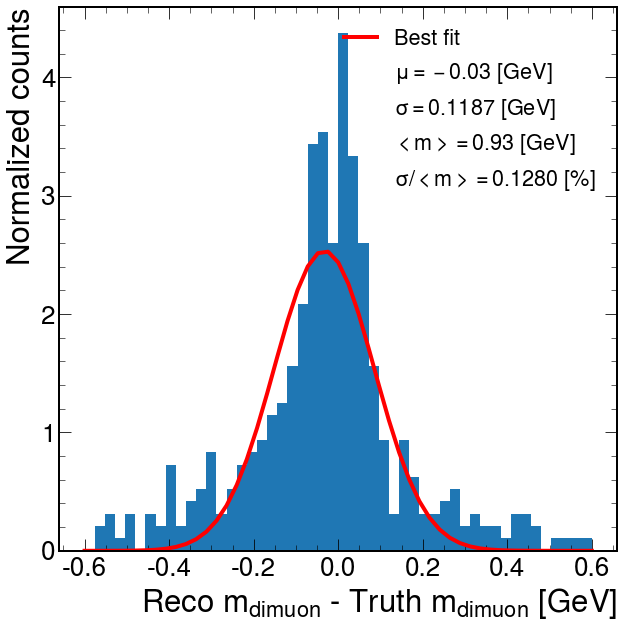

Error for parameter esimations:  [0.29220557 0.01131513 0.00983959]
Standard deviation (fit) is 0.12316976901429398
Mean (fit) is -0.032584228991367536


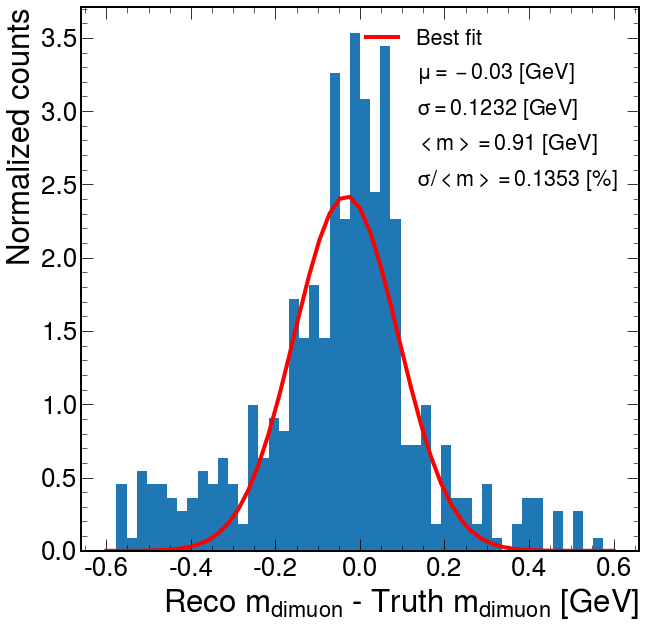

Error for parameter esimations:  [0.28693542 0.00855909 0.00767702]
Standard deviation (fit) is 0.11297183661880493
Mean (fit) is -0.014423412249163308


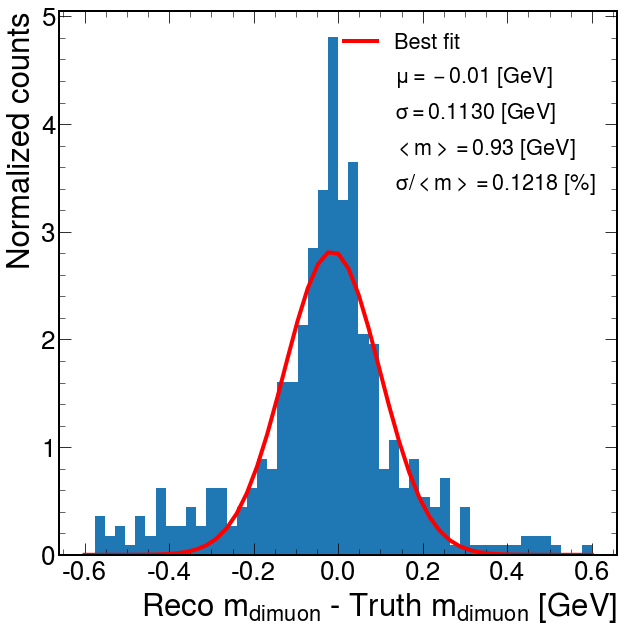

Error for parameter esimations:  [0.34535563 0.00998821 0.00863972]
Standard deviation (fit) is 0.10414843995758859
Mean (fit) is -0.0175865966116869


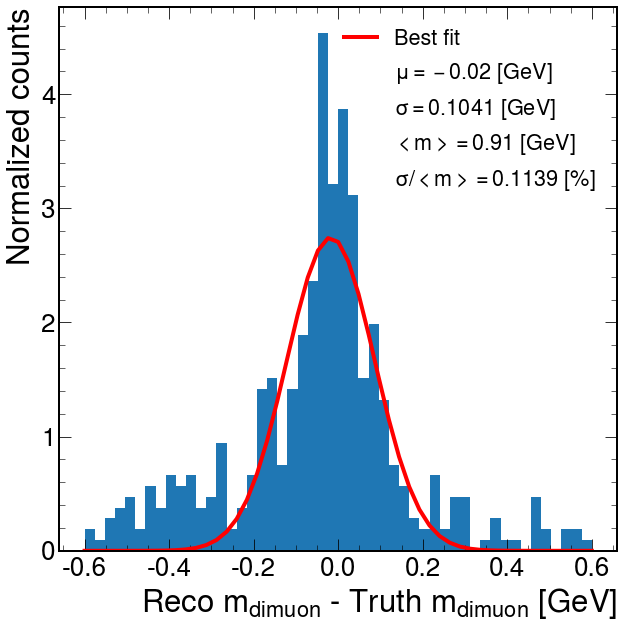

Error for parameter esimations:  [0.23536826 0.0098259  0.00868861]
Standard deviation (fit) is 0.1346826837444882
Mean (fit) is -0.021987850806798166


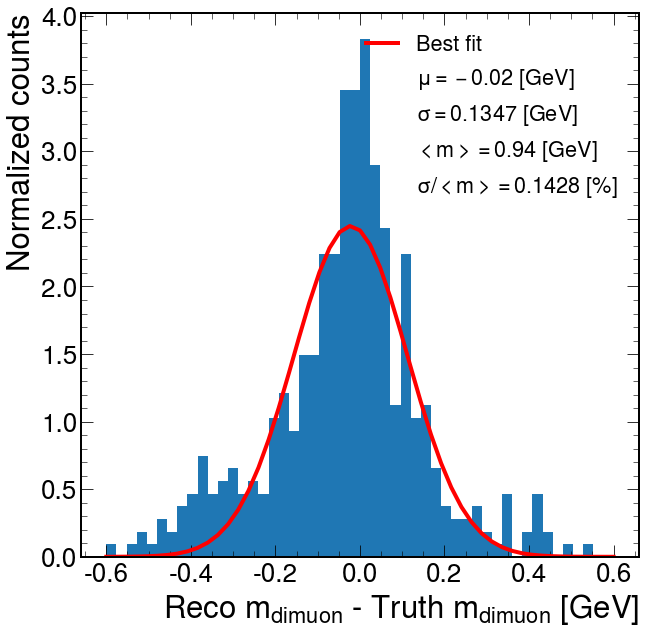

Error for parameter esimations:  [0.29430764 0.00954091 0.00824135]
Standard deviation (fit) is 0.11458965131112425
Mean (fit) is -0.017816615311799004


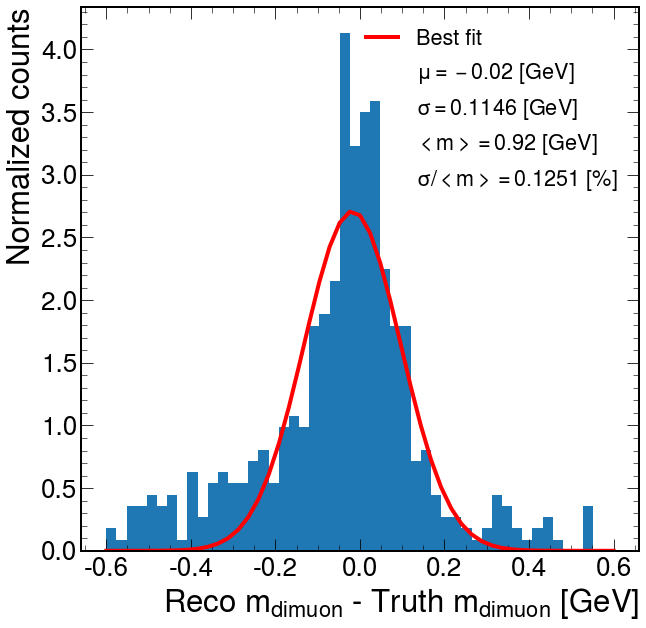

Error for parameter esimations:  [0.3234513  0.01031613 0.00874282]
Standard deviation (fit) is 0.10963239860104805
Mean (fit) is -0.022110831362556524


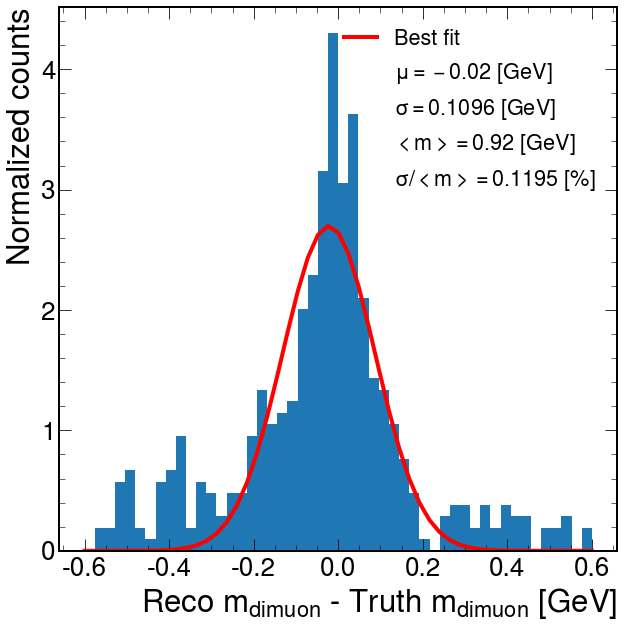

Error for parameter esimations:  [0.24932282 0.01162266 0.01017422]
Standard deviation (fit) is 0.1372642897978541
Mean (fit) is -0.029286708906174363


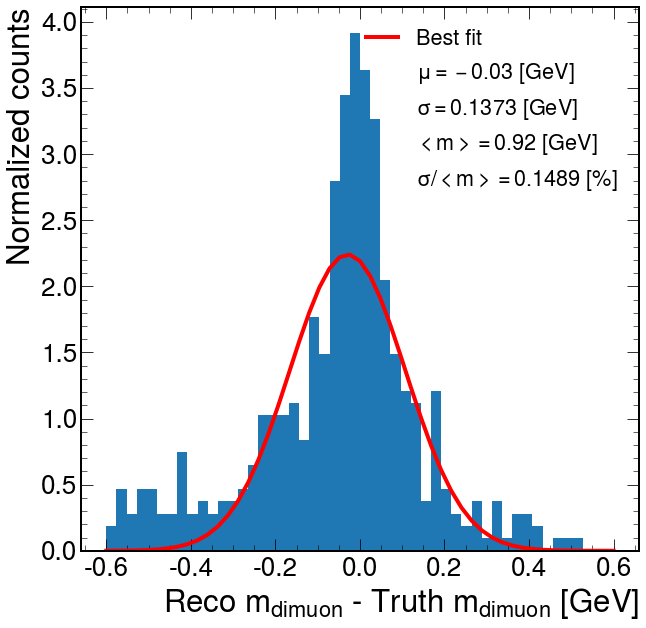

Error for parameter esimations:  [0.24537237 0.01068169 0.00990905]
Standard deviation (fit) is 0.13658322698109596
Mean (fit) is -0.015631190041391057


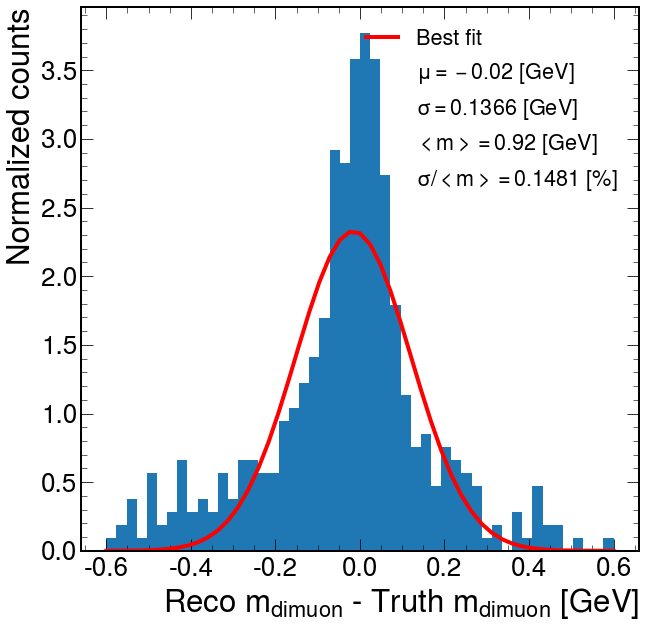

Error for parameter esimations:  [0.32562557 0.00965894 0.00847439]
Standard deviation (fit) is 0.1080726820484847
Mean (fit) is -0.0038459966187434696


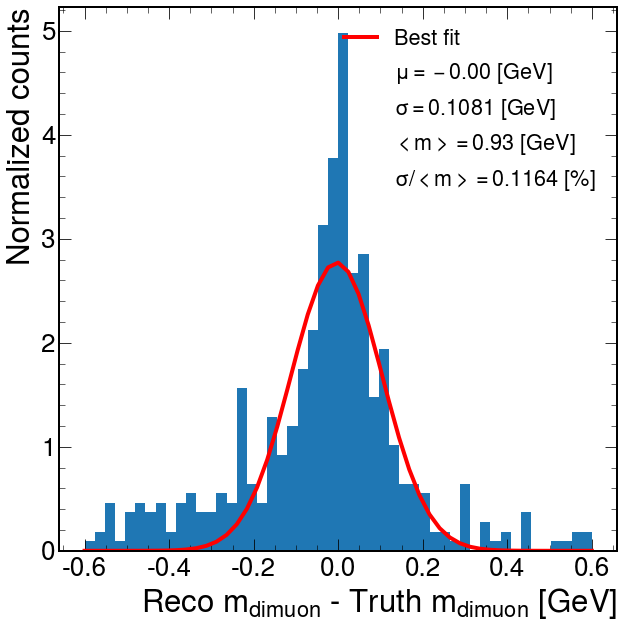

Error for parameter esimations:  [0.34989095 0.00886314 0.00774006]
Standard deviation (fit) is 0.09978275454031536
Mean (fit) is -0.02152564371888195


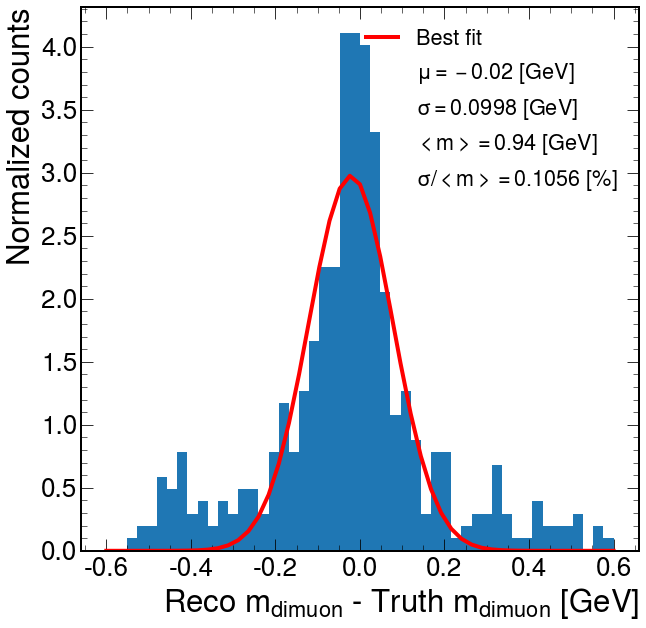

Error for parameter esimations:  [0.47512208 0.0085819  0.00812884]
Standard deviation (fit) is 0.08222467573704616
Mean (fit) is -0.0019563516361926583


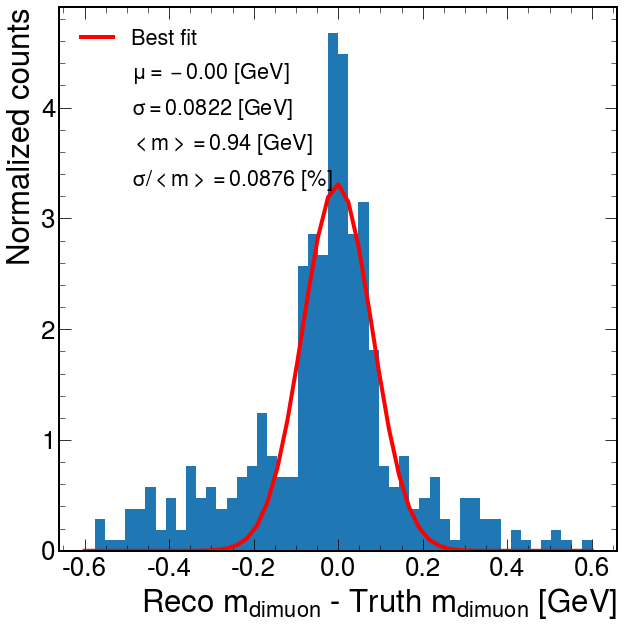

Error for parameter esimations:  [0.26894369 0.01107323 0.01048442]
Standard deviation (fit) is 0.1319985088017588
Mean (fit) is -0.0183866584632887


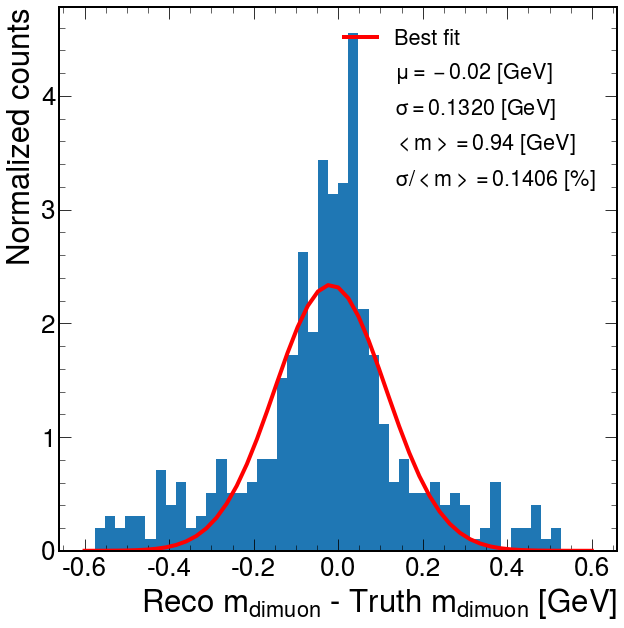

Error for parameter esimations:  [0.27497825 0.01336236 0.01324718]
Standard deviation (fit) is 0.13902254464135816
Mean (fit) is -0.008001674665588761


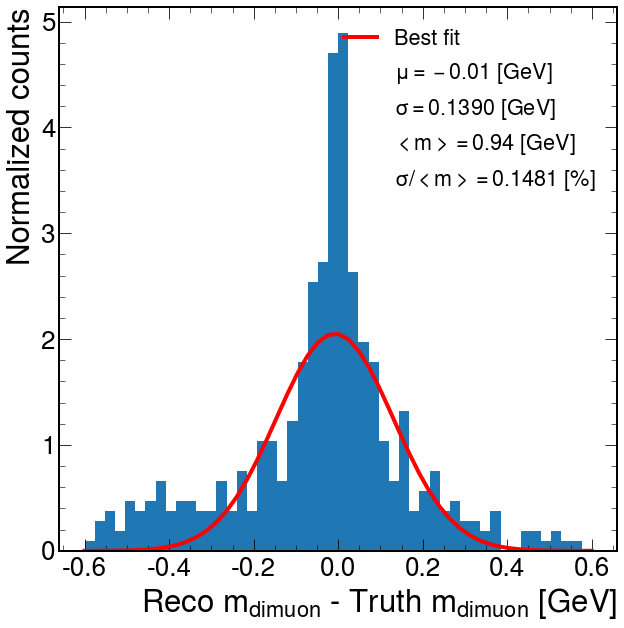

Error for parameter esimations:  [0.32735591 0.00934929 0.00854916]
Standard deviation (fit) is 0.1072613045439212
Mean (fit) is -0.003865783844281554


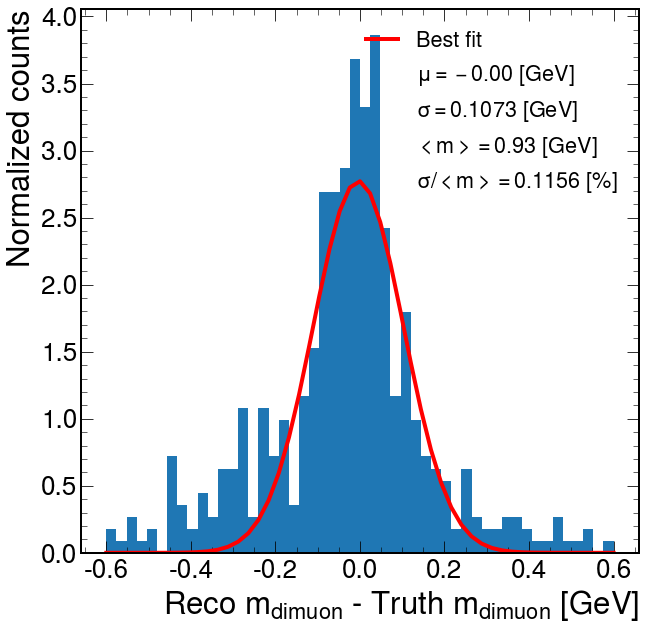

Error for parameter esimations:  [0.29428638 0.00847417 0.00712526]
Standard deviation (fit) is 0.10915783781483972
Mean (fit) is -0.024510403681386284


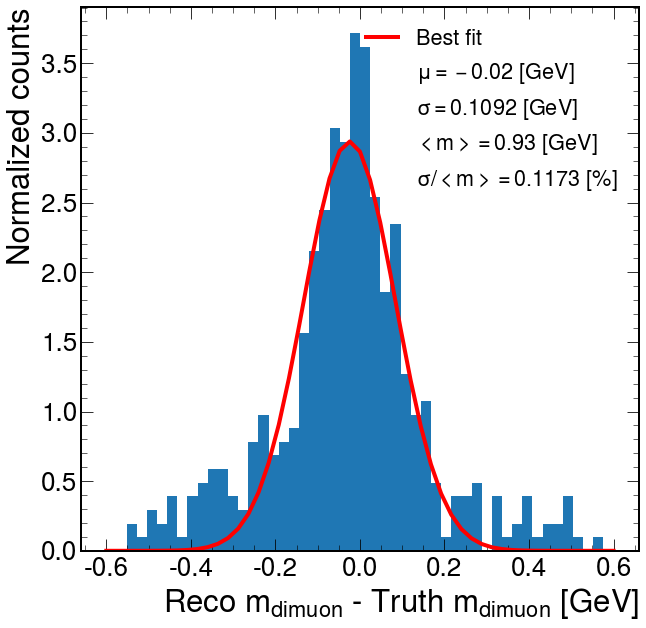

Error for parameter esimations:  [0.23687253 0.0091767  0.00776424]
Standard deviation (fit) is 0.12807864205662656
Mean (fit) is -0.013250050077288215


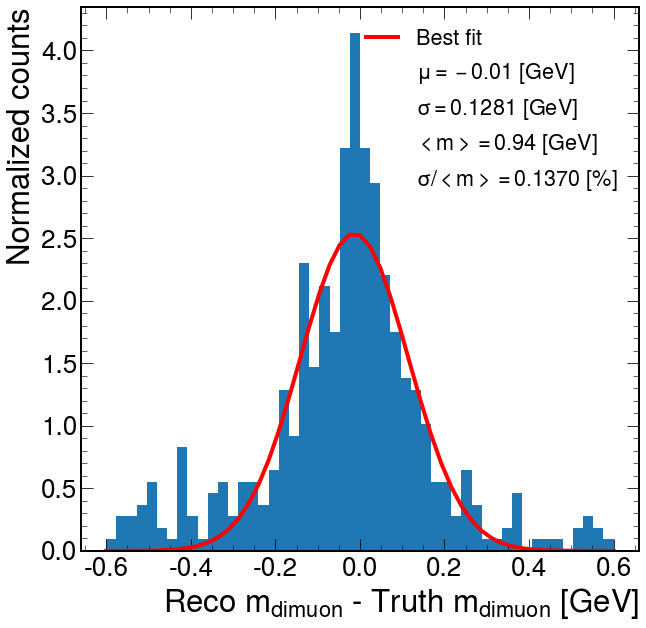

In [65]:
def reco_find_residual(dq_events, out_fmag = True):

    #Tracks selection
    reco_select = ak.count(dq_events["reco_dimuon"].mass, axis = 1) == 1

    truth_mass = ak.flatten(dq_events["truth_dimuon"].mass[reco_select])
    reco_mass = ak.flatten(dq_events["reco_dimuon"].mass[reco_select])
    reco_z = ak.flatten(dq_events["reco_dimuon"].z[reco_select])

    #filter nana
    nan_filter = ~np.isnan(reco_mass) & ~np.isnan(reco_z)
    truth_mass = truth_mass[nan_filter]
    reco_mass = reco_mass[nan_filter]
    reco_z = reco_z[nan_filter]

    #Reco outside of Fmag
    reco_z_select = reco_z > 520 if out_fmag else reco_z < 520

    truth_mass = truth_mass[reco_z_select]
    reco_mass = reco_mass[reco_z_select]


    #Calculate the residual
    residual = reco_mass - truth_mass

    return np.asarray(residual), ak.mean(reco_mass)

def gaussian_fit(residual,
                 mean,
                 plot_bins = 50,
                 plot_range = (-0.6,0.6),
                 p_guess=[10, 0, 0.01],
                 residual_label = r'Reco $m_{dimuon}$ - Truth $m_{dimuon}$ [GeV]'):
    
    #Plot and fit
    plt.hist(residual,
         bins = plot_bins,
         range = plot_range,
         density = True)
    
    ## Gaussian fit
    ## Fit directly on the histogram
    def fit_function(x, A, mu, sig):
        return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    
    data_entries, _ = np.histogram(residual, bins=bins,
                                   range = plot_range,
                                   density = True)
    
    mask = data_entries!=0
    #Fit the function to the histogram data.
    popt, pcov = curve_fit(fit_function,
                           xdata=binscenters[mask],
                           ydata=data_entries[mask],
                           sigma = np.sqrt(data_entries[mask]),
                           absolute_sigma = False,
                           p0=p_guess)
    
    #Error for parameter estimations
    perr = np.sqrt(np.diag(pcov))
    print("Error for parameter esimations: ", perr)

    std_fit = np.abs(popt[2])
    mean_fit = popt[1]
    
    print("Standard deviation (fit) is", std_fit)
    print("Mean (fit) is", mean_fit)
    
    #Plot fitted gaussian
    plt.plot(bins,
             fit_function(bins, *popt),
             "r-",
             linewidth=4,
             label='Best fit')

    plt.plot([],[], 'none', label=r'$\mu=%.2f$ [GeV]'%popt[1])
    plt.plot([],[], 'none', label=r'$\sigma=%.4f$ [GeV]'%abs(popt[2]))
    plt.plot([],[], 'none', label=r'$<m>=%.2f$ [GeV]'%mean)
    plt.plot([],[], 'none', label=r'$\sigma/<m>=%.4f$ [%%]'%(abs(popt[2])/mean))
    
    #Label the axes
    plt.xlabel(residual_label)
    plt.ylabel('Normalized counts')

    plt.legend()

    plt.show()
    
    return (abs(popt[2])/mean), perr[2]/mean



def rms_and_coupling(sample_dir, out_fmag = True):
    
    mass = "0.950000"
    
    res_list = []
    coupling_list = []
    err_list = []
    
     #Loop through the files
    for filename in os.listdir(sample_dir):
        if filename.startswith("Brem"):
            if mass in filename:
                file_path = os.path.join(sample_dir,filename)
                dq_events = getData(file_path, treeName = 'Events')
                
                m_residual, m_mean = reco_find_residual(dq_events, out_fmag)
                res, err = gaussian_fit(m_residual, m_mean)
                
                res_list.append(res)
                err_list.append(err)
                
                #Parse mass info
                Ap_config = filename[:-5].split('_') #Remove the .root part and split by '_'
                coupling_list.append(float(Ap_config[-1]))
    
    return coupling_list, res_list, err_list

coupling_list, res_list_c, err_list_c = rms_and_coupling(sample_dir, out_fmag = True)
coupling_list_in, res_list_c_in, err_list_c_in = rms_and_coupling(sample_dir, out_fmag = False)

/tmp/ipykernel_165252/2487282747.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels) # set new labels


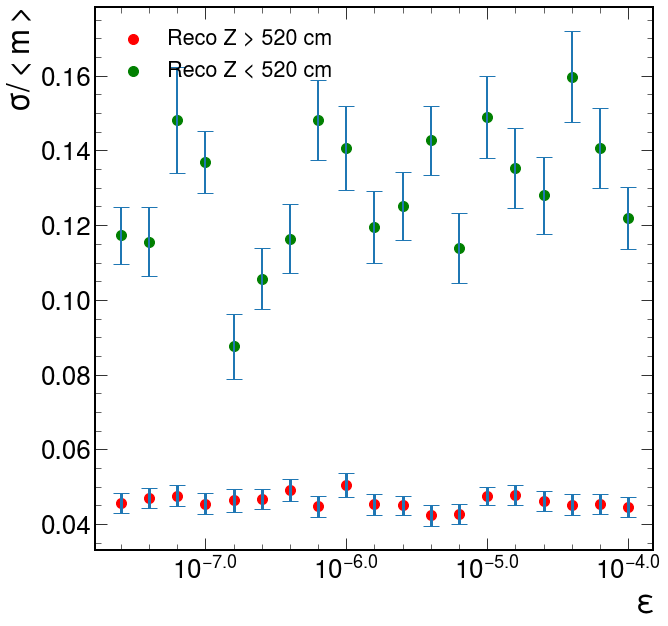

In [68]:
fig, ax = plt.subplots()
im = ax.scatter(coupling_list, res_list_c,
                c = 'r',
                s= 100,
                label='Reco Z > 520 cm')

plt.errorbar(coupling_list,
            res_list_c,
            yerr=err_list_c,
            fmt='none',
            elinewidth=3,
            capsize=8)

plt.scatter(coupling_list_in,
            res_list_c_in,
            c = 'g',
            s= 100,
            label='Reco Z < 520 cm')

plt.errorbar(coupling_list_in,
            res_list_c_in,
            yerr=err_list_c_in,
            fmt='none',
            elinewidth=2,
            capsize=8)



plt.xlabel(r"$\epsilon$")
plt.ylabel(r'$\sigma/<m>$')

# iterate over axes of FacetGrid
labels = ax.get_xticks() # get y labels

new_labels = []
for i,l in enumerate(labels):
    new_labels.append(r"$10^{%s}$"%labels[i])

ax.set_xticklabels(new_labels) # set new labels

plt.legend()
plt.show()

ValueError: 'x' and 'y' must have the same size

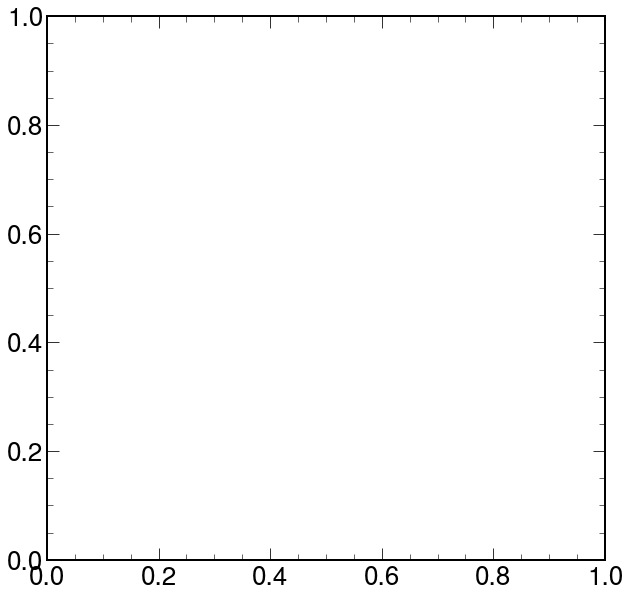

In [56]:
#Plot the error bars
plt.errorbar(coupling_list,
            res_list_c,
            yerr=err_list_c,
            fmt='none',
            elinewidth=3,
            capsize=8)

plt.scatter(coupling_list, res_list_c,
            c = 'r',
            s= 100)

plt.ylabel(r'$\sigma/<m>$')
plt.xlabel(r'$$ [GeV]')

------

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


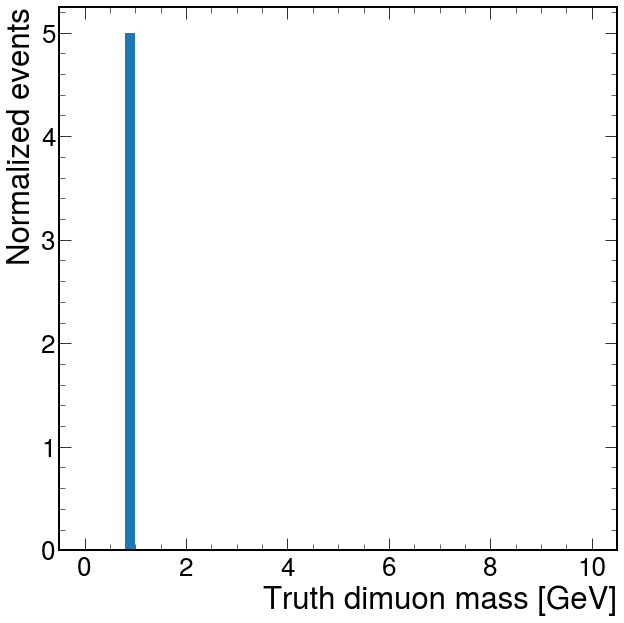

ValueError: in ListOffsetArray64, cannot convert to RegularArray because subarray lengths are not regular

(https://github.com/scikit-hep/awkward-1.0/blob/1.2.0/src/cpu-kernels/awkward_ListOffsetArray_toRegularArray.cpp#L22)

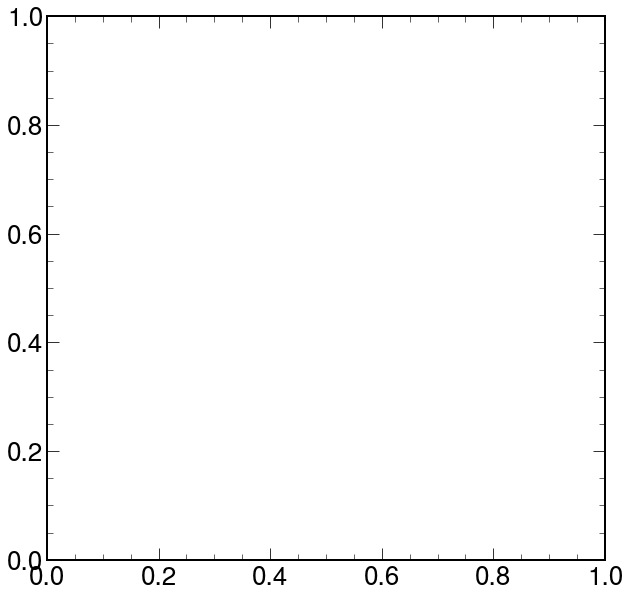

In [4]:
def rms_p(dq_events):
    
    plot_bins = 50
    plot_range = (-2,2)
    
    #Select the events that are reconstructed
    reco_selection = ak.any(dq_events["reco_dimuon"].mass, axis = 1)

    dy_selected = dq_events["reco_dimuon"].mass[reco_selection]
    truth_selected = dq_events["truth_dimuon"].mass[reco_selection]
    
    ##plot the truth and reconstructed momentum
    plt.hist(truth_selected,
             bins = plot_bins,
             range = (0, 10),
             density = True)
    plt.xlabel(r"Truth dimuon mass [GeV]")
    plt.ylabel("Normalized events")
    plt.legend()
    plt.show()
    
    ##plot the truth and reconstructed momentum
    plt.hist(dy_selected,
             bins = plot_bins,
             range = (0, 10),
             density = True)
    plt.xlabel(r"Reco dimuon mass [GeV]")
    plt.ylabel("Normalized events")
    plt.legend()
    plt.show()
    
    #Select the truth momentum range as well
    truth_p_selected = np.linalg.norm([ak.flatten(dq_events["truth_dimuon"].px[reco_selection]),
                                       ak.flatten(dq_events["truth_dimuon"].py[reco_selection]),
                                       ak.flatten(dq_events["truth_dimuon"].pz[reco_selection])],axis = 0)
    
    m_resolution = [] #To save the resolution (sigma) of the fit
    m_err = []
    p_ranges = []
    p_average = []
    
    
    #Loop over different average p range
    for i in range(3):
        
        p_range = 20
        p_min = i*p_range + 60 #GeV
        p_max = (i+1)*p_range + 60
        p_ranges.append([p_min,p_max]) #Save for plotting resolution later
        
        print("Truth momentum range: {},{} GeV".format(p_min, p_max))
        
        local_selection = (truth_p_selected > p_min) & (truth_p_selected < p_max)
        p_average.append(np.mean(truth_p_selected[local_selection]))
        
        residual = copy.deepcopy(np.asarray(dy_selected[local_selection] - truth_selected[local_selection]))
    
#         #Initial distribution of momentum
#         plt.hist(truth_p_selected[local_selection],
#                  bins = plot_bins,
#                  range = (p_min-5, p_max+5),
#                  density = True)
#         plt.plot([],[], 'none', label="Truth p: {}-{} GeV".format(p_min, p_max))
#         plt.xlabel(r"Truth p [GeV]")
#         plt.ylabel("Normalized events")
#         plt.legend()
#         plt.show()
        
        
        #Initial distribution of mass residual
        plt.hist(residual ,
                 bins = plot_bins,
                 range = plot_range,
                 density = True)
        plt.plot([],[], 'none', label="Truth p: {}-{} GeV".format(p_min, p_max))
        
        
        ## Gaussian fit
        ## Fit directly on the histogram
        def fit_function(x, A, mu, sig):
            return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

        bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
        binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
        data_entries, _ = np.histogram(residual, bins=bins,
                                       range = plot_range, density = True)

        mask = data_entries!=0
        #Fit the function to the histogram data.
        popt, pcov = curve_fit(fit_function,
                               xdata=binscenters[mask],
                               ydata=data_entries[mask],
                               sigma = np.sqrt(data_entries[mask]),
                               absolute_sigma = False,
                               p0=[0.1, 0, 0.5])


        #Error for parameter estimations
        perr = np.sqrt(np.diag(pcov))
        print("Error for parameter esimations: ", perr)
        m_err.append(perr[2])

        std_fit = np.abs(popt[2])
        mean_fit = popt[1]
        m_resolution.append(std_fit)

        print("Standard deviation (fit) is", std_fit)
        print("Mean (fit) is", mean_fit)

        #Plot fitted gaussian
        plt.plot(bins,
                 fit_function(bins, *popt),
                 "r-",
                 linewidth=4,
                 label='Best fit')

        plt.plot([],[], 'none', label=r'$\mu=%.2f$ [cm]'%popt[1])
        plt.plot([],[], 'none', label=r'$\sigma=%.4f$ [cm]'%abs(popt[2]))

        #Label the axes
        plt.xlabel(r'Reco $m_{dimuon}$ - Truth $m_{dimuon}$ [GeV]')
        plt.ylabel('Normalized counts')
        
        plt.legend()
        plt.show()
        
    
    ###### Plot resolution versus momentum
    #Plot momentum average
    plt.scatter(p_average, m_resolution, s=180, c='#2ca02c', label = "Average p [GeV]", zorder = 10)
    
    plt.hlines(m_resolution,
               [x[0] for x in p_ranges],
               [x[1] for x in p_ranges],
               colors='r', lw=5,
               linestyles='solid')

    #Plot the error bars
    plt.errorbar([np.average(x) for x in p_ranges],
                m_resolution,
                yerr=m_err,
                fmt='none',
                elinewidth=3,
                capsize=8)
    plt.xlabel(r'Truth $p$ [GeV]')
    plt.ylabel(r'$\sigma_{\Delta~m}$ [GeV]')
    
    plt.legend()
    plt.show()
    
    
rms_p(dq_events)  